In [1]:
# ============================
#  Title:  Multi-Classifier Modeling, Hyperparameter Tuning & Evaluation
#  Author: Siyang Ni
#  Date:   [Date]
#  Notes:  This script showcases a comprehensive pipeline for loading data,
#          preprocessing, model training, hyperparameter tuning, and evaluation
#          across multiple algorithms: RandomForest, GradientBoosting,
#          HistGradientBoosting, XGBoost, and CatBoost. Includes interpretability
#          with SHAP, partial dependence plots, and feature importances.
# ============================

# Setting Up

In [2]:
# ================
# 1. IMPORTS
# ================

# !pip install --upgrade pandas numpy matplotlib seaborn joblib scikit-learn xgboost catboost shap optuna
# pip install --upgrade ipywidgets

import os
import logging
import warnings
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, RandomizedSearchCV, RepeatedStratifiedKFold
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, 
    HistGradientBoostingClassifier 
)
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Interpretability

from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import shap

# Optimization
import optuna

In [5]:
# ================
# 2. CONFIGURATION
# ================
RANDOM_STATE = 42
TEST_SIZE = 0.2
N_SPLITS_CV = 5
SCORING_METRIC = 'roc_auc'
VERBOSE = 1

CPU_COUNT = os.cpu_count()

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [6]:
# ================
# 3. HELPER FUNCTIONS
# ================

def load_data(filepath: str) -> pd.DataFrame:
    """
    Loads data from a CSV file into a Pandas DataFrame.
    
    Parameters
    ----------
    filepath : str
        Full path to the CSV file.
    
    Returns
    -------
    pd.DataFrame or None
        Loaded DataFrame if successful, None if file not found.
    """
    try:
        df = pd.read_csv(os.path.expanduser(filepath))
        logging.info("Data loaded successfully.")
        return df
    except FileNotFoundError:
        logging.error(f"File not found at {filepath}")
        return None


def identify_categorical_columns(df: pd.DataFrame) -> list:
    """
    Identifies columns of type object or category in a DataFrame.
    """
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    logging.info(f"Identified categorical columns: {categorical_cols}")
    return categorical_cols


def convert_to_categorical(df: pd.DataFrame, columns: list) -> None:
    """
    Converts specified columns in a DataFrame to categorical type in-place.
    """
    for col in columns:
        if col in df.columns:
            df[col] = df[col].astype('category')
        else:
            logging.warning(f"Column '{col}' not found in DataFrame.")
    logging.info("Categorical conversion complete.")


def create_train_test_split(
    X: pd.DataFrame, 
    y: pd.Series, 
    test_size: float = TEST_SIZE, 
    random_state: int = RANDOM_STATE
) -> tuple:
    """
    Splits data into training and testing sets.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, 
        stratify=y, shuffle=True
    )
    logging.info(f"Training set shape: {X_train.shape}")
    logging.info(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test


def create_missing_indicators(
    X_train: pd.DataFrame, 
    X_test: pd.DataFrame
) -> tuple:
    """
    Creates binary indicators for missing values in features.
    """
    missing_indicator = MissingIndicator(features='all')
    missing_indicator.fit(X_train)
    X_train_flags = missing_indicator.transform(X_train)
    X_test_flags = missing_indicator.transform(X_test)
    
    missing_columns = [f'missing_{col}' for col in X_train.columns]
    X_train_with_indicators = pd.concat(
        [X_train.reset_index(drop=True),
         pd.DataFrame(X_train_flags, columns=missing_columns)],
        axis=1
    )
    X_test_with_indicators = pd.concat(
        [X_test.reset_index(drop=True),
         pd.DataFrame(X_test_flags, columns=missing_columns)],
        axis=1
    )
    logging.info("Missing indicators created.")
    return X_train_with_indicators, X_test_with_indicators


def create_preprocessor(categorical_features: list) -> ColumnTransformer:
    """
    Creates a preprocessor for categorical features using OneHotEncoder
    while passing other columns through without transformation.
    """
    preprocessor = ColumnTransformer(
        transformers=[
            (
                'cat', 
                OneHotEncoder(
                    drop='first', 
                    handle_unknown='ignore'
                ),
                categorical_features
            )
        ],
        remainder='passthrough'
    )
    return preprocessor


def train_evaluate_model(
    model, 
    X_train: pd.DataFrame, 
    y_train: pd.Series, 
    X_test: pd.DataFrame, 
    y_test: pd.Series, 
    model_name: str = "Model", 
    save_path: str = None
):
    """
    Trains, evaluates, and optionally saves a model. 
    Prints confusion matrix, classification report, and ROC AUC.
    Plots the ROC curve.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    logging.info(f"=== {model_name} Evaluation ===")
    logging.info("Confusion Matrix:\n" + str(confusion_matrix(y_test, y_pred)))
    logging.info("\nClassification Report:\n" + str(classification_report(y_test, y_pred)))
    logging.info(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_pred_proba):.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve on Test Data')
    plt.legend(loc='lower right')
    plt.show()
    
    if save_path:
        joblib.dump(model, save_path)
        logging.info(f"{model_name} saved to '{save_path}'.")
    
    return model


def perform_grid_search(
    pipeline: Pipeline, 
    param_grid: dict, 
    X_train: pd.DataFrame, 
    y_train: pd.Series, 
    cv=None, 
    scoring: str = 'roc_auc', 
    n_jobs: int = -1, 
    verbose: int = 1
):
    """
    Performs GridSearchCV for hyperparameter tuning on a pipeline.
    """
    if cv is None:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(
        estimator=pipeline, 
        param_grid=param_grid, 
        cv=cv, 
        scoring=scoring, 
        n_jobs=n_jobs, 
        verbose=verbose
    )
    grid_search.fit(X_train, y_train)
    logging.info("Best parameters found: " + str(grid_search.best_params_))
    logging.info(f"Best cross-validation {scoring}: {grid_search.best_score_:.4f}")
    return grid_search.best_estimator_


def plot_feature_importance(
    model, 
    feature_names: list, 
    top_n: int = 20, 
    title: str = "Feature Importance"
):
    """
    Plots the top N feature importances from a trained model.
    """
    if hasattr(model, 'feature_importances_'): 
        importances = model.feature_importances_
    elif hasattr(model, 'named_steps') and 'classifier' in model.named_steps:
        if hasattr(model.named_steps['classifier'], 'feature_importances_'):
            importances = model.named_steps['classifier'].feature_importances_
        else:
            raise ValueError("Classifier does not have feature_importances_ attribute.")
    else:
        raise ValueError("Provided model does not have feature_importances_ attribute.")
    
    fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    fi_df = fi_df.sort_values('Importance', ascending=False).head(top_n)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=fi_df)
    plt.title(title)
    plt.tight_layout()
    plt.show()


def aggregate_feature_importance(importances: np.ndarray, encoded_feature_names: list) -> pd.DataFrame:
    """
    Aggregates feature importance of one-hot-encoded features back to original feature names.
    """
    original_features = list(set([feat.split('_')[0] for feat in encoded_feature_names]))
    original_feature_importance = {feature: 0 for feature in original_features}
    for i, encoded_feature in enumerate(encoded_feature_names):
        base_feature = encoded_feature.split('_')[0]
        original_feature_importance[base_feature] += importances[i]
    
    importance_df = pd.DataFrame(
        list(original_feature_importance.items()), 
        columns=['Feature', 'Importance']
    )
    importance_df = importance_df.sort_values('Importance', ascending=False)
    return importance_df


def plot_aggregated_feature_importance(
    importance_df: pd.DataFrame, 
    top_n: int = 20, 
    title: str = "Aggregated Feature Importance"
):
    """
    Plots aggregated feature importances after grouping by base feature.
    """
    top_n_df = importance_df.head(top_n).sort_values(by='Importance', ascending=True)
    plt.figure(figsize=(10, 6))
    plt.barh(y=top_n_df['Feature'], width=top_n_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Preprocessing

In [7]:
# --- Data Loading ---
data_filepath = os.path.expanduser('~/work/vaping_project_data/processed_data_g12n.csv')
new_data = load_data(data_filepath)
if new_data is None:
    logging.error("Data loading failed. Exiting script.")
    raise SystemExit

logging.info("Dataset Info:")
new_data.info()

2025-02-12 10:32:56,542 - INFO - Data loaded successfully.
2025-02-12 10:32:56,543 - INFO - Dataset Info:


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27330 entries, 0 to 27329
Data columns (total 51 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   V2157           27089 non-null  float64
 1   nicotine12d     27330 non-null  float64
 2   V49             27138 non-null  float64
 3   V2134           27074 non-null  float64
 4   V2153           27077 non-null  float64
 5   V2116           26736 non-null  float64
 6   V13             27330 non-null  float64
 7   V2140           27158 non-null  float64
 8   V2101           27060 non-null  float64
 9   V2191           26236 non-null  float64
 10  V2152           27261 non-null  float64
 11  V2196           26045 non-null  float64
 12  V2181           25325 non-null  float64
 13  V2105           26467 non-null  float64
 14  V2171           26760 non-null  float64
 15  V2176           25571 non-null  float64
 16  V2201           25764 non-null  float64
 17  V2186           26174 non-null 

In [7]:
# -----------------------------------------------------------------------------
# Missing Data Analysis
# -----------------------------------------------------------------------------

total_missing = new_data.isna().sum().sum()
print("\nTotal missing values:", total_missing)

# Count negative values in numeric columns.
numeric_cols = new_data.select_dtypes(include=[np.number]).columns
negative_counts = new_data[numeric_cols].apply(lambda x: (x < 0).sum())
negative_counts_df = pd.DataFrame({
    'Column': negative_counts.index,
    'Negative_Count': negative_counts.values
})
print("\nNegative value counts by numeric column:")
print(negative_counts_df)

# Replace negative codes (-9, -8) with NaN.
missing_codes = [-9, -8]
new_data[numeric_cols] = new_data[numeric_cols].replace({-9: np.nan, -8: np.nan})

# Compute missing counts and percentages.
missing_counts = new_data.isna().sum()
missing_percent = (new_data.isna().mean() * 100).round(2)
missing_summary = pd.DataFrame({
    'Missing_Count': missing_counts,
    'Missing_Percentage': missing_percent
}).sort_values(by='Missing_Percentage', ascending=False)
print("\nMissing values summary:")
print(missing_summary.to_string())


Total missing values: 42183

Negative value counts by numeric column:
            Column  Negative_Count
0            V2157               0
1      nicotine12d               0
2              V49               0
3            V2134               0
4            V2153               0
5            V2116               0
6              V13               0
7            V2140               0
8            V2101               0
9            V2191               0
10           V2152               0
11           V2196               0
12           V2181               0
13           V2105               0
14           V2171               0
15           V2176               0
16           V2201               0
17           V2186               0
18           V2173               0
19           V2189               0
20           V2188               0
21           V2128               0
22           V2183               0
23           V2166               0
24           V2182               0
25           V2197 


Spearman Correlation Matrix:
                   V2157       V49     V2134     V2153     V2116       V13  \
V2157           1.000000  0.177523 -0.018059  0.002677 -0.045543 -0.011397   
V49             0.177523  1.000000  0.002501  0.009298  0.017583  0.053108   
V2134          -0.018059  0.002501  1.000000 -0.012872  0.107274  0.029319   
V2153           0.002677  0.009298 -0.012872  1.000000 -0.016135  0.002073   
V2116          -0.045543  0.017583  0.107274 -0.016135  1.000000 -0.037303   
V13            -0.011397  0.053108  0.029319  0.002073 -0.037303  1.000000   
V2140          -0.030659 -0.006908  0.120081 -0.024674  0.028825  0.005610   
V2101          -0.075463  0.029723  0.121544 -0.019693  0.397783  0.012419   
V2191           0.003747  0.085472  0.019914 -0.000764  0.153523 -0.057757   
V2152           0.049889 -0.053983 -0.003382 -0.011898  0.048603  0.029422   
V2196          -0.009347 -0.067610  0.017914 -0.026505  0.123414 -0.059097   
V2181          -0.014811  0.076872

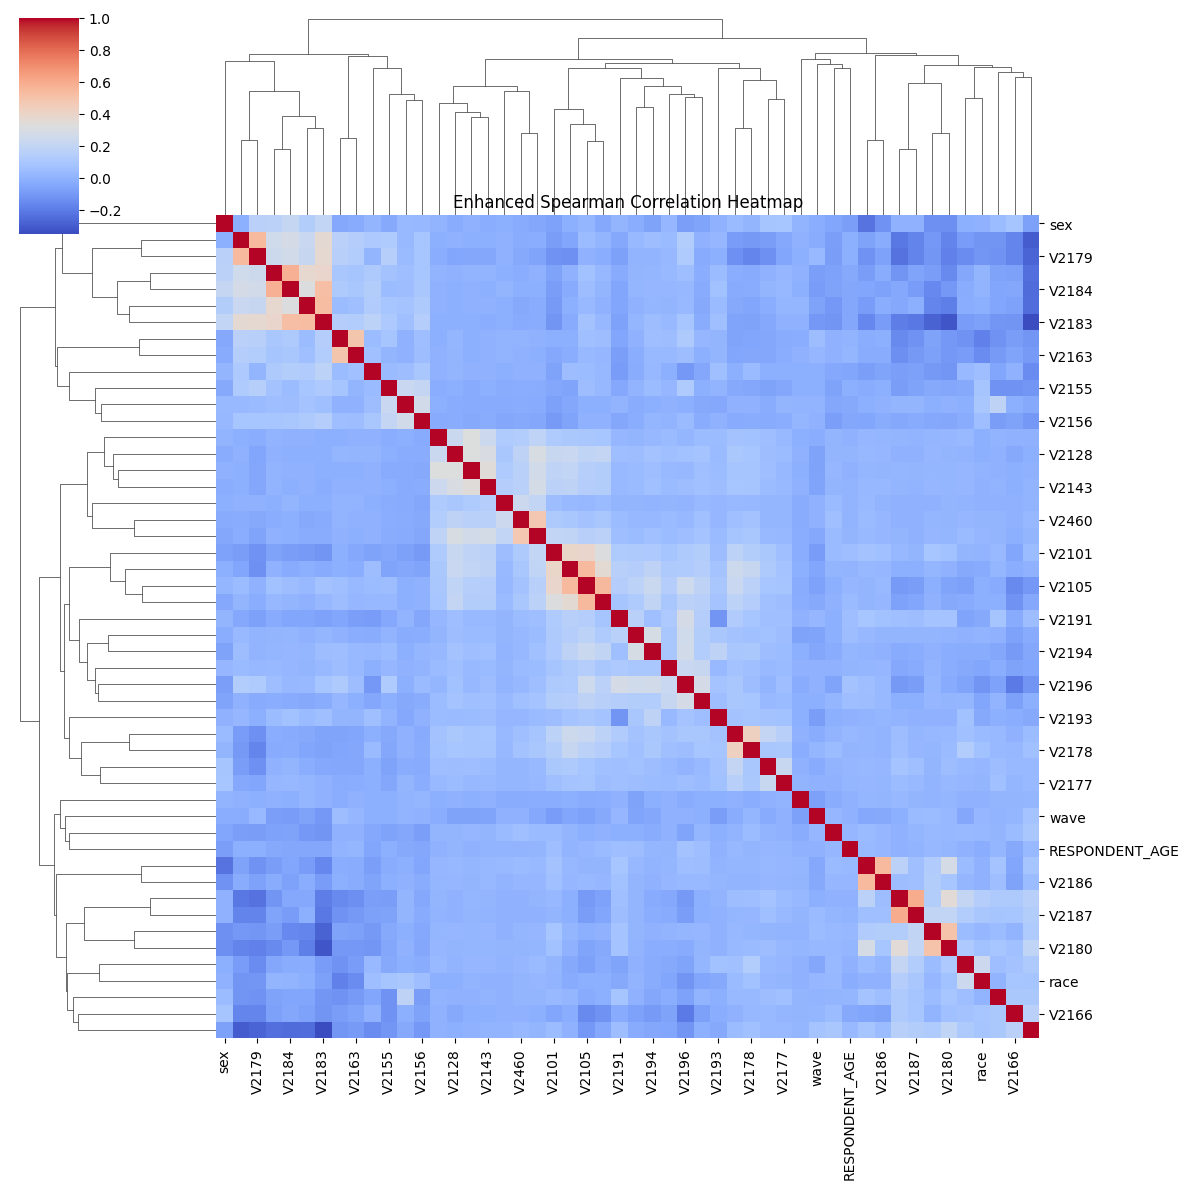


Highly correlated variable pairs (|corr| > 0.5):
  Variable1 Variable2  Correlation
0     V2116     V2105     0.537014
1     V2181     V2186     0.538938
2     V2105     V2108     0.544549
3     V2173     V2179     0.539722
4     V2189     V2184     0.580946
5     V2188     V2183     0.527055
6     V2183     V2184     0.523170
7     V2182     V2187     0.597073
8     V2185     V2180     0.500559


In [70]:
# Correlation Analysis
# Select numeric variables (excluding the target variable 'nicotine12d' if desired).
cor_vars = new_data.drop(columns=['nicotine12d'], errors='ignore').select_dtypes(include=[np.number])

# Compute the Spearman correlation matrix.
cor_matrix_spearman = cor_vars.corr(method='spearman')

# Check for non-finite values in the correlation matrix.
if not np.all(np.isfinite(cor_matrix_spearman)):
    print("\nWarning: Non-finite values detected in the correlation matrix.")
    # Replace NaN or infinite values with 0 (or another appropriate value).
    cor_matrix_spearman = cor_matrix_spearman.fillna(0)
    cor_matrix_spearman = cor_matrix_spearman.replace([np.inf, -np.inf], 0)

print("\nSpearman Correlation Matrix:")
print(cor_matrix_spearman)

# Create an enhanced heatmap with clustering.
clustergrid = sns.clustermap(cor_matrix_spearman, cmap="coolwarm", figsize=(12, 12))
clustergrid.ax_heatmap.set_title("Enhanced Spearman Correlation Heatmap")
plt.show()

# Identify highly correlated pairs (absolute correlation > 0.5 and less than 1).
high_corr_pairs = []
cols = cor_matrix_spearman.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        corr_value = cor_matrix_spearman.iloc[i, j]
        if 0.5 < abs(corr_value) < 1:
            high_corr_pairs.append({
                "Variable1": cols[i],
                "Variable2": cols[j],
                "Correlation": corr_value
            })

high_corr_df = pd.DataFrame(high_corr_pairs)
print("\nHighly correlated variable pairs (|corr| > 0.5):")
print(high_corr_df)

In [8]:
# --- Identify & Convert Categorical Columns ---
import logging

# Identify all categorical (object or categorical dtype) columns
categorical_predictor_cols = new_data.select_dtypes(include=['object', 'category']).columns.tolist()

# If you also want to include numerical columns as categorical (optional)
# categorical_predictor_cols = new_data.columns.tolist()  

# Convert identified columns to categorical
convert_to_categorical(new_data, categorical_predictor_cols)

# Logging information
logging.info("Verifying data types after conversion:")
logging.info(new_data[categorical_predictor_cols].dtypes)

# --- Train/Test Split ---
X = new_data.drop('nicotine12d', axis=1)
y = new_data['nicotine12d']
X_train, X_test, y_train, y_test = create_train_test_split(X, y)

logging.info("Train Set Balance:")
logging.info(y_train.value_counts(normalize=True))
logging.info("Test Set Balance:")
logging.info(y_test.value_counts(normalize=True))

# --- Missing Value Indicators ---
X_train_with_indicators, X_test_with_indicators = create_missing_indicators(X_train, X_test)

# Treat everything as categorical in this example
categorical_features = X_train_with_indicators.columns.tolist()

# Create & Fit Preprocessor
preprocessor = create_preprocessor(categorical_features)
preprocessor.fit(X_train_with_indicators)
logging.info("Preprocessor fitted successfully.")

2025-02-12 10:32:59,451 - INFO - Categorical conversion complete.
2025-02-12 10:32:59,452 - INFO - Verifying data types after conversion:
2025-02-12 10:32:59,453 - INFO - Series([], dtype: object)
2025-02-12 10:32:59,478 - INFO - Training set shape: (21864, 50)
2025-02-12 10:32:59,479 - INFO - Testing set shape: (5466, 50)
2025-02-12 10:32:59,480 - INFO - Train Set Balance:
2025-02-12 10:32:59,483 - INFO - nicotine12d
1.0    0.516603
0.0    0.483397
Name: proportion, dtype: float64
2025-02-12 10:32:59,484 - INFO - Test Set Balance:
2025-02-12 10:32:59,485 - INFO - nicotine12d
1.0    0.516648
0.0    0.483352
Name: proportion, dtype: float64
2025-02-12 10:32:59,503 - INFO - Missing indicators created.
2025-02-12 10:32:59,906 - INFO - Preprocessor fitted successfully.


# Model Training

## Lasso

Fitting 5 folds for each of 252 candidates, totalling 1260 fits


Best Parameters: {'classifier__C': 100, 'classifier__class_weight': 'balanced', 'classifier__max_iter': 1000, 'classifier__tol': 0.01, 'preprocessor__cat__onehot__drop': None}
Best ROC AUC: 0.734215251610616


2025-02-10 14:39:46,938 - INFO - === Tuned LASSO Logistic Regression Evaluation ===
2025-02-10 14:39:46,944 - INFO - Confusion Matrix:
[[1826  816]
 [ 796 2028]]
2025-02-10 14:39:46,957 - INFO - 
Classification Report:
              precision    recall  f1-score   support

         0.0       0.70      0.69      0.69      2642
         1.0       0.71      0.72      0.72      2824

    accuracy                           0.71      5466
   macro avg       0.70      0.70      0.70      5466
weighted avg       0.71      0.71      0.71      5466

2025-02-10 14:39:46,962 - INFO - ROC AUC: 0.7285


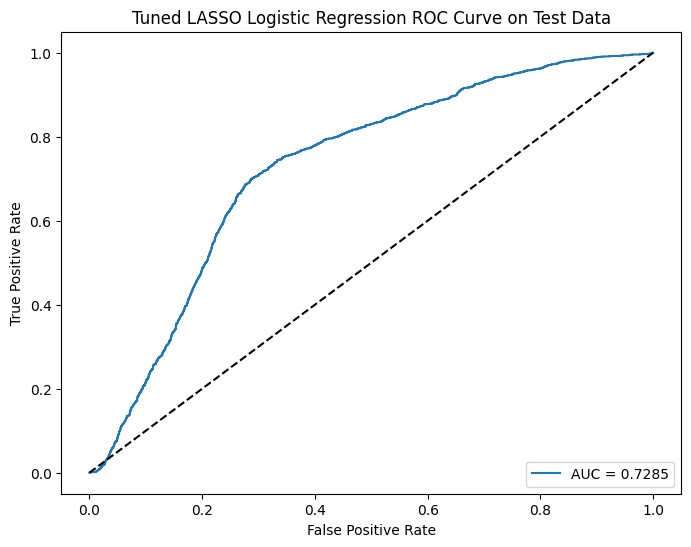

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['V2157', 'V49', 'V2134', 'V2153', 'V2116', 'V13', 'V2140', 'V2101',
       'V2191', 'V2152', 'V2196', 'V2181', 'V2105', 'V2171', 'V2176', 'V2201',
       'V2186', 'V2173', 'V2189', 'V2188', 'V2128', 'V2183', 'V2166', '...
       'wave', 'V2108', 'V2164', 'V2172', 'V2193', 'V2194', 'V2180', 'V2177',
       'V2125', 'sex', 'V2163'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('classifier',
                 LogisticRegression(C=100, class_weight='balanced',
                                    max_iter=1000, penalty='l1', solver='saga',
                                    tol=0.01))])

In [92]:
# Define the preprocessing for numeric columns (scale them)
numeric_features = X_train_with_indicators.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Define the preprocessing for categorical features (encode them)
categorical_features = X_train_with_indicators.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Create the pipeline
lasso_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', LogisticRegression(penalty='l1', solver='saga'))])
# Define an expanded tuning grid.
# - 'classifier__C': A wide range of regularization strengths.
# - 'classifier__tol': Different tolerance levels for stopping criteria.
# - 'classifier__max_iter': More iterations to ensure convergence.
# - 'preprocessor__cat__drop': Option to drop the first level or keep all levels.
param_grid = {
    'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__tol': [1e-4, 1e-3, 1e-2],
    'classifier__max_iter': [1000, 2000, 5000],
    # Tune whether to drop the first level for categorical features or not.
    'preprocessor__cat__onehot__drop': [None, 'first'],
    # Experiment with class weights (None or 'balanced') to help if classes are imbalanced.
    'classifier__class_weight': [None, 'balanced']
}

# Define a cross-validation strategy.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Initialize GridSearchCV with your pipeline (lasso_pipeline)
grid_search = GridSearchCV(
    estimator=lasso_pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Fit the grid search on the training data.
grid_search.fit(X_train_with_indicators, y_train)

# Display the best parameters and the best ROC AUC achieved during cross-validation.
print("Best Parameters:", grid_search.best_params_)
print("Best ROC AUC:", grid_search.best_score_)

# Use the best estimator to evaluate performance on the test data.
best_lasso_model = grid_search.best_estimator_
train_evaluate_model(
    model=best_lasso_model,
    X_train=X_train_with_indicators,
    y_train=y_train,
    X_test=X_test_with_indicators,
    y_test=y_test,
    model_name="Tuned LASSO Logistic Regression"
)


Top 20 Aggregated Feature Importances (by absolute coefficient value):
wave     0.936661
V2101    0.111797
V2137    0.094999
V2116    0.085846
sex      0.083274
V2134    0.082261
V2128    0.072807
V2143    0.057164
V2166    0.053890
V2176    0.053228
V2188    0.049381
V2187    0.046194
V2164    0.040898
V2194    0.039511
V2153    0.039178
V2179    0.038608
V13      0.038084
V2197    0.037636
V2157    0.037193
V2163    0.034552
dtype: float64


/tmp/ipykernel_2677733/809380159.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top20_features.values, y=top20_features.index, palette="viridis")


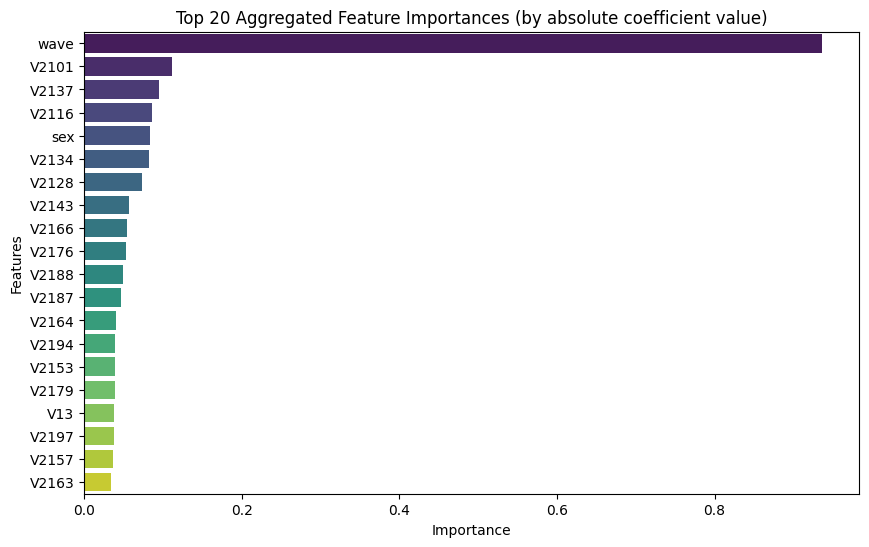

In [93]:
import numpy as np
import pandas as pd

# Assume 'best_lasso_model' is your already fitted pipeline from GridSearchCV.
# Extract the logistic regression model from the pipeline.
lr = best_lasso_model.named_steps['classifier']

# For binary classification, lr.coef_ has shape (1, n_features)
coefficients = lr.coef_[0]

# Get the preprocessor (the ColumnTransformer) from the pipeline.
preprocessor = best_lasso_model.named_steps['preprocessor']

# -------------------------------
# 1. Numeric Features and Importances
# -------------------------------
# The numeric transformer was applied first.
numeric_features = preprocessor.transformers_[0][2]  # list (or Index) of numeric feature names
n_numeric = len(numeric_features)
numeric_coefs = coefficients[:n_numeric]
numeric_importances = pd.Series(np.abs(numeric_coefs), index=numeric_features)

# -------------------------------
# 2. Categorical Features (Aggregation)
# -------------------------------
# Get the original categorical columns from the transformer.
cat_features = preprocessor.transformers_[1][2]

# Check if there are any categorical features
if len(cat_features) > 0:
    # Retrieve the OneHotEncoder from the categorical pipeline.
    onehot_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
    
    # The remaining coefficients correspond to the one-hot encoded features.
    categorical_coefs = coefficients[n_numeric:]
    
    aggregated_cat_importance = {}
    start_idx = 0
    # Loop over each original categorical feature and its categories.
    for feature, categories in zip(cat_features, onehot_encoder.categories_):
        n_categories = len(categories)
        # Get the coefficients for the dummy columns of this feature.
        feature_coefs = categorical_coefs[start_idx:start_idx + n_categories]
        # Aggregate by summing the absolute values.
        aggregated_cat_importance[feature] = np.sum(np.abs(feature_coefs))
        start_idx += n_categories

    aggregated_cat_importance = pd.Series(aggregated_cat_importance)
else:
    # If there are no categorical features, create an empty Series.
    aggregated_cat_importance = pd.Series(dtype=float)

# -------------------------------
# 3. Combine and Select Top 20
# -------------------------------
combined_importances = pd.concat([numeric_importances, aggregated_cat_importance])
top20_features = combined_importances.sort_values(ascending=False).head(20)

print("Top 20 Aggregated Feature Importances (by absolute coefficient value):")
print(top20_features)

# Plot the top 20 features
plt.figure(figsize=(10, 6))
sns.barplot(x=top20_features.values, y=top20_features.index, palette="viridis")
plt.title('Top 20 Aggregated Feature Importances (by absolute coefficient value)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


/tmp/ipykernel_2677733/1992828924.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=perm_imp_df.head(20), palette='magma')


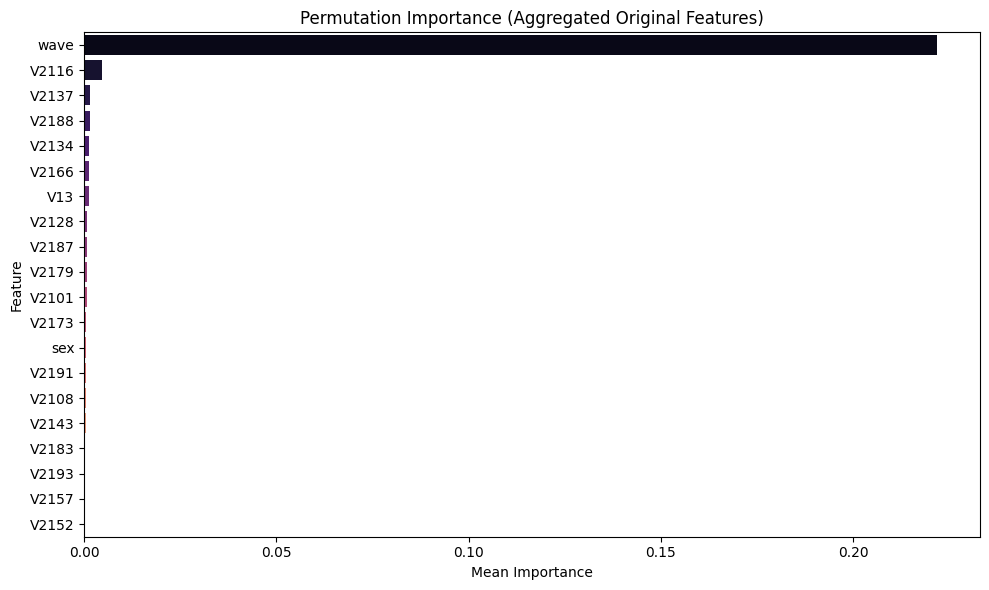

In [94]:
#########################################
# 2. Permutation Importance (Aggregated by Original Feature)
#########################################

from sklearn.inspection import permutation_importance

# Compute permutation importance using the original features (X_test_with_indicators).
perm_results = permutation_importance(
    best_lasso_model,
    X_test_with_indicators,
    y_test,
    scoring='roc_auc',
    n_repeats=10,
    random_state=RANDOM_STATE
)

perm_imp_df = pd.DataFrame({
    'Feature': X_test_with_indicators.columns,
    'Importance': perm_results.importances_mean
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=perm_imp_df.head(20), palette='magma')
plt.title("Permutation Importance (Aggregated Original Features)")
plt.xlabel("Mean Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


Top 20 Important Features:
           Feature  Importance
39            wave    0.860726
48             sex    0.082963
7            V2101    0.077176
4            V2116    0.064499
22           V2166    0.046265
19           V2188    0.045918
28           V2187    0.039575
0            V2157    0.034091
41           V2164    0.033977
5              V13    0.032991
14           V2176    0.032740
44           V2194    0.032253
35           V2179    0.030466
49           V2163    0.029160
25  RESPONDENT_AGE    0.027436
23           V2182    0.025939
42           V2172    0.025446
32           V2184    0.024848
3            V2153    0.023676
17           V2173    0.023630


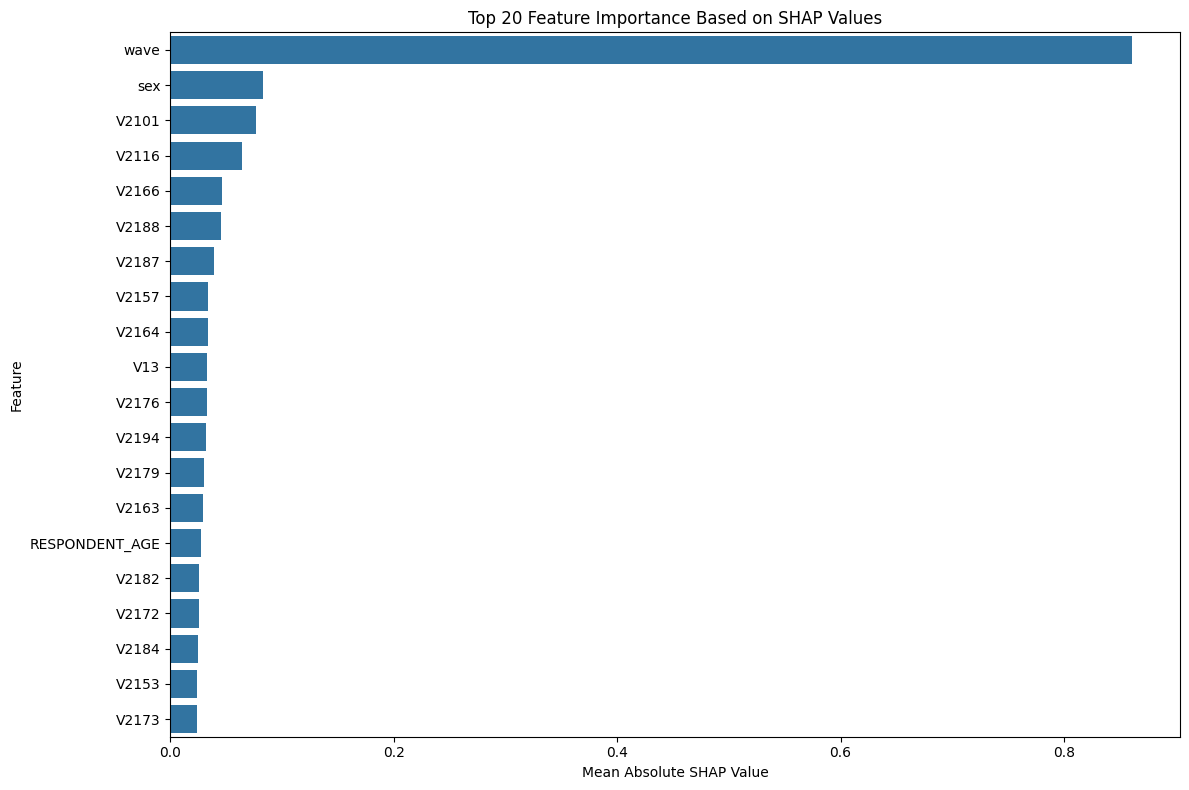

In [99]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature names (only using available features)
feature_names = numeric_features

# Calculate SHAP values for numeric features
explainer = shap.LinearExplainer(
    best_lasso_model.named_steps['classifier'],
    best_lasso_model.named_steps['preprocessor'].transform(X_train_with_indicators)
)
shap_values = explainer.shap_values(
    best_lasso_model.named_steps['preprocessor'].transform(X_train_with_indicators)
)

# Calculate feature importance (using absolute mean SHAP values)
feature_importance = {}
for idx, feature in enumerate(feature_names):
    if idx < shap_values.shape[1]:  # Only process features within bounds
        feature_importance[feature] = np.abs(shap_values[:, idx]).mean()

# Convert to DataFrame and sort
importance_df = pd.DataFrame({
    'Feature': list(feature_importance.keys()),
    'Importance': list(feature_importance.values())
}).sort_values('Importance', ascending=False)

# Display top 20 features
print("\nTop 20 Important Features:")
print(importance_df.head(20))

# Create visualization
plt.figure(figsize=(12, 8))
sns.barplot(data=importance_df.head(20), x='Importance', y='Feature')
plt.title('Top 20 Feature Importance Based on SHAP Values')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


Top 10 Features: ['wave', 'sex', 'V2101', 'V2116', 'V2166', 'V2188', 'V2187', 'V2157', 'V2164', 'V13']
wave: float64
sex: float64
V2101: float64
V2116: float64
V2166: float64
V2188: float64
V2187: float64
V2157: float64
V2164: float64
V13: float64
Unique Values in Top 10 Features:
wave: [2021. 2022. 2019. 2018. 2017. 2020.]
sex: [0. 1.]
V2101: [ 1.  2.  5.  4.  3. nan]
V2116: [ 4.  1.  3.  6.  7.  2.  5. nan]
V2166: [ 2.  5.  1.  6.  4.  3.  8. nan  7.]
V2188: [ 0.  1. nan]
V2187: [ 0.  1. nan]
V2157: [ 1. nan  0.]
V2164: [ 4.  6.  5.  7.  3.  2.  1. nan]
V13: [1. 2. 3. 4.]


Error plotting PDP for sex: cannot reshape array of size 1 into shape (2)


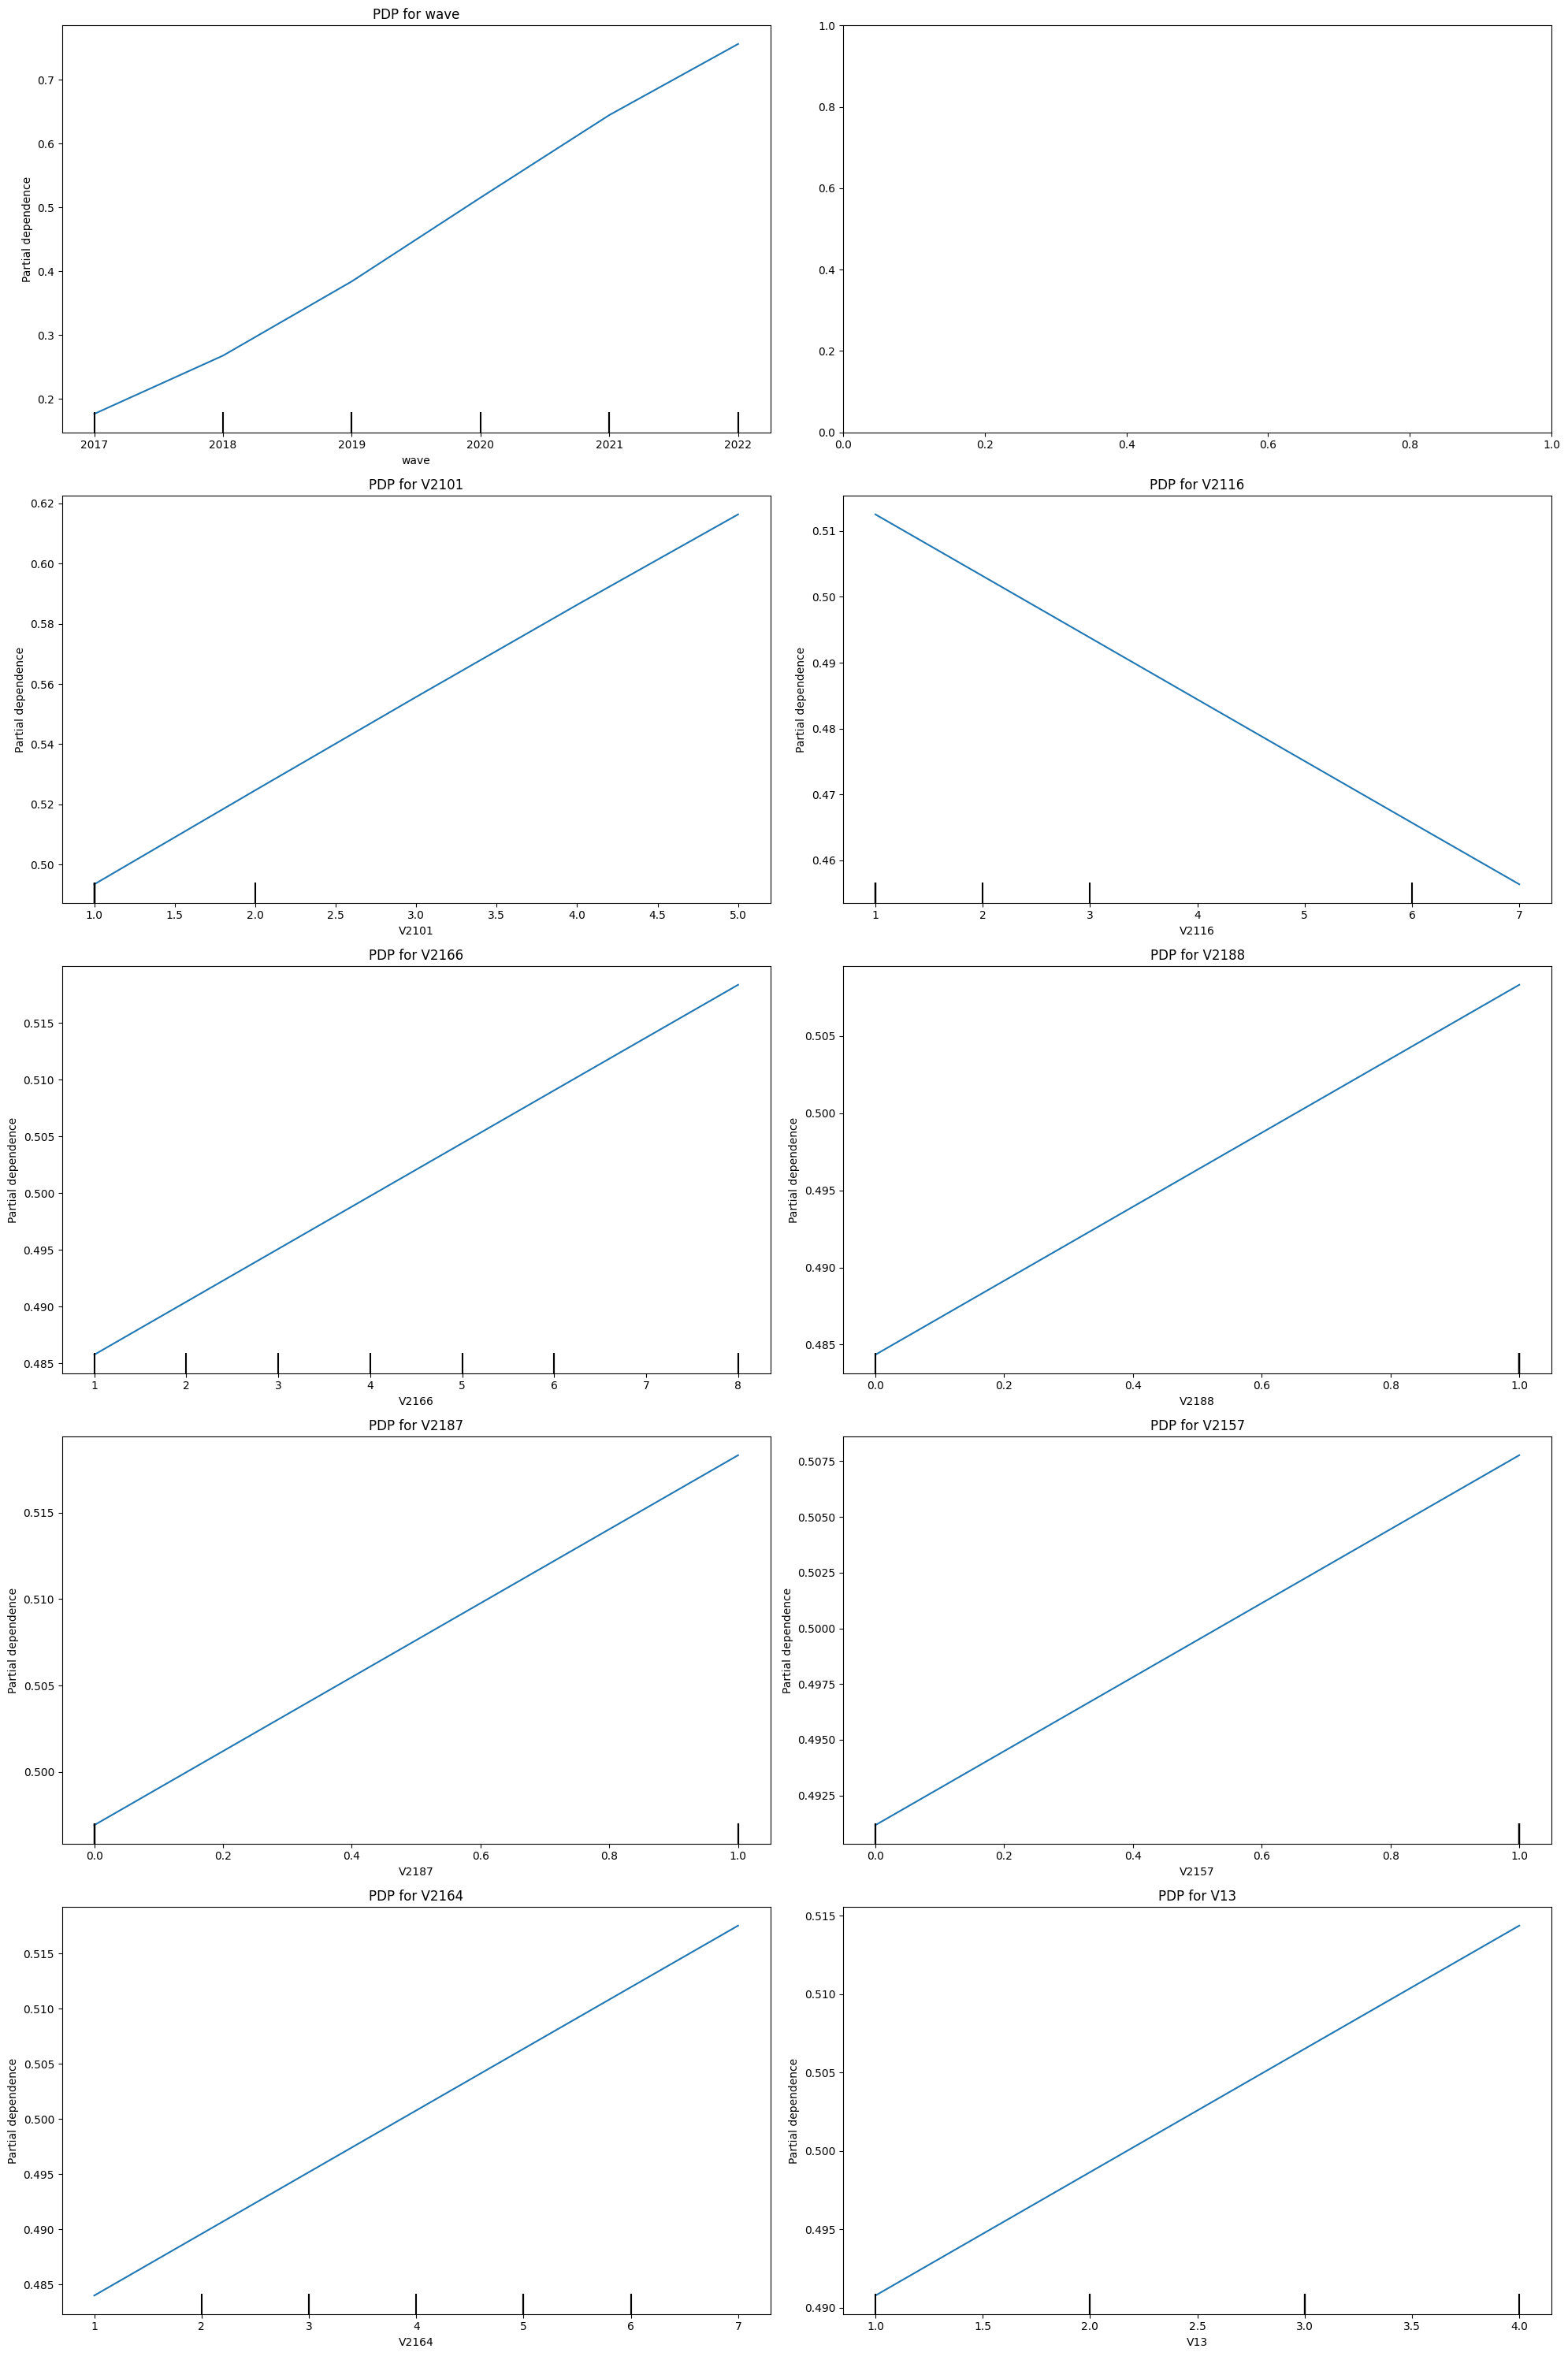

In [158]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

top_10_features = importance_df.head(10)['Feature'].tolist()

print("Top 10 Features:", top_10_features)
for feature in top_10_features:
    print(f"{feature}: {X_train_with_indicators[feature].dtype}")

print("Unique Values in Top 10 Features:")
for feature in top_10_features:
    unique_values = X_train_with_indicators[feature].unique()
    print(f"{feature}: {unique_values}")

fig, axes = plt.subplots(5, 2, figsize=(20, 30))
axes = axes.flatten()
for i, feature in enumerate(top_10_features):
    if len(X_train_with_indicators[feature].unique()) > 1:
        try:
            PartialDependenceDisplay.from_estimator(
                best_lasso_model,
                X_train_with_indicators,
                features=[feature],
                ax=axes[i]
            )
            axes[i].set_title(f'PDP for {feature}')
        except ValueError as e:
            print(f"Error plotting PDP for {feature}: {e}")
    else:
        print(f"Skipping PDP for {feature}: Only one unique value in the dataset.")
        axes[i].set_visible(False)

plt.tight_layout()
plt.show()


In [159]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Set a random state for reproducibility.
RANDOM_STATE = 42

# ----------------------------
# 1. Build the Pipeline
# ----------------------------
# This pipeline consists of:
#  - preprocessor: your existing preprocessor for data cleaning/encoding.
#  - poly: PolynomialFeatures with degree 2 (pairwise interactions only, no bias).
#  - classifier: LogisticRegression with L1 penalty (sparse model) using the liblinear solver.
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ('classifier', LogisticRegression(
        penalty='l1',
        solver='liblinear',
        random_state=RANDOM_STATE,
        max_iter=1000
    ))
])

# ----------------------------
# 2. Set Up Hyperparameter Tuning
# ----------------------------
# Here we define a parameter grid for tuning.
# In this example, we tune the inverse regularization strength 'C' for logistic regression.
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear'],  # 'saga' could also be tested if using larger datasets
    'classifier__max_iter': [500, 1000],
    'classifier__tol': [1e-4, 1e-3, 1e-2]
}


# ----------------------------
# 3. Create and Fit GridSearchCV
# ----------------------------
# We use 5-fold cross-validation and accuracy as the scoring metric.
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,    # Use all available CPU cores.
    verbose=1
)

# Fit the grid search on the training data.
grid_search.fit(X_train_with_indicators, y_train)

# ----------------------------
# 4. Evaluate the Best Model
# ----------------------------
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation accuracy: {:.4f}".format(grid_search.best_score_))

# Use the best model to predict on the test set.
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_with_indicators)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.4f}".format(test_accuracy))


Fitting 5 folds for each of 48 candidates, totalling 240 fits


/storage/home/szn5432/work/vaping_project/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/storage/home/szn5432/work/vaping_project/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/storage/home/szn5432/work/vaping_project/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/storage/home/szn5432/work/vaping_project/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories wi

Best hyperparameters: {'classifier__C': 0.1, 'classifier__max_iter': 500, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear', 'classifier__tol': 0.0001}
Best cross-validation accuracy: 0.8222
Test set accuracy: 0.8311


Best hyperparameters: {'classifier__C': 0.1, 'classifier__max_iter': 500, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear', 'classifier__tol': 0.0001}
Best cross-validation accuracy: 0.8222
Test set accuracy: 0.8311
Test set ROC AUC: 0.9092
Test set F1 score: 0.8358

Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.83      0.83      2642
         1.0       0.84      0.83      0.84      2824

    accuracy                           0.83      5466
   macro avg       0.83      0.83      0.83      5466
weighted avg       0.83      0.83      0.83      5466



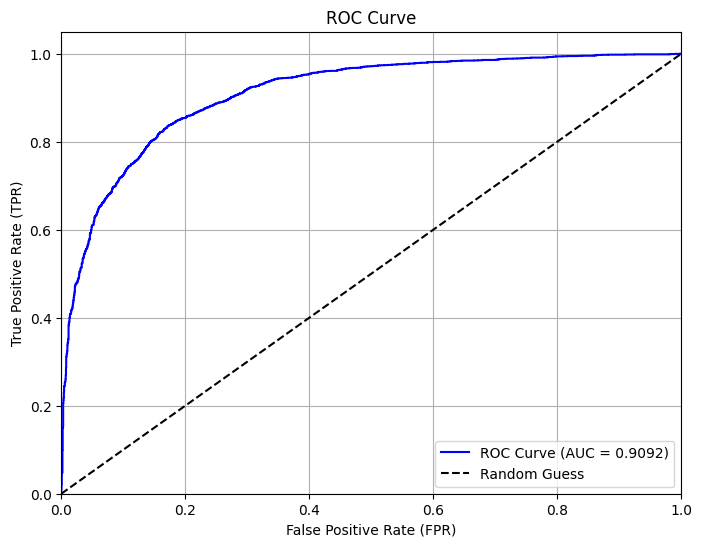

In [160]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    f1_score,
    classification_report,
    roc_curve  # For ROC curve
)
import matplotlib.pyplot as plt  # For plotting

# ----------------------------
# 4. Evaluate the Best Model
# ----------------------------
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation accuracy: {:.4f}".format(grid_search.best_score_))

# Use the best model to predict on the test set.
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_with_indicators)
y_pred_proba = best_model.predict_proba(X_test_with_indicators)[:, 1]  # Get probabilities for the positive class

# Calculate additional metrics
test_accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)

print("Test set accuracy: {:.4f}".format(test_accuracy))
print("Test set ROC AUC: {:.4f}".format(roc_auc))
print("Test set F1 score: {:.4f}".format(f1))

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ----------------------------
# 5. Plot the ROC Curve
# ----------------------------
# Compute FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")  # Diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Top 20 Aggregated Interaction Features by Summed Absolute Coefficient:
     feature_combination  aggregated_importance
290        (V2116, wave)              30.087397
197        (V2105, wave)              27.667149
149        (V2101, wave)              12.221327
1289       (V2196, wave)               3.162883
244        (V2108, wave)               3.118141
1322        (race, wave)               2.999046
1270       (V2194, wave)               1.939342
1247       (V2191, wave)               1.269771
1049       (V2179, wave)               1.182050
829        (V2166, wave)               1.046628
1297       (V2197, wave)               0.970478
1304       (V2201, wave)               0.770332
253       (V2116, V2153)               0.735791
1319     (missing, wave)               0.706448
584        (V2152, wave)               0.684267
919        (V2173, wave)               0.665854
100          (V13, wave)               0.624143
695        (V2156, wave)               0.620356
195        (V2105

/tmp/ipykernel_2677733/2016154660.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


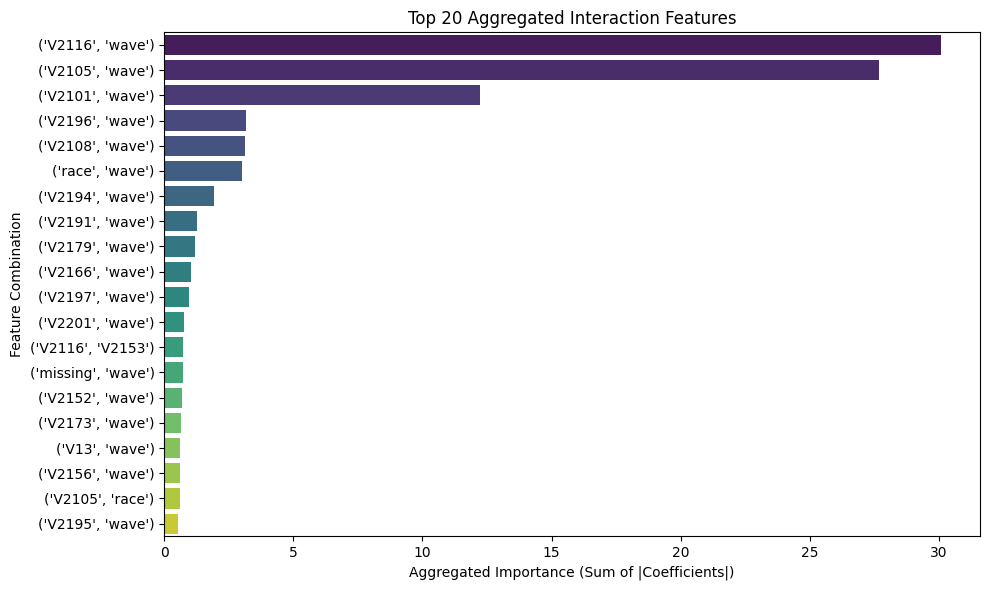

In [161]:
# -----------------------------
# Step 1: Retrieve One-Hot Encoded Feature Names
# -----------------------------
# Access the OneHotEncoder from your pipeline's preprocessor (assumed to be named 'cat')
preprocessor_in_model = best_model.named_steps['preprocessor']
ohe = preprocessor_in_model.named_transformers_['cat']
encoded_feature_names = ohe.get_feature_names_out(categorical_features)

# -----------------------------
# Step 2: Retrieve Interaction Feature Names
# -----------------------------
# Get the feature names after applying PolynomialFeatures (which created interaction terms)
interaction_transformer = best_model.named_steps['poly']  # Corrected step name here
interaction_feature_names = interaction_transformer.get_feature_names_out(encoded_feature_names)

# -----------------------------
# Step 3: Extract Classifier Coefficients
# -----------------------------
# For binary classification, the classifier’s coef_ is an array of shape (1, n_features)
coefficients = best_model.named_steps['classifier'].coef_[0]

# Build a DataFrame mapping each expanded feature (both main effects and interactions) to its coefficient
features_df = pd.DataFrame({
    'interaction_feature': interaction_feature_names,
    'coefficient': coefficients,
    'abs_coef': np.abs(coefficients)
})

# -----------------------------
# Step 4: Filter for Interaction Features Only
# -----------------------------
# With interaction_only=True, main effects do not contain a space, while interaction terms do.
interaction_df = features_df[features_df['interaction_feature'].str.contains(' ')].copy()

# -----------------------------
# Step 5: Aggregate to Original Feature Combinations
# -----------------------------
# Define a function to extract the original feature names from an interaction term.
def extract_original_features(interaction_term):
    # For example, "V13_A V2152_B" or "V13_A V2152_B V49_Low"
    parts = interaction_term.split(' ')
    # Extract the original feature name from each part (everything before the underscore)
    original_features = [part.split('_')[0] for part in parts]
    # Sort the features so order doesn't matter (e.g., ('V13', 'V2152') is the same as ('V2152', 'V13'))
    return tuple(sorted(original_features))

# Create a new column for the aggregated original feature combination
interaction_df['feature_combination'] = interaction_df['interaction_feature'].apply(extract_original_features)

# Group by the original feature combination and sum the absolute coefficient values as a measure of importance
agg_interactions = (
    interaction_df.groupby('feature_combination')['abs_coef']
    .sum()
    .reset_index()
    .rename(columns={'abs_coef': 'aggregated_importance'})
)

# Sort the aggregated interactions by importance in descending order
agg_interactions = agg_interactions.sort_values('aggregated_importance', ascending=False)

# -----------------------------
# Step 6: Display the Top 20 Aggregated Interaction Features
# -----------------------------
top20_agg_interactions = agg_interactions.head(20)
print("Top 20 Aggregated Interaction Features by Summed Absolute Coefficient:")
print(top20_agg_interactions)

# Optionally, plot the results.
plt.figure(figsize=(10, 6))
sns.barplot(
    x='aggregated_importance',
    y=top20_agg_interactions['feature_combination'].astype(str),
    data=top20_agg_interactions,
    palette='viridis'
)
plt.title("Top 20 Aggregated Interaction Features")
plt.xlabel("Aggregated Importance (Sum of |Coefficients|)")
plt.ylabel("Feature Combination")
plt.tight_layout()
plt.show()

In [162]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Set a random state for reproducibility.
RANDOM_STATE = 42

# ----------------------------
# 1. Build the Pipeline
# ----------------------------
# This pipeline consists of:
#  - preprocessor: your existing preprocessor for data cleaning/encoding.
#  - poly: PolynomialFeatures with degree 2 (pairwise interactions only, no bias).
#  - classifier: LogisticRegression with L1 penalty (sparse model) using the liblinear solver.
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)),
    ('classifier', LogisticRegression(
        penalty='l1',
        solver='liblinear',
        random_state=RANDOM_STATE,
        max_iter=500
    ))
])

# ----------------------------
# 2. Set Up Hyperparameter Tuning
# ----------------------------
# Here we define a parameter grid for tuning.
# In this example, we tune the inverse regularization strength 'C' for logistic regression.
param_grid = {
    'classifier__C': [0.01, 0.1, 1],
    'classifier__penalty': ['l1'],
    'classifier__solver': ['liblinear'],
    'classifier__max_iter': [500, 1000],
    'classifier__tol': [1e-4]
}


# ----------------------------
# 3. Create and Fit GridSearchCV
# ----------------------------
# We use 5-fold cross-validation and accuracy as the scoring metric.
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=5,    # Use all available CPU cores.
    verbose=1
)

# Fit the grid search on the training data.
grid_search.fit(X_train_with_indicators, y_train)

# ----------------------------
# 4. Evaluate the Best Model
# ----------------------------
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation accuracy: {:.4f}".format(grid_search.best_score_))

# Use the best model to predict on the test set.
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_with_indicators)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.4f}".format(test_accuracy))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/storage/home/szn5432/work/vaping_project/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/storage/home/szn5432/work/vaping_project/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/storage/home/szn5432/work/vaping_project/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/storage/home/szn5432/work/vaping_project/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories wi

Best hyperparameters: {'classifier__C': 0.1, 'classifier__max_iter': 500, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear', 'classifier__tol': 0.0001}
Best cross-validation accuracy: 0.8197
Test set accuracy: 0.8242


Best hyperparameters: {'classifier__C': 0.1, 'classifier__max_iter': 500, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear', 'classifier__tol': 0.0001}
Best cross-validation accuracy: 0.8197
Test set accuracy: 0.8242
Test set ROC AUC: 0.9032
Test set F1 score: 0.8290

Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.82      0.82      2642
         1.0       0.83      0.83      0.83      2824

    accuracy                           0.82      5466
   macro avg       0.82      0.82      0.82      5466
weighted avg       0.82      0.82      0.82      5466



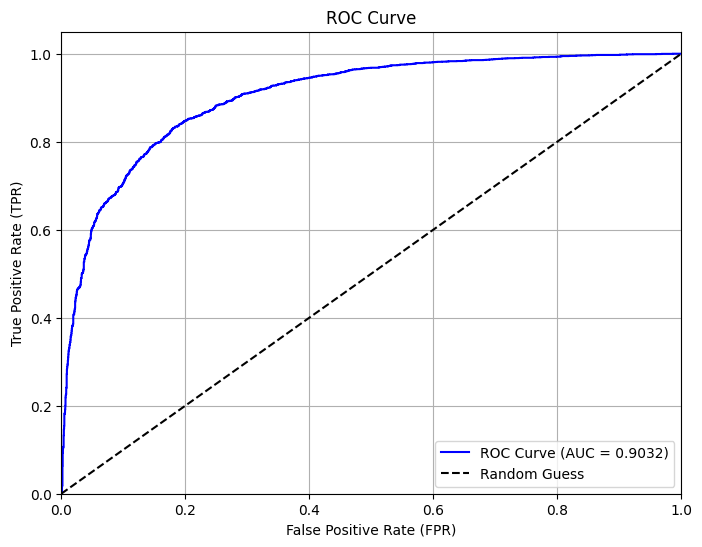

In [163]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    f1_score,
    classification_report,
    roc_curve  # For ROC curve
)
import matplotlib.pyplot as plt  # For plotting

# ----------------------------
# 4. Evaluate the Best Model
# ----------------------------
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation accuracy: {:.4f}".format(grid_search.best_score_))

# Use the best model to predict on the test set.
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_with_indicators)
y_pred_proba = best_model.predict_proba(X_test_with_indicators)[:, 1]  # Get probabilities for the positive class

# Calculate additional metrics
test_accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)

print("Test set accuracy: {:.4f}".format(test_accuracy))
print("Test set ROC AUC: {:.4f}".format(roc_auc))
print("Test set F1 score: {:.4f}".format(f1))

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ----------------------------
# 5. Plot the ROC Curve
# ----------------------------
# Compute FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")  # Diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Top 20 Aggregated Interaction Features by Summed Absolute Coefficient:
        feature_combination  aggregated_importance
7493          (V2116, wave)              24.396166
5193          (V2105, wave)              20.140459
3970          (V2101, wave)               7.773829
6830   (V2116, V2156, wave)               2.461744
5190    (V2105, race, wave)               2.324935
3307   (V2101, V2156, wave)               2.279117
6367          (V2108, wave)               2.173731
3967    (V2101, race, wave)               2.159150
4455   (V2105, V2153, wave)               1.918556
4530   (V2105, V2156, wave)               1.824391
7490    (V2116, race, wave)               1.810307
6755   (V2116, V2153, wave)               1.711437
24539   (V2196, race, wave)               1.522637
16331         (V2156, wave)               1.331389
14893         (V2153, wave)               1.322492
20254   (V2173, race, wave)               0.967445
5629   (V2108, V2153, wave)               0.899674
6717       

/tmp/ipykernel_2677733/2016154660.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


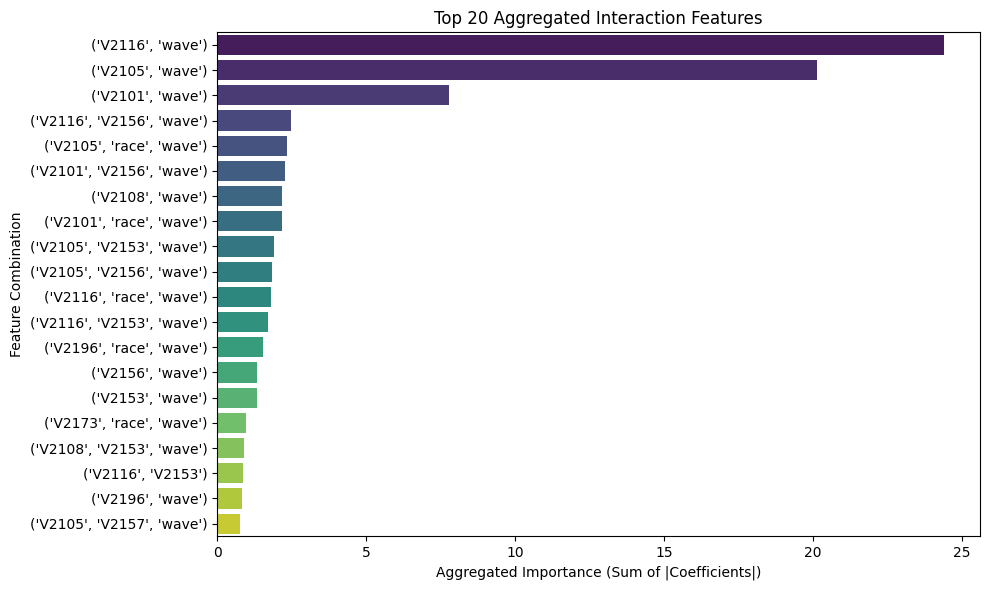

In [164]:
# -----------------------------
# Step 1: Retrieve One-Hot Encoded Feature Names
# -----------------------------
# Access the OneHotEncoder from your pipeline's preprocessor (assumed to be named 'cat')
preprocessor_in_model = best_model.named_steps['preprocessor']
ohe = preprocessor_in_model.named_transformers_['cat']
encoded_feature_names = ohe.get_feature_names_out(categorical_features)

# -----------------------------
# Step 2: Retrieve Interaction Feature Names
# -----------------------------
# Get the feature names after applying PolynomialFeatures (which created interaction terms)
interaction_transformer = best_model.named_steps['poly']  # Corrected step name here
interaction_feature_names = interaction_transformer.get_feature_names_out(encoded_feature_names)

# -----------------------------
# Step 3: Extract Classifier Coefficients
# -----------------------------
# For binary classification, the classifier’s coef_ is an array of shape (1, n_features)
coefficients = best_model.named_steps['classifier'].coef_[0]

# Build a DataFrame mapping each expanded feature (both main effects and interactions) to its coefficient
features_df = pd.DataFrame({
    'interaction_feature': interaction_feature_names,
    'coefficient': coefficients,
    'abs_coef': np.abs(coefficients)
})

# -----------------------------
# Step 4: Filter for Interaction Features Only
# -----------------------------
# With interaction_only=True, main effects do not contain a space, while interaction terms do.
interaction_df = features_df[features_df['interaction_feature'].str.contains(' ')].copy()

# -----------------------------
# Step 5: Aggregate to Original Feature Combinations
# -----------------------------
# Define a function to extract the original feature names from an interaction term.
def extract_original_features(interaction_term):
    # For example, "V13_A V2152_B" or "V13_A V2152_B V49_Low"
    parts = interaction_term.split(' ')
    # Extract the original feature name from each part (everything before the underscore)
    original_features = [part.split('_')[0] for part in parts]
    # Sort the features so order doesn't matter (e.g., ('V13', 'V2152') is the same as ('V2152', 'V13'))
    return tuple(sorted(original_features))

# Create a new column for the aggregated original feature combination
interaction_df['feature_combination'] = interaction_df['interaction_feature'].apply(extract_original_features)

# Group by the original feature combination and sum the absolute coefficient values as a measure of importance
agg_interactions = (
    interaction_df.groupby('feature_combination')['abs_coef']
    .sum()
    .reset_index()
    .rename(columns={'abs_coef': 'aggregated_importance'})
)

# Sort the aggregated interactions by importance in descending order
agg_interactions = agg_interactions.sort_values('aggregated_importance', ascending=False)

# -----------------------------
# Step 6: Display the Top 20 Aggregated Interaction Features
# -----------------------------
top20_agg_interactions = agg_interactions.head(20)
print("Top 20 Aggregated Interaction Features by Summed Absolute Coefficient:")
print(top20_agg_interactions)

# Optionally, plot the results.
plt.figure(figsize=(10, 6))
sns.barplot(
    x='aggregated_importance',
    y=top20_agg_interactions['feature_combination'].astype(str),
    data=top20_agg_interactions,
    palette='viridis'
)
plt.title("Top 20 Aggregated Interaction Features")
plt.xlabel("Aggregated Importance (Sum of |Coefficients|)")
plt.ylabel("Feature Combination")
plt.tight_layout()
plt.show()

## Random Forest Classifier

2025-02-10 17:25:23,728 - INFO - 
--- Random Forest (Revised) ---
2025-02-10 17:25:23,729 - INFO - Starting randomized search for Random Forest...


Fitting 5 folds for each of 30 candidates, totalling 150 fits


/storage/home/szn5432/work/vaping_project/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/storage/home/szn5432/work/vaping_project/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/storage/home/szn5432/work/vaping_project/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/storage/home/szn5432/work/vaping_project/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories wi

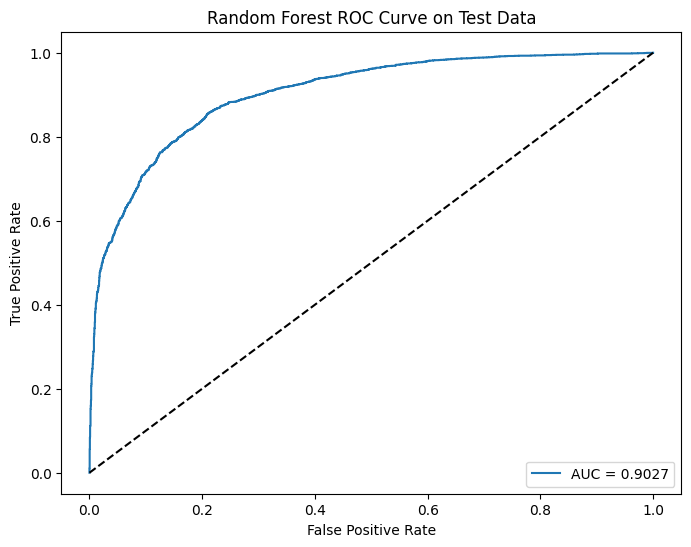

2025-02-10 17:59:17,940 - INFO - Script completed successfully.


In [10]:
# Define Random State for reproducibility
RANDOM_STATE = 42

# Use RepeatedStratifiedKFold for more robust validation
N_SPLITS_CV = 5
N_REPEATS = 1  # repeat the CV multiple times if desired
SCORING_METRIC = 'roc_auc'
VERBOSE = 1

logging.info("\n--- Random Forest (Revised) ---")

# Build pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))
])

# Parameter for RandomizedSearch
rf_param_dist = {
    'classifier__n_estimators': [100, 200, 500, 1000],
    'classifier__max_depth': [5, 10, 20, 50],
    'classifier__min_samples_split': [2, 5, 10, 20],
    'classifier__min_samples_leaf': [1, 2, 5, 10],
    'classifier__max_features': ['sqrt', 'log2', 0.3, 0.5, 0.7],  # Mix of float and string
    'classifier__bootstrap': [True, False],
    'classifier__class_weight': [None, 'balanced']
}

try:
    logging.info("Starting randomized search for Random Forest...")
    
    # Use RepeatedStratifiedKFold without shuffle
    cv_rf = RepeatedStratifiedKFold(
        n_splits=N_SPLITS_CV, 
        n_repeats=N_REPEATS, 
        random_state=RANDOM_STATE
    )
    
    # RandomizedSearchCV to cover more combinations within reasonable compute time
    rf_random_search = RandomizedSearchCV(
        estimator=rf_pipeline,
        param_distributions=rf_param_dist,
        n_iter=30,  # Increase or decrease based on resources
        cv=cv_rf,
        scoring=SCORING_METRIC,
        n_jobs=-1,  # Use all available cores
        random_state=RANDOM_STATE,
        verbose=VERBOSE
    )
    
    # Fit the RandomizedSearchCV
    rf_random_search.fit(X_train_with_indicators, y_train)

    logging.info(f"Best parameters (RF): {rf_random_search.best_params_}")
    logging.info(f"Best cross-validation {SCORING_METRIC}: {rf_random_search.best_score_:.4f}")
    
    # Extract the best estimator
    best_rf = rf_random_search.best_estimator_

except Exception as e:
    logging.error(f"An error occurred during Random Forest randomized search: {e}")
    raise

# Evaluate the best Random Forest
try:
    best_rf.fit(X_train_with_indicators, y_train)
    y_pred_rf = best_rf.predict(X_test_with_indicators)
    y_pred_proba_rf = best_rf.predict_proba(X_test_with_indicators)[:, 1]

    logging.info("=== Best Random Forest Evaluation ===")
    logging.info("Confusion Matrix:\n" + str(confusion_matrix(y_test, y_pred_rf)))
    logging.info("\nClassification Report:\n" + str(classification_report(y_test, y_pred_rf)))
    logging.info(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

    # Plot ROC
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_rf, tpr_rf, label=f'AUC = {roc_auc_score(y_test, y_pred_proba_rf):.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Random Forest ROC Curve on Test Data')
    plt.legend(loc='lower right')
    plt.show()

except Exception as e:
    logging.error(f"An error occurred during Random Forest training/evaluation: {e}")
    raise

logging.info("Script completed successfully.")

In [11]:
# Define the model file path
model_filename = os.path.expanduser('~/work/vaping_project_data/best_rf_model.joblib')

# Save the trained model
joblib.dump(best_rf, model_filename)
logging.info(f"Model saved to {model_filename}")

2025-02-10 18:02:26,360 - INFO - Model saved to /storage/home/szn5432/work/vaping_project_data/best_rf_model.joblib


In [7]:
# Load the model from the specified path
logging.info("Loading the model...")
best_rf = joblib.load(os.path.expanduser('~/work/vaping_project_data/best_rf_model.joblib'))
logging.info("Model loaded successfull")

2025-02-10 19:39:18,540 - INFO - Loading the model...
2025-02-10 19:39:19,324 - INFO - Model loaded successfull


2025-02-10 19:23:27,214 - INFO - Starting feature importance analysis...
2025-02-10 19:23:27,345 - INFO - Shape of X_train_with_indicators: (21864, 100)
2025-02-10 19:23:27,346 - INFO - Length of feature_importance: 305
2025-02-10 19:23:27,346 - INFO - Number of feature names: 305
2025-02-10 19:23:27,347 - INFO - Feature names: ['cat__V2157_1.0' 'cat__V2157_nan' 'cat__V49_1.0' 'cat__V49_2.0'
 'cat__V49_3.0' 'cat__V49_nan' 'cat__V2134_2.0' 'cat__V2134_3.0'
 'cat__V2134_4.0' 'cat__V2134_5.0' 'cat__V2134_6.0' 'cat__V2134_7.0'
 'cat__V2134_nan' 'cat__V2153_2.0' 'cat__V2153_3.0' 'cat__V2153_4.0'
 'cat__V2153_nan' 'cat__V2116_2.0' 'cat__V2116_3.0' 'cat__V2116_4.0'
 'cat__V2116_5.0' 'cat__V2116_6.0' 'cat__V2116_7.0' 'cat__V2116_nan'
 'cat__V13_2.0' 'cat__V13_3.0' 'cat__V13_4.0' 'cat__V2140_2.0'
 'cat__V2140_3.0' 'cat__V2140_4.0' 'cat__V2140_5.0' 'cat__V2140_6.0'
 'cat__V2140_7.0' 'cat__V2140_nan' 'cat__V2101_2.0' 'cat__V2101_3.0'
 'cat__V2101_4.0' 'cat__V2101_5.0' 'cat__V2101_nan' 'cat__V2191

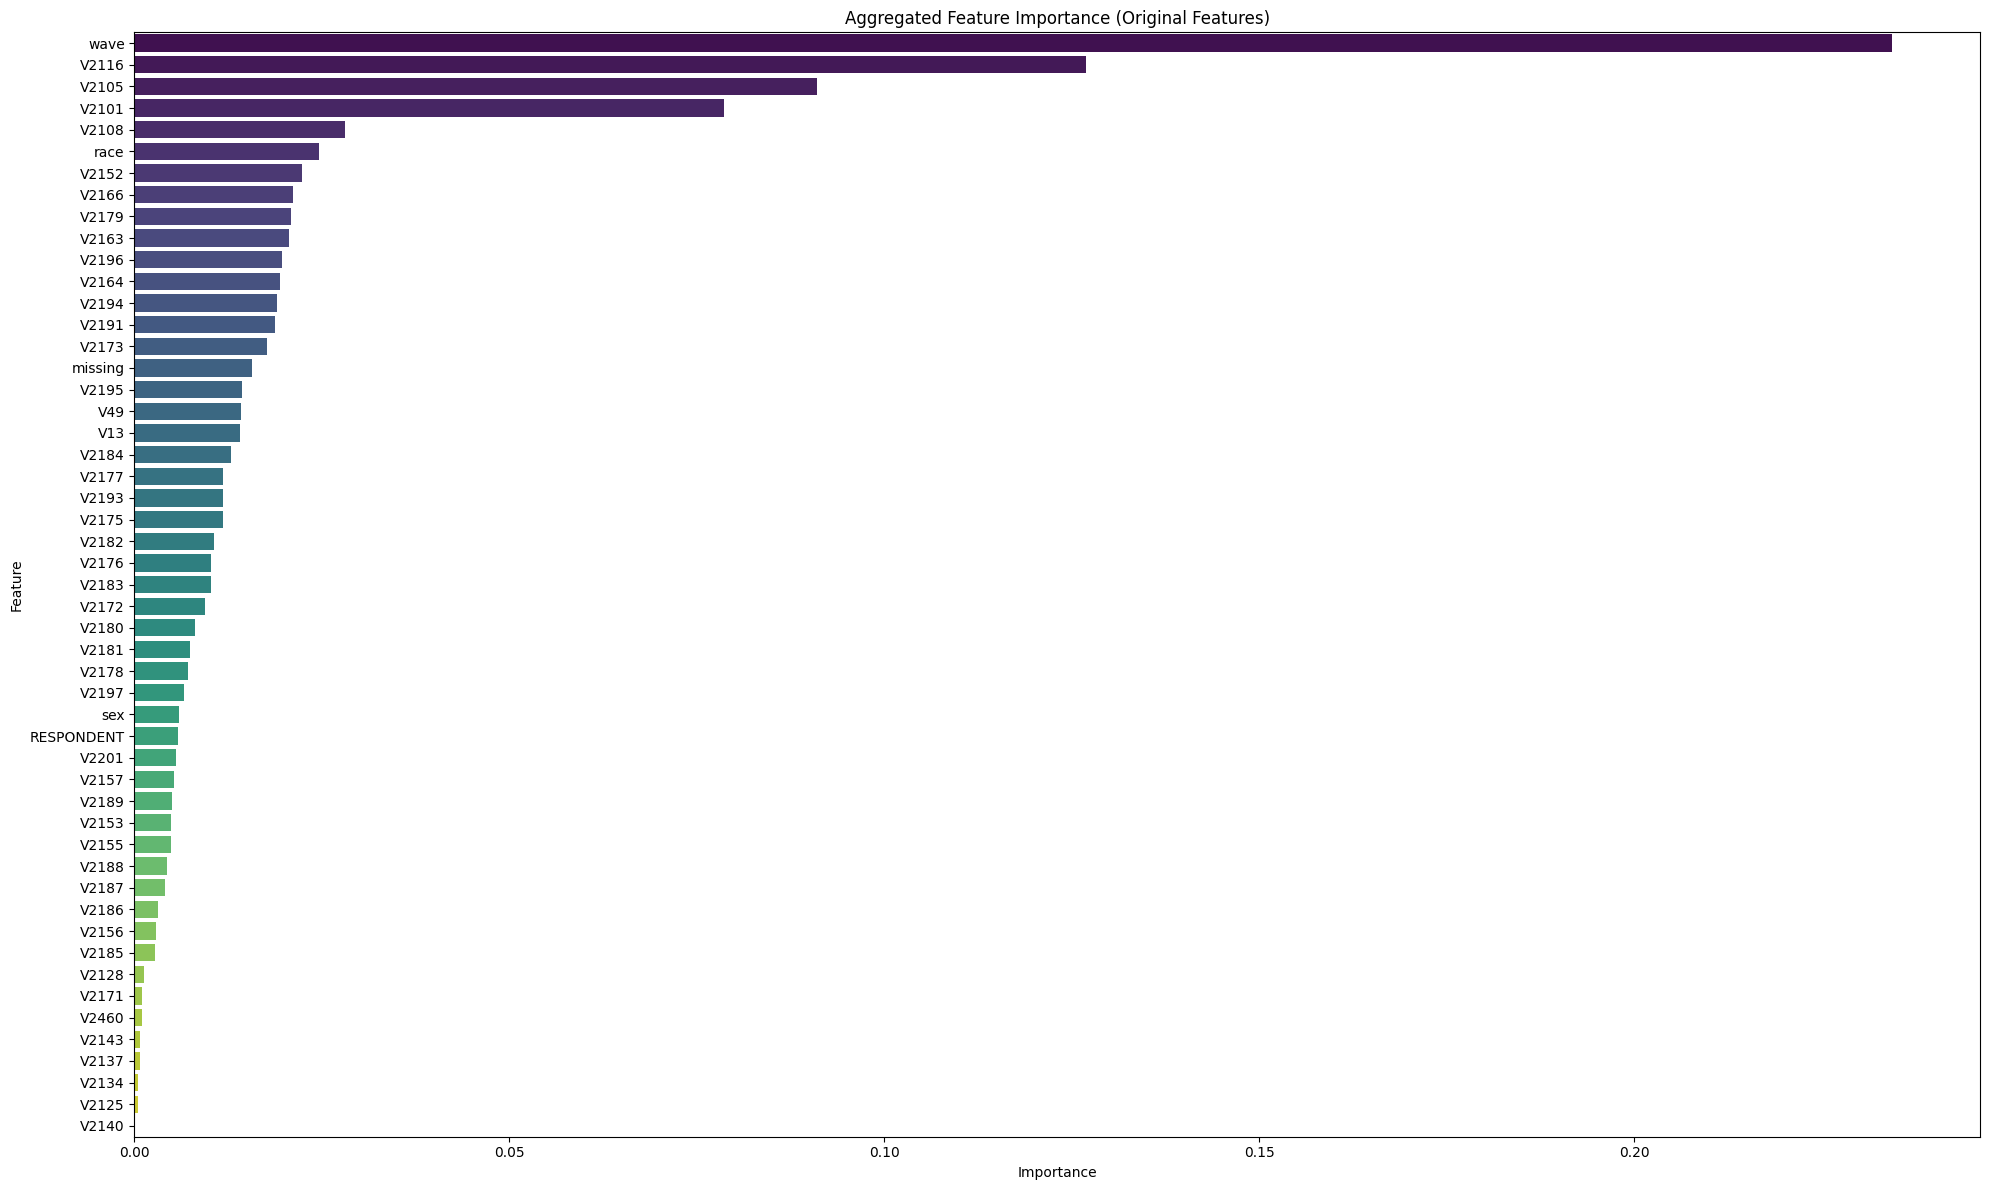

Top 20 Feature Importances:
    Feature  Importance
39     wave    0.234382
4     V2116    0.126868
12    V2105    0.091049
7     V2101    0.078581
40    V2108    0.028070
37     race    0.024610
9     V2152    0.022376
22    V2166    0.021140
35    V2179    0.020943
49    V2163    0.020579
10    V2196    0.019741
41    V2164    0.019386
44    V2194    0.018974
8     V2191    0.018792
17    V2173    0.017679
50  missing    0.015665
38    V2195    0.014381
1       V49    0.014271
5       V13    0.014086
32    V2184    0.012926


In [13]:
try:
    logging.info("Starting feature importance analysis...")

    # Access the RandomForestClassifier from the pipeline
    rf_model = best_rf.named_steps['classifier']

    # Get feature importances
    feature_importance = rf_model.feature_importances_

    # Access the preprocessor step
    preprocessor = best_rf.named_steps['preprocessor']

    # Get transformed feature names
    if hasattr(preprocessor, 'get_feature_names_out'):
        feature_names = preprocessor.get_feature_names_out()
    else:
        # Fallback: Generate feature names if get_feature_names_out is not available
        X_train_transformed = preprocessor.transform(X_train_with_indicators)
        feature_names = [f"Feature_{idx}" for idx in range(X_train_transformed.shape[1])]

    # Debugging: Print shapes and lengths
    logging.info(f"Shape of X_train_with_indicators: {X_train_with_indicators.shape}")
    logging.info(f"Length of feature_importance: {len(feature_importance)}")
    logging.info(f"Number of feature names: {len(feature_names)}")
    logging.info(f"Feature names: {feature_names}")

    # Check if lengths match
    if len(feature_names) != len(feature_importance):
        raise ValueError(
            f"Mismatch in lengths: feature_names ({len(feature_names)}) != feature_importance ({len(feature_importance)})"
        )

    # Create a DataFrame for visualization
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    })

    # Aggregate importances for original features
    original_feature_importance = {}

    for feature, importance in zip(feature_names, feature_importance):
        # Extract the original feature name (e.g., 'cat__V13_2' -> 'V13')
        original_feature = feature.split('__')[1].split('_')[0]

        # Sum importances for each original feature
        if original_feature in original_feature_importance:
            original_feature_importance[original_feature] += importance
        else:
            original_feature_importance[original_feature] = importance

    # Create a DataFrame for aggregated importances
    aggregated_importance_df = pd.DataFrame({
        'Feature': list(original_feature_importance.keys()),
        'Importance': list(original_feature_importance.values())
    })

    # Sort features by importance
    aggregated_importance_df = aggregated_importance_df.sort_values(by='Importance', ascending=False)

    # Plot aggregated feature importance
    plt.figure(figsize=(20, 12))
    sns.barplot(x='Importance', y='Feature', data=aggregated_importance_df, palette='viridis')
    plt.title('Aggregated Feature Importance (Original Features)')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

    # Display top 20 feature importances
    top_20_features = aggregated_importance_df.head(20)
    print("Top 20 Feature Importances:")
    print(top_20_features)

except Exception as e:
    logging.error(f"An error occurred during feature importance analysis: {e}")
    raise

In [8]:
# best_rf is the best estimator from your RandomizedSearchCV
tree_model = best_rf.named_steps['classifier']

# Transform the entire training set
X_train_processed_full = best_rf.named_steps['preprocessor'].transform(X_train_with_indicators)
X_train_processed_full = X_train_processed_full.toarray()

# Convert to DataFrame for easier sampling & feature naming
feature_names = best_rf.named_steps['preprocessor'].get_feature_names_out()
X_train_processed_df = pd.DataFrame(X_train_processed_full, columns=feature_names)

# Randomly sample 5000 rows from the processed data
X_background = X_train_processed_df.sample(n=1000, random_state=42)

# Create the explainer on just the 5000 background points
explainer = shap.TreeExplainer(tree_model, data=X_background)

# If you also want to compute shap values for the same subset (typical):
shap_values = explainer.shap_values(X_background)
shap_values_class1 = shap_values[1]



100%|===================| 1998/2000 [11:59<00:00]        

In [24]:
def get_original_feature_name(encoded_name):
    """
    Example parser that assumes you have names like 'cat__Gender_Male'
    or 'cat__MaritalStatus_Single'.

    We split on '__' to separate the transformer name from the remainder.
    Then we split the remainder on '_' and assume the first chunk is the original column
    (e.g., 'Gender' or 'MaritalStatus').
    """
    parts = encoded_name.split("__", maxsplit=1)
    if len(parts) == 2:
        # e.g. 'cat', 'Gender_Male'
        transformer_name, remainder = parts
        # Now parse the remainder by '_' to get the original column
        remainder_parts = remainder.split("_", maxsplit=1)
        original_col = remainder_parts[0]  # e.g. 'Gender'
        return original_col
    else:
        # If there's no double underscore or unexpected format,
        # just return the full encoded_name
        return encoded_name


Top 20 Original Features by Aggregate SHAP Value:
wave       0.325421
V2116      0.051176
V2105      0.050185
V2101      0.025163
race       0.019770
V2108      0.009055
V2196      0.007378
V2194      0.006036
V2179      0.005975
V2163      0.005953
V2191      0.005802
V2166      0.005741
V2152      0.005696
V2164      0.005248
sex        0.004852
missing    0.004749
V2184      0.004626
V2173      0.004626
V13        0.004414
V2195      0.004110
dtype: float64


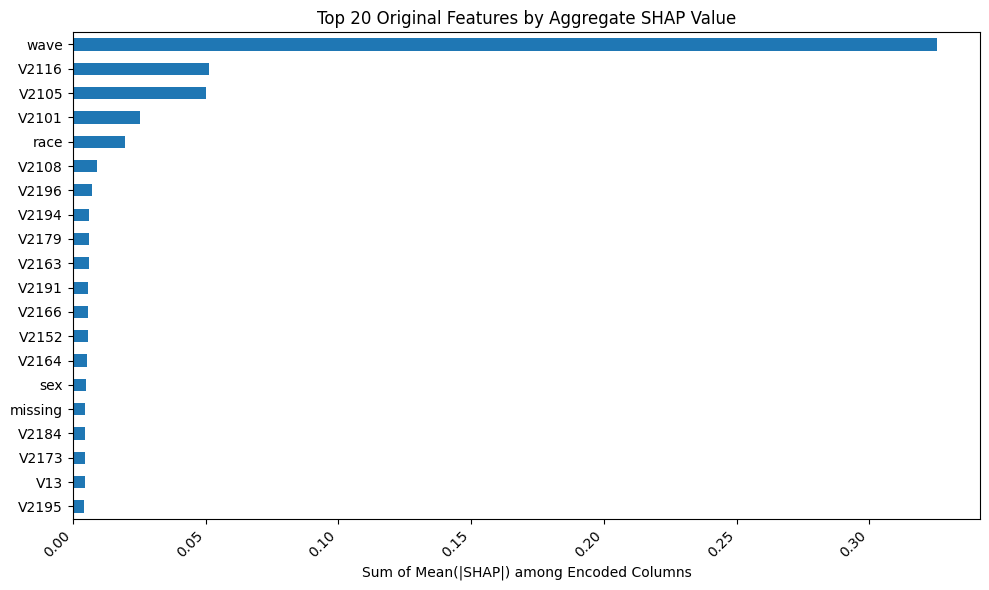

In [30]:
# (n_samples=1000, n_features=305, n_classes=2)
shap_values_class1 = shap_values[:, :, 1]  # (1000, 305)
mean_abs_shap = np.abs(shap_values_class1).mean(axis=0)  # (305,)

shap_series = pd.Series(mean_abs_shap, index=feature_names)
# Map encoded => original
original_names = shap_series.index.map(get_original_feature_name)
# Group by the parsed name and sum the SHAP contributions
grouped_shap = shap_series.groupby(original_names).sum()  # or mean()

# Sort descending
grouped_shap.sort_values(ascending=False, inplace=True)

# Get the top 20 original features
top_20_original_features = grouped_shap.head(20)

print("Top 20 Original Features by Aggregate SHAP Value:")
print(top_20_original_features)

plt.figure(figsize=(10, 6))
top_20_original_features.plot(kind='barh')
plt.title("Top 20 Original Features by Aggregate SHAP Value")
plt.xlabel("Sum of Mean(|SHAP|) among Encoded Columns")
plt.xticks(rotation=45, ha="right")
plt.gca().invert_yaxis()  # This line ensures the bars are in descending order
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

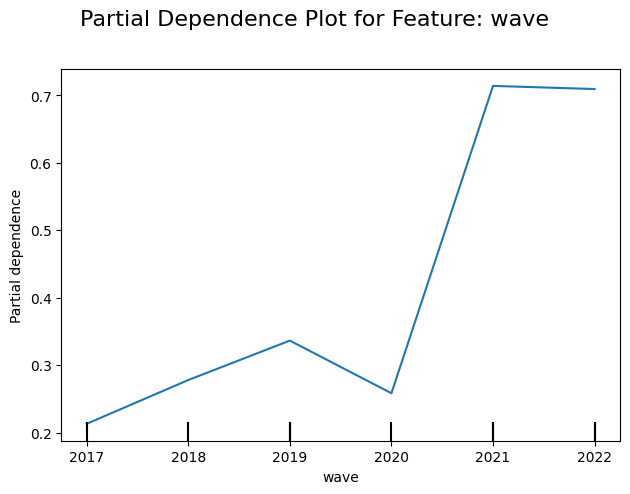

<Figure size 1200x800 with 0 Axes>

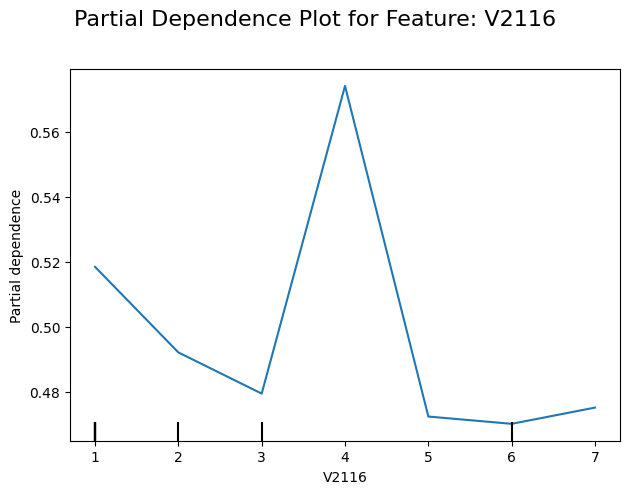

<Figure size 1200x800 with 0 Axes>

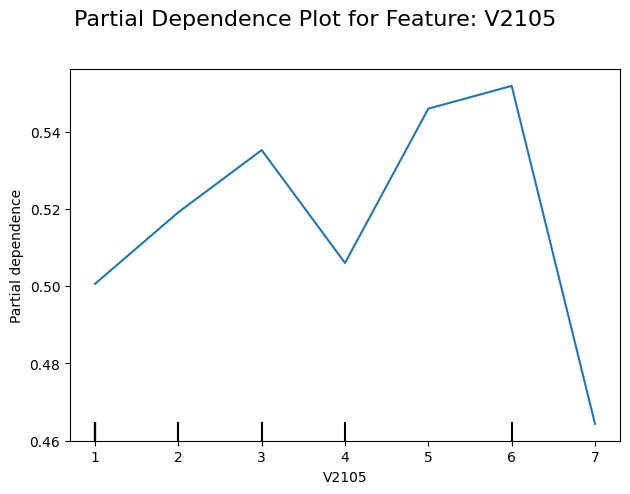

<Figure size 1200x800 with 0 Axes>

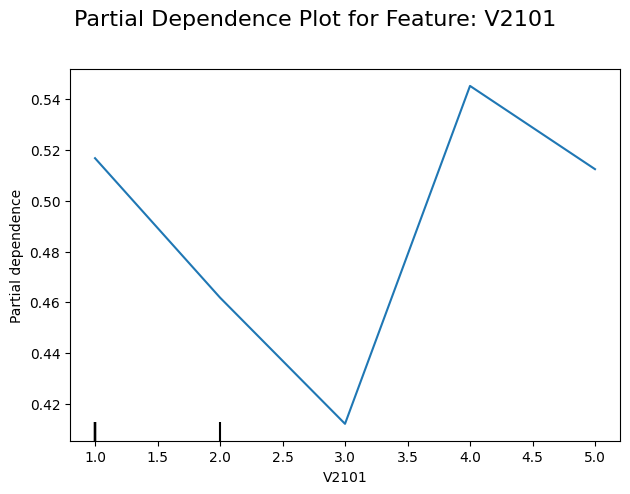

<Figure size 1200x800 with 0 Axes>

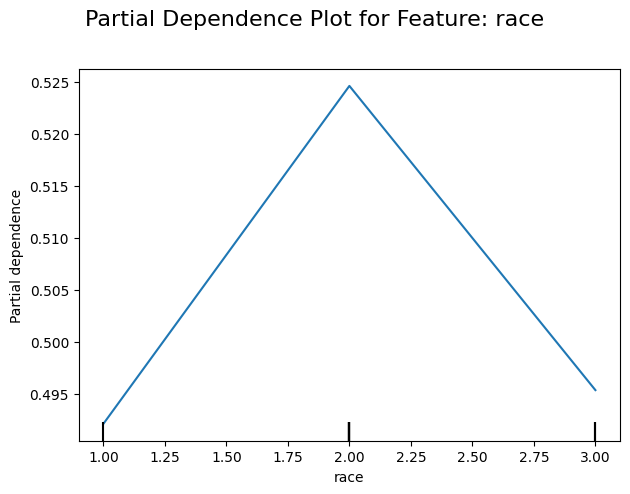

<Figure size 1200x800 with 0 Axes>

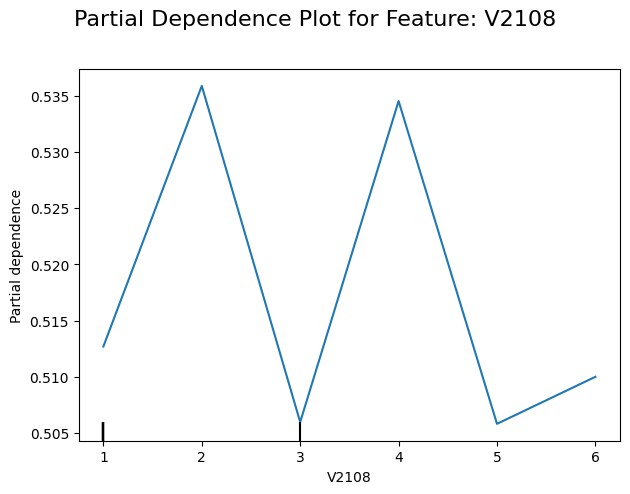

<Figure size 1200x800 with 0 Axes>

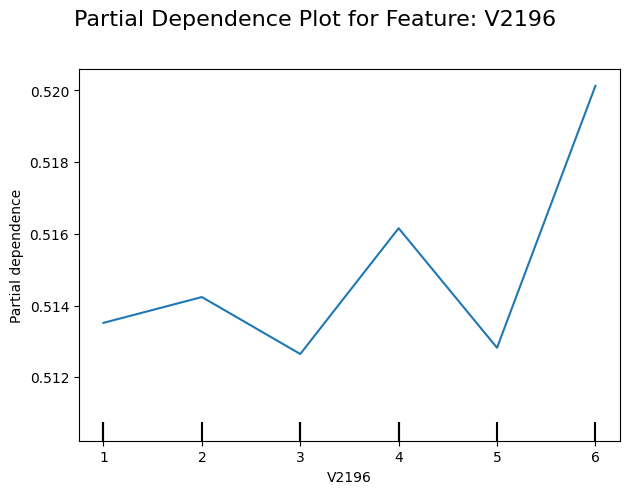

<Figure size 1200x800 with 0 Axes>

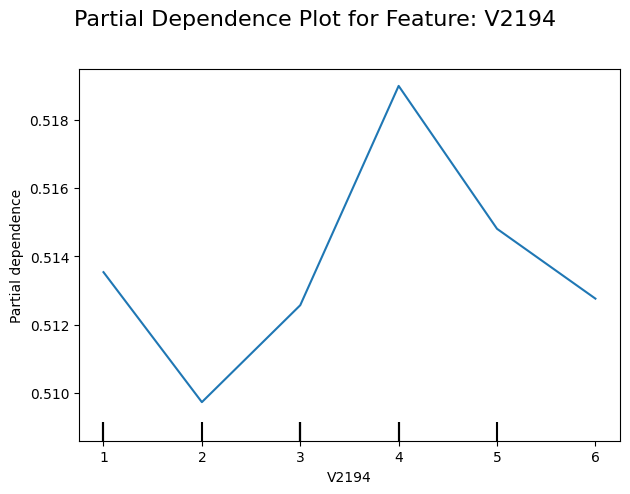

<Figure size 1200x800 with 0 Axes>

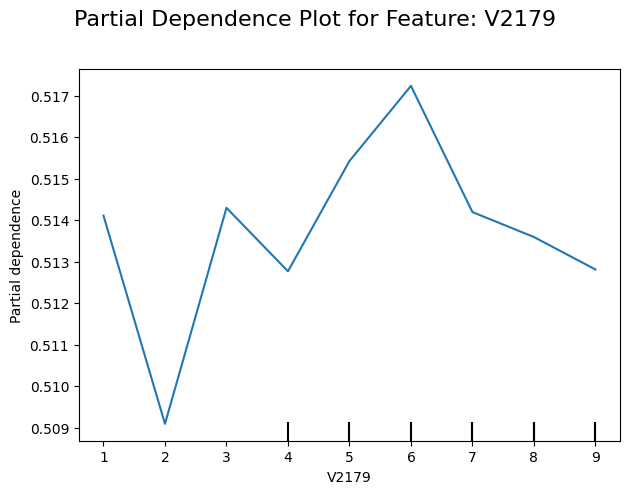

<Figure size 1200x800 with 0 Axes>

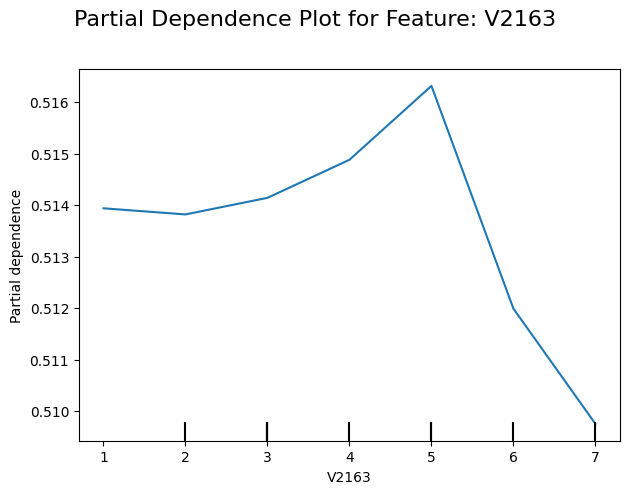

In [35]:
# PDP Plot

# top_20_original_features is a Series:
#   index = original feature names (e.g. "Gender", "Age", "Income")
#   values = aggregated SHAP values

top_10_features = top_20_original_features.index[:10].tolist()  # list of strings

for feat_name in top_10_features:
    # Create a new figure for each plot with large size
    plt.figure(figsize=(12, 8))
    
    # Create single PDP plot
    # NOTE: This requires scikit-learn >= 1.2 to pass raw string names 
    # if you have a pipeline + ColumnTransformer.
    pdp = PartialDependenceDisplay.from_estimator(
        estimator=best_rf,
        X=X_train_with_indicators,
        features=[feat_name],  # pass the original feature name
        feature_names=X_train_with_indicators.columns,  
        random_state=42
    )
    
    # Add title for each plot
    plt.suptitle(
        f'Partial Dependence Plot for Feature: {feat_name}',
        fontsize=16,
        y=1.02
    )

    # Adjust layout
    plt.tight_layout()
    
    # Show each plot
    plt.show()


## Gradient Boosting Trees

2025-02-10 20:31:02,551 - INFO - 
--- Gradient Boosting (Revised) ---
2025-02-10 20:31:02,553 - INFO - Starting randomized search for Gradient Boosting...


Fitting 5 folds for each of 30 candidates, totalling 150 fits


/storage/home/szn5432/work/vaping_project/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/storage/home/szn5432/work/vaping_project/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/storage/home/szn5432/work/vaping_project/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/storage/home/szn5432/work/vaping_project/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories wi

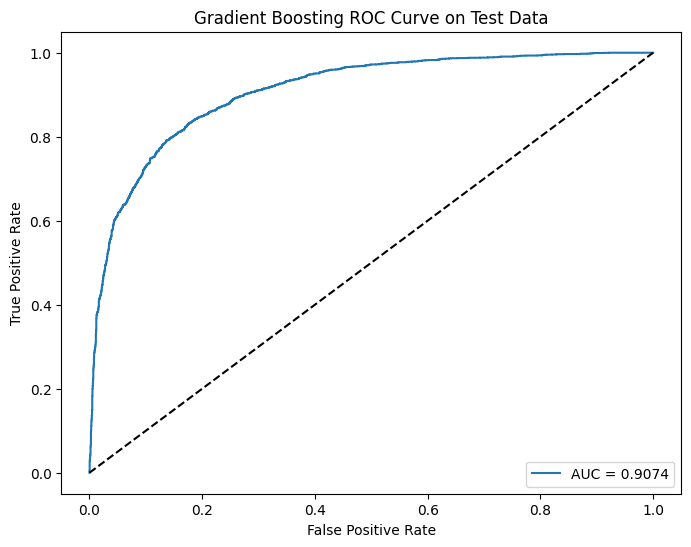

2025-02-10 20:36:09,248 - INFO - Script completed successfully.


In [36]:
import logging
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Random State for reproducibility
RANDOM_STATE = 42

# Use RepeatedStratifiedKFold for more robust validation
N_SPLITS_CV = 5
N_REPEATS = 1  # Repeat the CV multiple times if desired
SCORING_METRIC = 'roc_auc'
VERBOSE = 1

logging.info("\n--- Gradient Boosting (Revised) ---")

# Build pipeline
gbc_pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('classifier', GradientBoostingClassifier(random_state=RANDOM_STATE))
])

# Expanded parameter distributions for RandomizedSearch
gbc_param_dist = {
    'classifier__n_estimators': [100, 300, 500, 1000],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 10, 20],
    'classifier__subsample': [0.8, 0.9, 1.0],  # Controls sample ratio per tree
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 5],
    'classifier__max_features': ['sqrt', 'log2', None]
}

try:
    logging.info("Starting randomized search for Gradient Boosting...")

    # Use RepeatedStratifiedKFold without shuffle
    cv_gbc = RepeatedStratifiedKFold(
        n_splits=N_SPLITS_CV, 
        n_repeats=N_REPEATS, 
        random_state=RANDOM_STATE
    )

    # RandomizedSearchCV to cover more combinations within reasonable compute time
    gbc_random_search = RandomizedSearchCV(
        estimator=gbc_pipeline,
        param_distributions=gbc_param_dist,
        n_iter=30,  # Increase or decrease based on resources
        cv=cv_gbc,
        scoring=SCORING_METRIC,
        n_jobs=24,  # Use all available cores
        random_state=RANDOM_STATE,
        verbose=VERBOSE
    )

    # Fit the RandomizedSearchCV
    gbc_random_search.fit(X_train_with_indicators, y_train)

    logging.info(f"Best parameters (GBC): {gbc_random_search.best_params_}")
    logging.info(f"Best cross-validation {SCORING_METRIC}: {gbc_random_search.best_score_:.4f}")

    # Extract the best estimator
    best_gbc = gbc_random_search.best_estimator_

except Exception as e:
    logging.error(f"An error occurred during Gradient Boosting randomized search: {e}")
    raise

# Evaluate the best Gradient Boosting model
try:
    best_gbc.fit(X_train_with_indicators, y_train)
    y_pred_gbc = best_gbc.predict(X_test_with_indicators)
    y_pred_proba_gbc = best_gbc.predict_proba(X_test_with_indicators)[:, 1]

    logging.info("=== Best Gradient Boosting Evaluation ===")
    logging.info("Confusion Matrix:\n" + str(confusion_matrix(y_test, y_pred_gbc)))
    logging.info("\nClassification Report:\n" + str(classification_report(y_test, y_pred_gbc)))
    logging.info(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_gbc):.4f}")

    # Plot ROC Curve
    fpr_gbc, tpr_gbc, _ = roc_curve(y_test, y_pred_proba_gbc)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_gbc, tpr_gbc, label=f'AUC = {roc_auc_score(y_test, y_pred_proba_gbc):.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Gradient Boosting ROC Curve on Test Data')
    plt.legend(loc='lower right')
    plt.show()

except Exception as e:
    logging.error(f"An error occurred during Gradient Boosting training/evaluation: {e}")
    raise

logging.info("Script completed successfully.")

In [37]:
# Define the model file path
model_filename = os.path.expanduser('~/work/vaping_project_data/best_gbt_model.joblib')

# Save the trained model
joblib.dump(best_gbc, model_filename)
logging.info(f"Model saved to {model_filename}")

2025-02-10 21:40:00,638 - INFO - Model saved to /storage/home/szn5432/work/vaping_project_data/best_gbt_model.joblib


In [9]:
# Load the model (when needed)
file_path = os.path.expanduser('~/work/vaping_project_data/best_gbt_model.joblib')
loaded_gbt = joblib.load(file_path)
print("Model loaded successfully.")

Model loaded successfully.


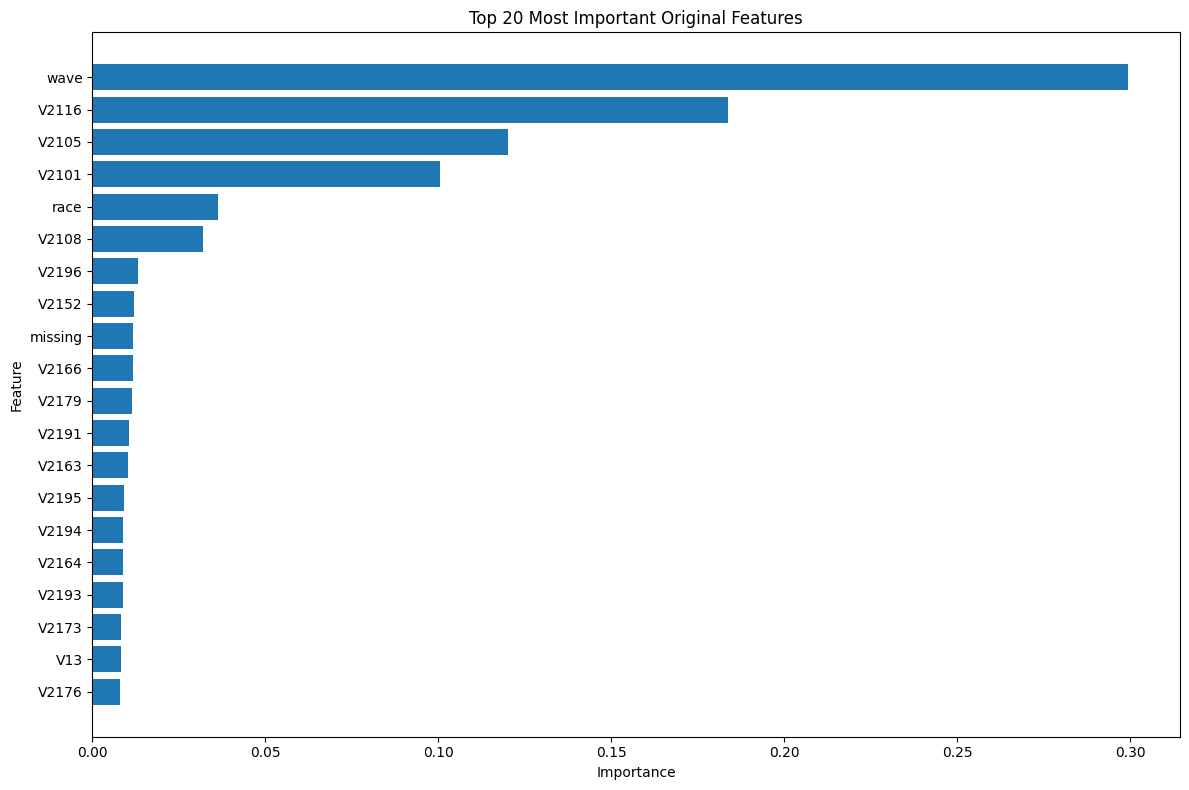


Feature Importance Rankings:
       Feature  Importance
24        wave    0.299466
19       V2116    0.183875
45       V2105    0.120230
8        V2101    0.100363
0         race    0.036302
20       V2108    0.032018
18       V2196    0.013162
34       V2152    0.011947
40     missing    0.011744
41       V2166    0.011731
22       V2179    0.011347
14       V2191    0.010678
6        V2163    0.010367
17       V2195    0.009103
47       V2194    0.008948
29       V2164    0.008871
23       V2193    0.008761
39       V2173    0.008322
2          V13    0.008152
7        V2176    0.007887
33       V2175    0.007244
16       V2197    0.007152
48       V2177    0.007048
46       V2178    0.005036
32         V49    0.004780
9        V2184    0.004648
30       V2201    0.004175
50       V2182    0.003813
5        V2172    0.003562
3        V2183    0.003512
21       V2181    0.003473
27       V2180    0.003470
26       V2153    0.003397
42         sex    0.002664
11       V2128    0.00212

In [39]:
# Get the Gradient Boosting classifier and feature importances
gbt_classifier = loaded_gbt.named_steps['classifier']
importances = gbt_classifier.feature_importances_

# Fit the preprocessor (if needed)
loaded_gbt.fit(X_train_with_indicators, y_train)

# Get the OneHotEncoder from the pipeline
ohe = loaded_gbt.named_steps['preprocessor'].named_transformers_['cat']

# Get all encoded feature names
encoded_feature_names = ohe.get_feature_names_out()

# Extract original feature names from encoded features
original_features = list(set([feat.split('_')[0] for feat in encoded_feature_names]))

# Create a dictionary to store original feature importances
original_feature_importance = {}

# Sum the importances of all encoded features from this original feature
for feature in original_features:
    encoded_features_mask = [str(name).startswith(feature + '_') for name in encoded_feature_names]
    importance = importances[encoded_features_mask].sum()
    original_feature_importance[feature] = importance

# Convert to DataFrame and sort by ascending order
feature_importance_df = pd.DataFrame({
    'Feature': original_feature_importance.keys(),
    'Importance': original_feature_importance.values()
})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=True)

# Take top 20 and plot
top_20 = feature_importance_df.tail(20)  # Use tail to get highest values

plt.figure(figsize=(12, 8))
plt.barh(y=top_20['Feature'], width=top_20['Importance'])
plt.title('Top 20 Most Important Original Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Print the DataFrame (in descending order for readability)
print("\nFeature Importance Rankings:")
print(feature_importance_df.sort_values('Importance', ascending=False))

Top 10 original features: ['wave', 'V2116', 'V2105', 'V2101', 'race', 'V2108', 'V2196', 'V2152', 'missing', 'V2166', 'V2179', 'V2191', 'V2163']
Filtered features (excluding 'missing_'):  ['wave', 'V2116', 'V2105', 'V2101', 'race', 'V2108', 'V2196', 'V2152', 'V2166', 'V2179', 'V2191', 'V2163']


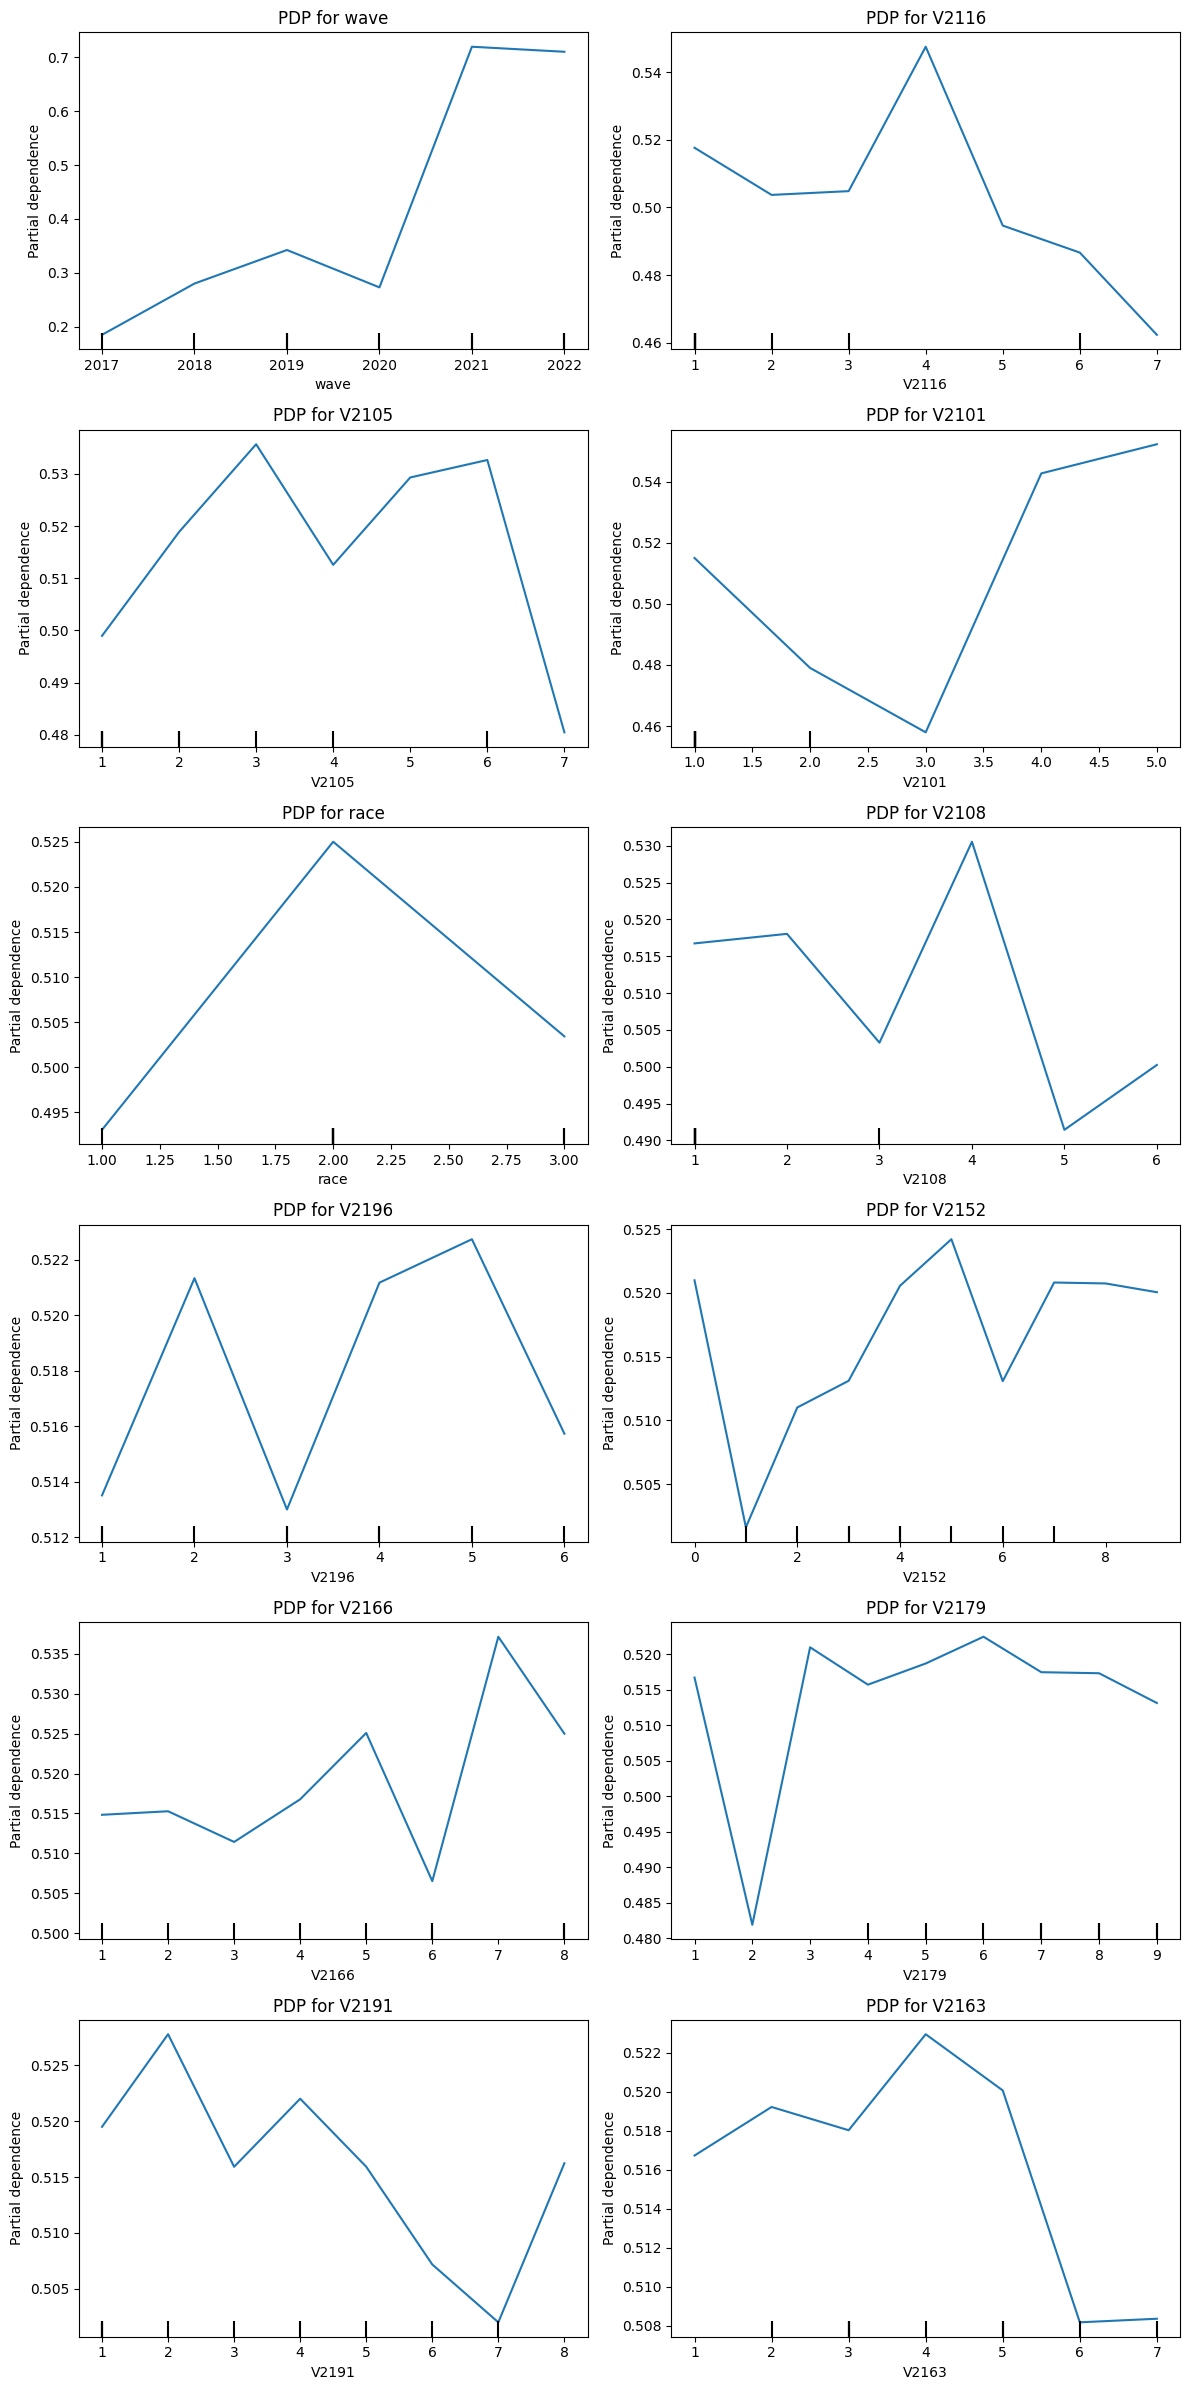

In [40]:
# 1) Sort by descending importance and take top 10.
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
top_10_features = feature_importance_df['Feature'].head(13).tolist()

# 2) Exclude features that start with "missing_" 
#    or that don’t actually exist in X_train_with_indicators.
filtered_features = [
    f for f in top_10_features 
    if not f.startswith('missing_') and f in X_train_with_indicators.columns
]

print("Top 10 original features:", top_10_features)
print("Filtered features (excluding 'missing_'): ", filtered_features)

# 3) Plot PDPs for the filtered features
n_features = len(filtered_features)
n_rows = (n_features + 1) // 2  # so we can arrange them in a grid
n_cols = 2
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 4*n_rows), squeeze=False)
axes = axes.flatten()

for i, feat in enumerate(filtered_features):
    ax = axes[i]
    PartialDependenceDisplay.from_estimator(
        estimator=loaded_gbt,
        X=X_train_with_indicators,
        features=[feat],
        feature_names=X_train_with_indicators.columns,
        kind='average',  # or 'both' if you want ICE lines
        ax=ax
    )
    ax.set_title(f"PDP for {feat}")

# If there are unused subplots, hide them
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [45]:
X_train_transformed = preprocessor.transform(X_train_with_indicators)
print("Shape of X_train_transformed:", X_train_transformed.shape)
print("Dtypes (if it is a NumPy array):", X_train_transformed.dtype)

# If X_train_transformed is a Pandas DataFrame:
if hasattr(X_train_transformed, 'dtypes'):
    print(X_train_transformed.dtypes)

X_train_with_indicators.info()  # or X_train_with_indicators.isna().sum() if DataFrame


Shape of X_train_transformed: (21864, 305)
Dtypes (if it is a NumPy array): float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21864 entries, 0 to 21863
Data columns (total 100 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   V2157                   21666 non-null  float64
 1   V49                     21703 non-null  float64
 2   V2134                   21663 non-null  float64
 3   V2153                   21668 non-null  float64
 4   V2116                   21391 non-null  float64
 5   V13                     21864 non-null  float64
 6   V2140                   21730 non-null  float64
 7   V2101                   21653 non-null  float64
 8   V2191                   21003 non-null  float64
 9   V2152                   21806 non-null  float64
 10  V2196                   20843 non-null  float64
 11  V2181                   20257 non-null  float64
 12  V2105                   21179 non-null  float64
 13  V2171 

In [10]:
##### SHAP Feature Importance ####

# Extract the GradientBoostingClassifier
gbt_models = loaded_gbt.named_steps['classifier']
# Get preprocessed features
X_preprocessed = loaded_gbt.named_steps['preprocessor'].transform(X_test_with_indicators)
# Convert the Sparse Matrix to Dense
X_preprocessed_dense = X_preprocessed.toarray()
# Create SHAP explainer
explainer = shap.TreeExplainer(gbt_models)
# Calculate SHAP values
shap_values = explainer.shap_values(X_preprocessed_dense)
# Get feature names after preprocessing
feature_names = loaded_gbt.named_steps['preprocessor'].get_feature_names_out()

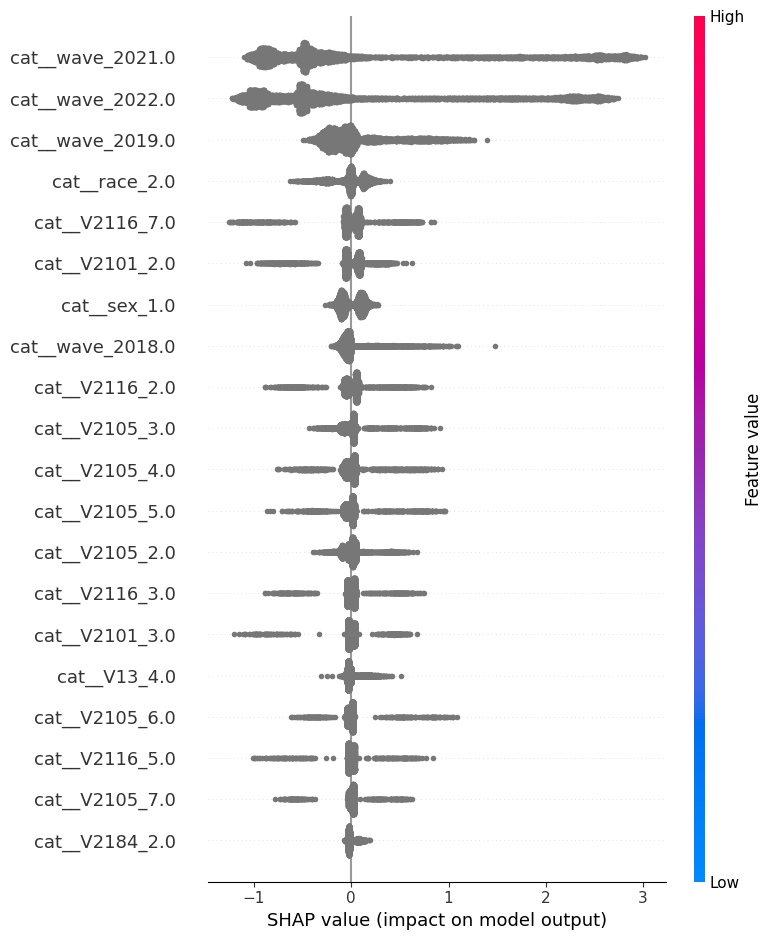

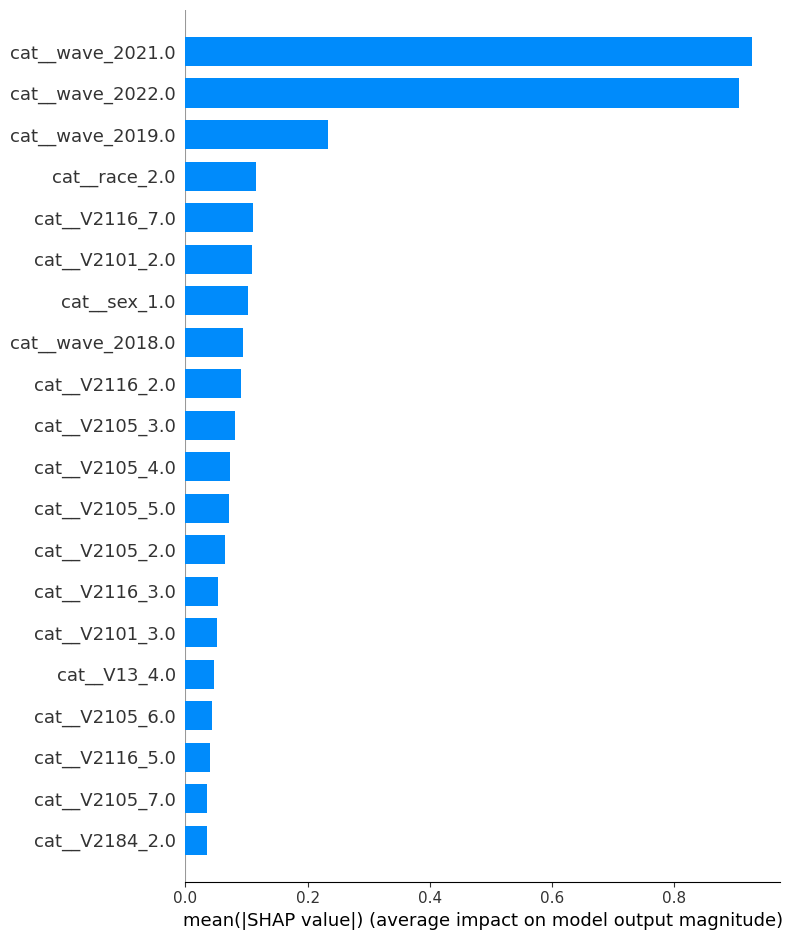

In [11]:
# Create visualizations
# Summary plot
shap.summary_plot(shap_values, X_preprocessed, feature_names=feature_names)
# Bar plot of feature importance
shap.summary_plot(shap_values, X_preprocessed, feature_names=feature_names, plot_type='bar')

In [33]:
# 1. Aggregate SHAP values by base feature
feature_importances = {}
for i, col in enumerate(feature_names):
    base_feature = '_'.join(col.split('_')[:-1])  # Extract base feature name
    if base_feature not in feature_importances:
        feature_importances[base_feature] = []
    feature_importances[base_feature].extend(np.abs(shap_values[:, i]))

# 2. Calculate mean absolute SHAP value for each base feature
aggregated_importances = {
    feature: np.mean(values) for feature, values in feature_importances.items()
}

# 3. Sort features by importance
sorted_importances = sorted(
    aggregated_importances.items(), key=lambda item: item[1], reverse=True
)

# 4. Create a DataFrame for plotting
importance_df = pd.DataFrame(sorted_importances, columns=['Feature', 'Importance'])

# Filter to show only the top 20 features
top_20_importance_df = importance_df.head(20)

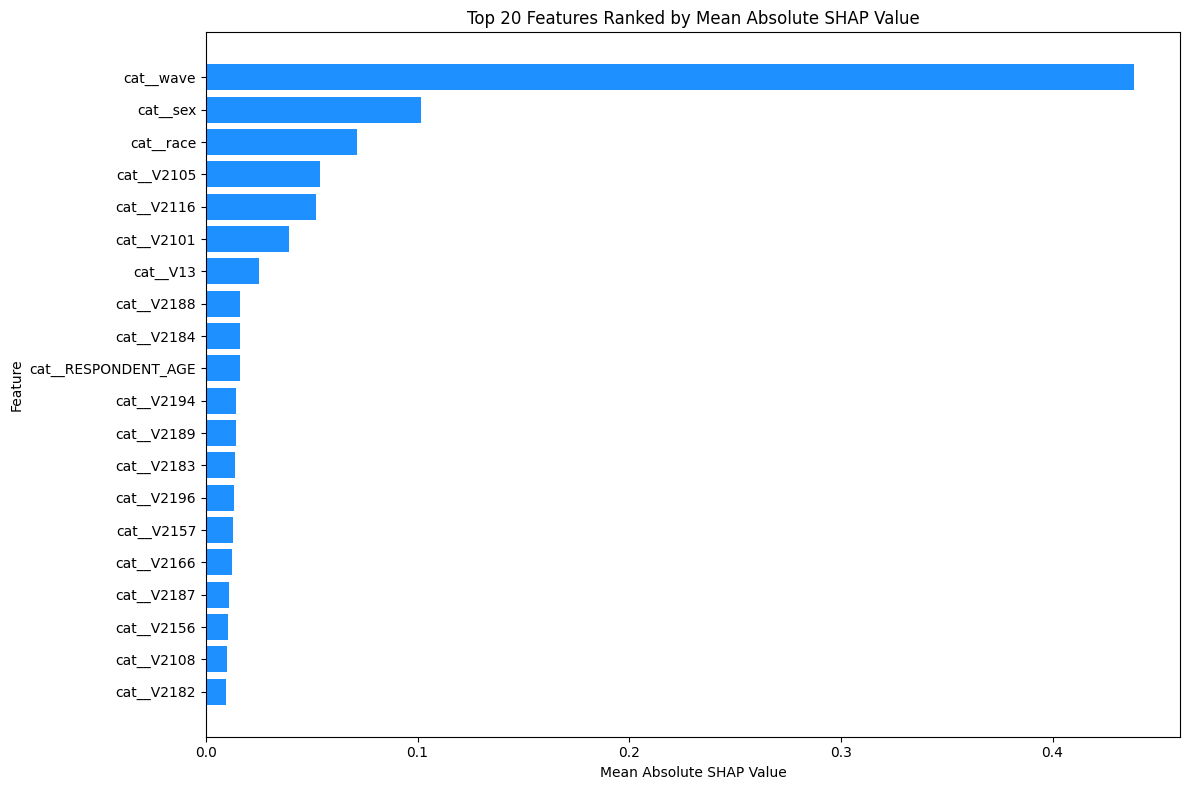

In [34]:
# 5. Create the bar plot
plt.figure(figsize=(12, 8))  # Adjust size as needed
plt.barh(top_20_importance_df['Feature'], top_20_importance_df['Importance'], color='dodgerblue')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Feature')
plt.title('Top 20 Features Ranked by Mean Absolute SHAP Value')
plt.gca().invert_yaxis()  # Most important feature on top
plt.tight_layout()
plt.show()

In [37]:
# For individual predictions (e.g., first sample)
shap.initjs()  # Initialize JavaScript visualization
single_sample_idx = 0
shap.force_plot(explainer.expected_value[1] if isinstance(shap_values, list) else explainer.expected_value,
                shap_values[single_sample_idx] if isinstance(shap_values, list) else shap_values[single_sample_idx,:],
                X_preprocessed_dense[single_sample_idx],
                feature_names=feature_names)

In [38]:
###### Demonstration of SHAP feature importance for one individual case ###########

# For individual predictions (e.g., first sample)
single_sample_idx = 0
single_sample_shap_values = shap_values[single_sample_idx] if isinstance(shap_values, list) else shap_values[single_sample_idx, :]

# Aggregate SHAP values by base feature for the single sample
feature_importances = {}
for i, feature_name in enumerate(feature_names):
    base_feature = '_'.join(feature_name.split('_')[:-1])  # Extract base feature name
    shap_value = single_sample_shap_values[i]
    feature_importances[base_feature] = feature_importances.get(base_feature, 0) + abs(shap_value)

# Sort features by importance
sorted_importances = sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)

# Print the ranked feature importance for the single prediction
print(f"Overall Feature Importance for Sample {single_sample_idx}:")
for feature, importance in sorted_importances:
    print(f"{feature}: {importance:.4f}")

Overall Feature Importance for Sample 0:
cat__wave: 2.1384
cat__V2101: 0.3304
cat__V2105: 0.2903
cat__V2166: 0.2093
cat__V2164: 0.1730
cat__V2156: 0.1704
cat__V2191: 0.1682
cat__V2116: 0.1515
cat__race: 0.1485
cat__sex: 0.1059
cat__V2196: 0.0872
cat__V2194: 0.0727
cat__V2163: 0.0655
cat__V2197: 0.0620
cat__V2186: 0.0550
cat__V2184: 0.0492
cat__V2152: 0.0458
cat__V2182: 0.0434
cat__V2179: 0.0424
cat__V2173: 0.0405
cat__V2195: 0.0384
cat__V2108: 0.0374
cat__V13: 0.0356
cat__V2193: 0.0356
cat__V2183: 0.0290
cat__RESPONDENT_AGE: 0.0287
cat__V2177: 0.0266
cat__V2175: 0.0266
cat__V2157: 0.0263
cat__V2172: 0.0262
cat__V2176: 0.0214
cat__V49: 0.0195
cat__V2178: 0.0182
cat__V2153: 0.0168
cat__V2201: 0.0160
cat__V2180: 0.0139
cat__V2181: 0.0136
cat__V2187: 0.0104
cat__V2188: 0.0098
cat__V2128: 0.0075
cat__missing_V2193: 0.0062
cat__V2189: 0.0045
cat__V2143: 0.0045
cat__V2134: 0.0044
cat__missing_V2201: 0.0042
cat__V2155: 0.0041
cat__missing_V2101: 0.0039
cat__missing_V2177: 0.0039
cat__missing_V

In [12]:
# SHAP feature interaction

# Calculate SHAP interaction values
shap_interaction_values = explainer.shap_interaction_values(X_preprocessed_dense)

   Feature1 Feature2  InteractionValue  AbsInteraction
0     V2105     wave          0.523590        0.523590
1     V2116     wave          0.508260        0.508260
3     V2101     wave          0.257760        0.257760
4      race     wave          0.152240        0.152240
5     V2196     wave          0.076287        0.076287
6      wave    V2108          0.072230        0.072230
7      wave    V2194          0.062980        0.062980
8     V2152     wave          0.039518        0.039518
9     V2166     wave          0.036883        0.036883
10    V2191     wave          0.035718        0.035718
11    V2197     wave          0.034519        0.034519
12      V13     wave          0.032518        0.032518
13     wave      sex          0.030352        0.030352
14     wave    V2163          0.030237        0.030237
15    V2176     wave          0.027862        0.027862
16     wave    V2164          0.027610        0.027610
17    V2179     wave          0.027277        0.027277
18    V217

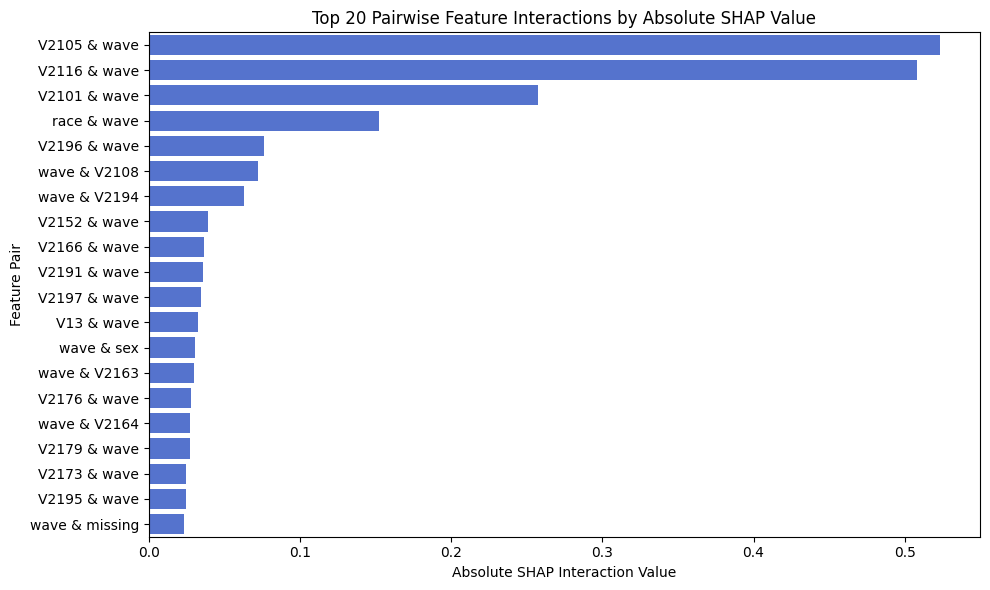

In [14]:
import numpy as np
import pandas as pd

def aggregate_shap_interactions(shap_interaction_values, feature_names, get_base_feature):
    """
    Aggregates pairwise SHAP interaction values back to their original (pre–one-hot) features.
    
    Parameters
    ----------
    shap_interaction_values : np.ndarray
        SHAP interaction values of shape [n_samples, n_features, n_features].
    feature_names : list of str
        The one-hot-encoded feature names corresponding to shap_interaction_values.
    get_base_feature : callable
        A function that takes a one-hot-encoded feature name and returns the base/original feature name.
    
    Returns
    -------
    pd.DataFrame
        DataFrame with ["Feature1", "Feature2", "InteractionValue", "AbsInteraction"] 
        sorted in descending order of AbsInteraction.
    """
    # 1. Aggregate across samples (e.g., mean absolute interactions)
    interaction_matrix = np.mean(np.abs(shap_interaction_values), axis=0)
    
    # 2. Map each OHE feature to a base feature
    base_feature_names = [get_base_feature(n) for n in feature_names]
    unique_base_features = list(set(base_feature_names))
    
    # 3. Build a structure to accumulate aggregated pairwise interactions
    aggregated_interactions = {
        bf_i: {bf_j: 0.0 for bf_j in unique_base_features}
        for bf_i in unique_base_features
    }

    n_features = len(feature_names)
    for i in range(n_features):
        for j in range(i+1, n_features): # i+1 => no diagonal, no duplicates
            bf_i = base_feature_names[i]
            bf_j = base_feature_names[j]
            aggregated_interactions[bf_i][bf_j] += interaction_matrix[i, j]
    
    # 4. Convert to DataFrame
    data_records = []
    for bf_i in unique_base_features:
        for bf_j in unique_base_features:
            # If you want to keep only i <= j, add a condition to avoid duplicates
            interaction_val = aggregated_interactions[bf_i][bf_j]
            data_records.append((bf_i, bf_j, interaction_val))
    
    df_interactions = pd.DataFrame(data_records, columns=["Feature1", "Feature2", "InteractionValue"])
    df_interactions["AbsInteraction"] = df_interactions["InteractionValue"].abs()
    
    # Sort descending by absolute interaction
    df_interactions.sort_values("AbsInteraction", ascending=False, inplace=True)
    df_interactions.reset_index(drop=True, inplace=True)
    df_interactions_no_diagonal = df_interactions[df_interactions['Feature1'] != df_interactions['Feature2']]
    return df_interactions_no_diagonal


# Example usage:
def simple_get_base_feature(name):
    # Remove the cat__ prefix if present
    if name.startswith("cat__"):
        name = name[len("cat__"):]
    # Then split on the first underscore only
    return name.split("_", 1)[0]

df_agg_interactions = aggregate_shap_interactions(
    shap_interaction_values=shap_interaction_values,
    feature_names=feature_names,
    get_base_feature=simple_get_base_feature
)

# Print the top 20 interactions
print(df_agg_interactions.head(20))

# --- Pick Top 20 Interactions ---
df_top_20 = df_agg_interactions.head(20).copy()

# Create a convenient label for each pair
df_top_20["Pair"] = df_top_20["Feature1"] + " & " + df_top_20["Feature2"]

# --- Plot ---
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_top_20, 
    y="Pair", 
    x="AbsInteraction", 
    color="royalblue"
)
plt.title("Top 20 Pairwise Feature Interactions by Absolute SHAP Value")
plt.xlabel("Absolute SHAP Interaction Value")
plt.ylabel("Feature Pair")
plt.tight_layout()
plt.show()



In [41]:
# Interaction of the top 2 features
top_features_indices = np.argsort(np.abs(shap_values).mean(0))[-2:]  # Get indices of top 2 features
feature1_idx = top_features_indices[0]
feature2_idx = top_features_indices[1]
feature1_name = feature_names[feature1_idx]
feature2_name = feature_names[feature2_idx]

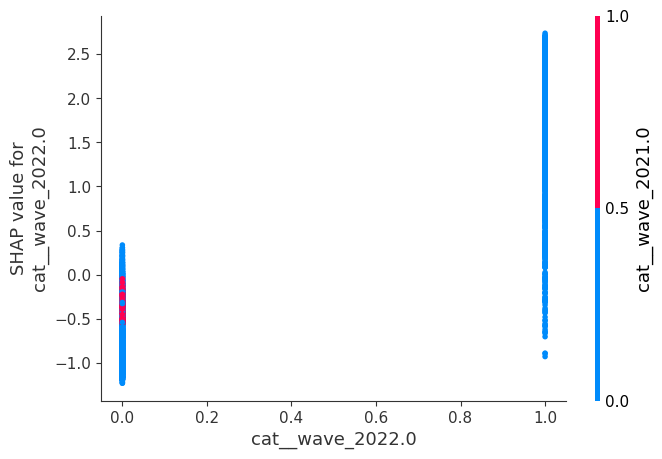

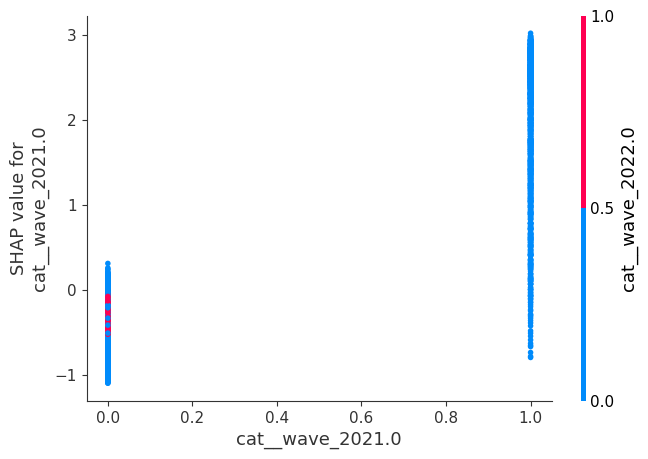

In [44]:
# Visualize the interaction between the top two features
shap.dependence_plot(
    feature1_idx,
    shap_values,
    X_preprocessed_dense,
    feature_names=feature_names,
    interaction_index=feature2_idx,
)

shap.dependence_plot(
    feature2_idx,
    shap_values,
    X_preprocessed_dense,
    feature_names=feature_names,
    interaction_index=feature1_idx,
)

In [45]:
# 1. Group feature indices by base feature
base_feature_indices = {}
for i, feature_name in enumerate(feature_names):
    base_feature = '_'.join(feature_name.split('_')[:-1])
    if base_feature not in base_feature_indices:
        base_feature_indices[base_feature] = []
    base_feature_indices[base_feature].append(i)

# 2. Calculate overall interaction importance for each pair of base features
base_feature_interaction_importance = {}
base_feature_names = list(base_feature_indices.keys())

for bf1_idx, base_feature1 in enumerate(base_feature_names):
    for bf2_idx in range(bf1_idx, len(base_feature_names)):
        base_feature2 = base_feature_names[bf2_idx]

        interaction_sum = 0
        for i in base_feature_indices[base_feature1]:
            for j in base_feature_indices[base_feature2]:
                # Handle multi-class case if shap_interaction_values is a list
                if isinstance(shap_interaction_values, list):
                    interaction_sum += shap_interaction_values[0][0, i, j]  # Assuming binary or focusing on one class
                else:
                    interaction_sum += shap_interaction_values[0, i, j]

        base_feature_interaction_importance[(base_feature1, base_feature2)] = abs(interaction_sum)

# 3. Sort base feature interactions by importance
sorted_base_feature_interactions = sorted(
    base_feature_interaction_importance.items(), key=lambda item: item[1], reverse=True
)

# 4. Print the top 50 ranked base feature interactions
print("Top 50 Overall Base Feature Interaction Importance:")
for (bf1, bf2), importance in sorted_base_feature_interactions[:50]:  # Limit to top 50
    print(f"Interaction between {bf1} and {bf2}: {importance:.4f}")


Top 50 Overall Base Feature Interaction Importance:
Interaction between cat__wave and cat__wave: 1.3226
Interaction between cat__V2101 and cat__wave: 0.4720
Interaction between cat__V2101 and cat__V2101: 0.2785
Interaction between cat__V2116 and cat__wave: 0.1632
Interaction between cat__sex and cat__sex: 0.1148
Interaction between cat__V2164 and cat__V2164: 0.1068
Interaction between cat__race and cat__wave: 0.1056
Interaction between cat__V2191 and cat__wave: 0.0967
Interaction between cat__V2105 and cat__wave: 0.0898
Interaction between cat__V2156 and cat__V2156: 0.0821
Interaction between cat__V2186 and cat__V2186: 0.0712
Interaction between cat__race and cat__race: 0.0626
Interaction between cat__V2166 and cat__wave: 0.0603
Interaction between cat__wave and cat__V2164: 0.0496
Interaction between cat__V2191 and cat__V2191: 0.0488
Interaction between cat__V2105 and cat__V2156: 0.0473
Interaction between cat__V2157 and cat__V2157: 0.0466
Interaction between cat__V2191 and cat__V2166:

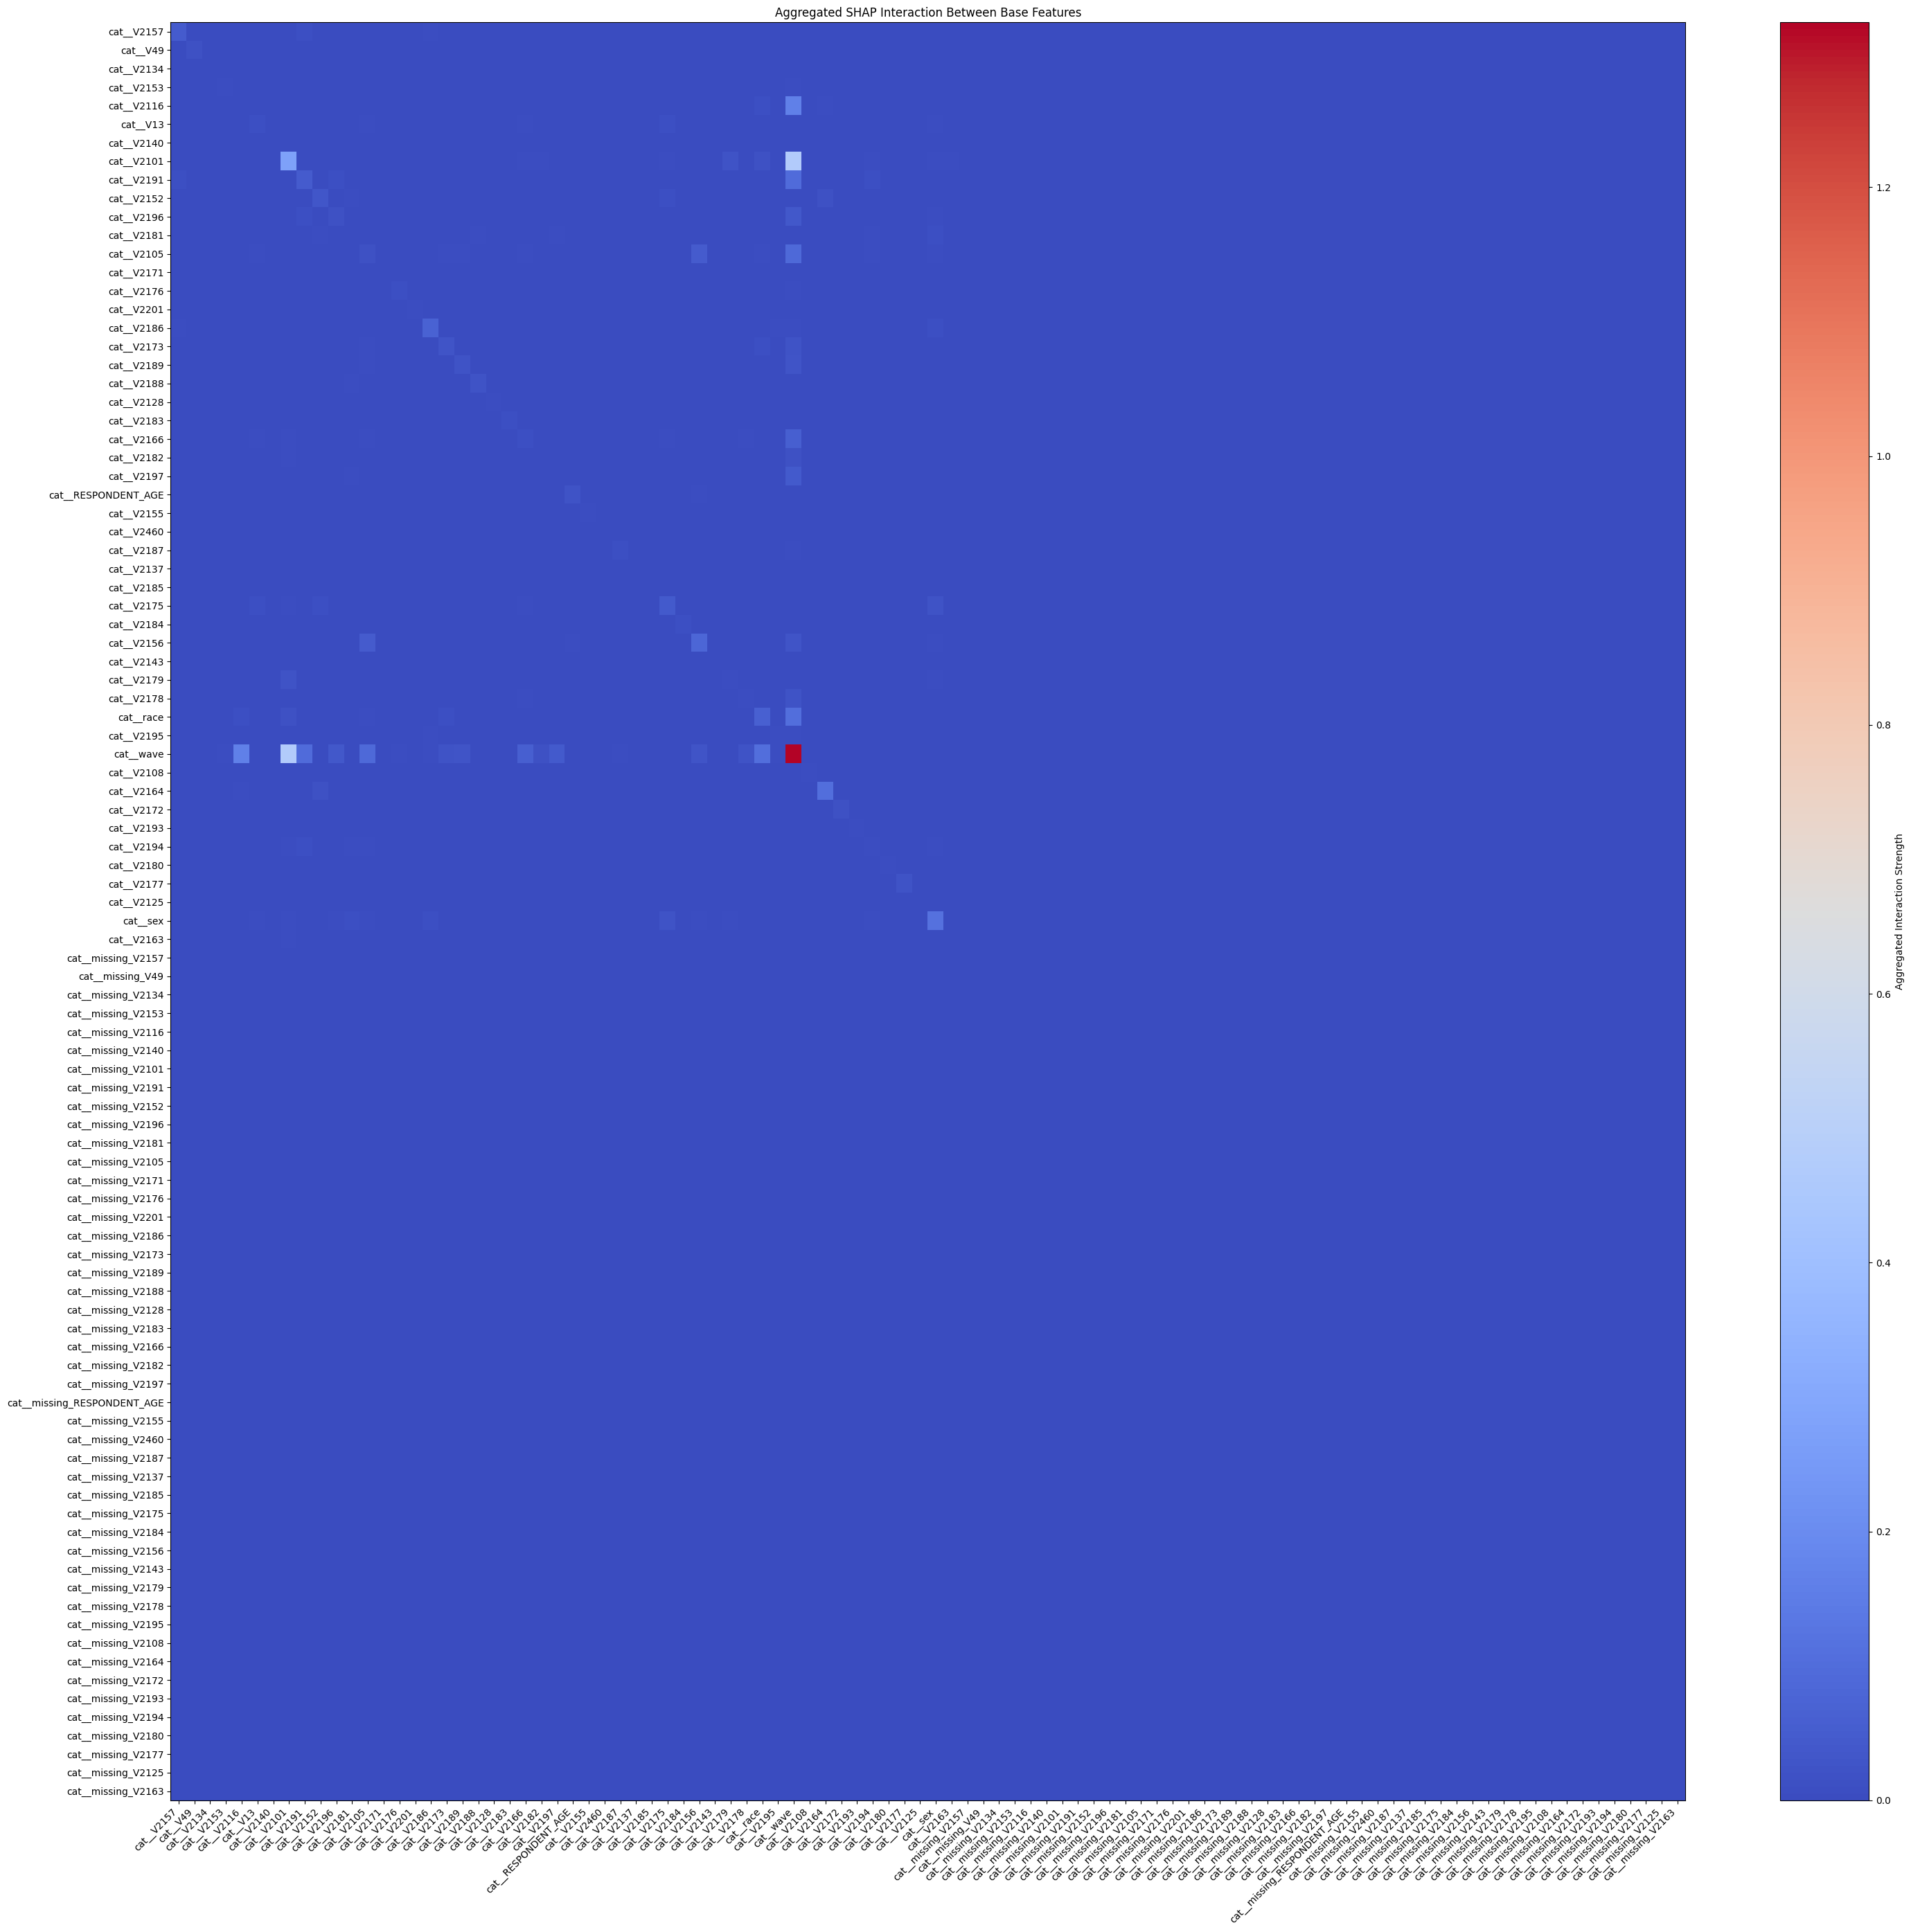

In [46]:
# 3. Create a matrix for the heatmap
num_base_features = len(base_feature_names)
interaction_matrix = np.zeros((num_base_features, num_base_features))

for i, bf1 in enumerate(base_feature_names):
    for j, bf2 in enumerate(base_feature_names):
        # Use the sorted tuple for lookup
        key = tuple(sorted((bf1, bf2)))
        if key in base_feature_interaction_importance:
            interaction_matrix[i, j] = base_feature_interaction_importance[key]
        #else:
        #    print(f"Warning: Interaction not found for {bf1}, {bf2}") # Optional debugging

# 4. Visualize the aggregated interaction using a heatmap
plt.figure(figsize=(30, 28))
plt.imshow(interaction_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar(label='Aggregated Interaction Strength')
plt.xticks(range(num_base_features), base_feature_names, rotation=45, ha="right")
plt.yticks(range(num_base_features), base_feature_names)
plt.title('Aggregated SHAP Interaction Between Base Features')
plt.tight_layout()
plt.show()

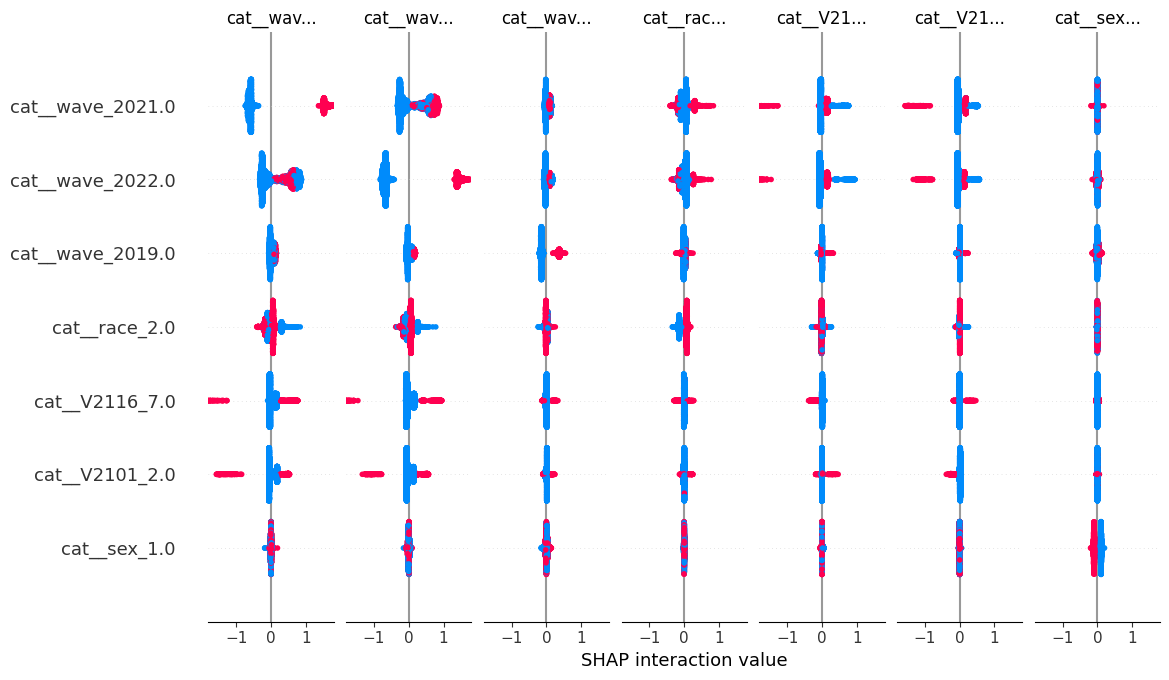

In [48]:
# Interaction Summary Plot (for overall interaction strengths)
shap.summary_plot(shap_interaction_values, X_preprocessed_dense, feature_names=feature_names)

## Histogram-based Gradient Boost Classifier

In [4]:
import logging
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import FunctionTransformer

# Random State for reproducibility
RANDOM_STATE = 42

# Use RepeatedStratifiedKFold for more robust validation
N_SPLITS_CV = 5
N_REPEATS = 1  # Repeat the CV multiple times if desired
SCORING_METRIC = 'roc_auc'
VERBOSE = 1

logging.info("\n--- Gradient Boosting (Revised) ---")

# Define the transformer:
from sklearn.preprocessing import FunctionTransformer

def to_dense_func(X):
    """Convert sparse matrices to dense arrays (if needed)."""
    return X.toarray() if hasattr(X, 'toarray') else X

to_dense = FunctionTransformer(to_dense_func)

# Build pipeline
gbc_pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('to_dense', to_dense),
    ('classifier', HistGradientBoostingClassifier(random_state=RANDOM_STATE))
])

# Expanded parameter distributions for RandomizedSearch
# Optimized parameter grid for 24-core/100GB RAM
param_grid = {
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],  # Wider range including very low rates
    'classifier__max_depth': [6, 12, 18],                 # Deeper trees with more variation
    'classifier__min_samples_leaf': [20, 50, 100],        # More granular leaf sizes
    'classifier__l2_regularization': [0.0, 0.1, 0.5, 1.0],# Stronger regularization options
    'classifier__max_bins': [255],                        # Keep max bins for accuracy
    'classifier__max_leaf_nodes': [64, 128, 256],         # Control tree complexity
    'classifier__max_iter': [2000],                       # Let early stopping handle actual iterations
}

try:
    logging.info("Starting randomized search for Gradient Boosting...")

    # Use RepeatedStratifiedKFold without shuffle
    cv_gbc = RepeatedStratifiedKFold(
        n_splits=N_SPLITS_CV, 
        n_repeats=N_REPEATS, 
        random_state=RANDOM_STATE
    )

    # RandomizedSearchCV to cover more combinations within reasonable compute time
    gbc_random_search = RandomizedSearchCV(
        estimator=gbc_pipeline,
        param_distributions=param_grid,
        n_iter=30,  # Increase or decrease based on resources
        cv=cv_gbc,
        scoring=SCORING_METRIC,
        n_jobs=24,  # Use all available cores
        random_state=RANDOM_STATE,
        verbose=VERBOSE
    )

    # Fit the RandomizedSearchCV
    gbc_random_search.fit(X_train_with_indicators, y_train)

    logging.info(f"Best parameters (GBC): {gbc_random_search.best_params_}")
    logging.info(f"Best cross-validation {SCORING_METRIC}: {gbc_random_search.best_score_:.4f}")

    # Extract the best estimator
    best_gbc = gbc_random_search.best_estimator_

except Exception as e:
    logging.error(f"An error occurred during Gradient Boosting randomized search: {e}")
    raise

# Evaluate the best Gradient Boosting model
try:
    best_gbc.fit(X_train_with_indicators, y_train)
    y_pred_gbc = best_gbc.predict(X_test_with_indicators)
    y_pred_proba_gbc = best_gbc.predict_proba(X_test_with_indicators)[:, 1]

    logging.info("=== Best Gradient Boosting Evaluation ===")
    logging.info("Confusion Matrix:\n" + str(confusion_matrix(y_test, y_pred_gbc)))
    logging.info("\nClassification Report:\n" + str(classification_report(y_test, y_pred_gbc)))
    logging.info(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_gbc):.4f}")

    # Plot ROC Curve
    fpr_gbc, tpr_gbc, _ = roc_curve(y_test, y_pred_proba_gbc)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_gbc, tpr_gbc, label=f'AUC = {roc_auc_score(y_test, y_pred_proba_gbc):.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Gradient Boosting ROC Curve on Test Data')
    plt.legend(loc='lower right')
    plt.show()

except Exception as e:
    logging.error(f"An error occurred during Gradient Boosting training/evaluation: {e}")
    raise

logging.info("Script completed successfully.")

2025-02-11 15:55:02,997 - INFO - 
--- Gradient Boosting (Revised) ---


NameError: name 'preprocessor' is not defined

In [12]:
# Define the model file path
model_filename = os.path.expanduser('~/work/vaping_project_data/best_hgbt_model.joblib')

# Save the trained model
joblib.dump(best_gbc, model_filename)
logging.info(f"Model saved to {model_filename}")

2025-02-11 14:35:04,348 - INFO - Model saved to /storage/home/szn5432/work/vaping_project_data/best_hgbt_model.joblib


In [17]:
# Load the model (when needed)
file_path = os.path.expanduser('~/work/vaping_project_data/best_hgbt_model.joblib')
loaded_hgbt = joblib.load(file_path)
print("Model loaded successfully.")

AttributeError: Can't get attribute 'to_dense_func' on <module '__main__'>

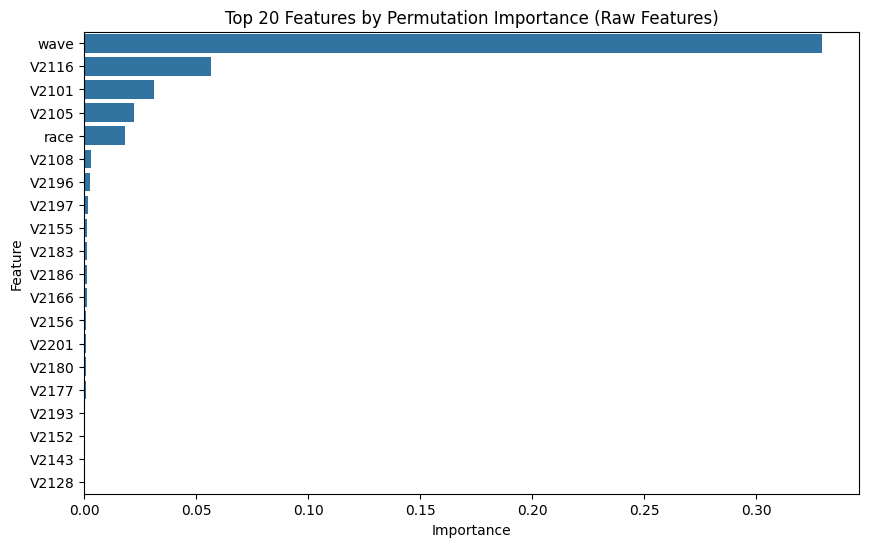

In [15]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance on RAW DATA (let pipeline handle preprocessing)
result = permutation_importance(
    loaded_hgbt,  # This is your full pipeline
    X_test_with_indicators,  # Raw data with missing indicators
    y_test,
    n_repeats=5,
    random_state=RANDOM_STATE,
    n_jobs=CPU_COUNT
)

# Get feature names from the raw data (including missing indicators)
feature_names = X_test_with_indicators.columns.tolist()

# Create importance DataFrame
perm_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': result.importances_mean
}).sort_values('Importance', ascending=False)

# Plot top 20
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=perm_importance.head(20))
plt.title("Top 20 Features by Permutation Importance (Raw Features)")
plt.show()

In [18]:
# Create a table for top 20 feature importances
top_20_features = perm_importance.head(20)

# Display the table
print("Top 20 Feature Importances:")
display(top_20_features.style.background_gradient(cmap='Blues', subset=['Importance']))

Top 20 Feature Importances:


In [16]:
##### SHAP Feature Importance ####

# Extract the GradientBoostingClassifier
hgbt_models = loaded_hgbt.named_steps['classifier']
# Get preprocessed features
X_preprocessed = loaded_hgbt.named_steps['preprocessor'].transform(X_test_with_indicators)
# Convert the Sparse Matrix to Dense
X_preprocessed_dense = X_preprocessed.toarray()
# Create SHAP explainer
explainer = shap.TreeExplainer(hgbt_models)
# Calculate SHAP values
shap_values = explainer.shap_values(X_preprocessed_dense)
# Get feature names after preprocessing
feature_names = loaded_hgbt.named_steps['preprocessor'].get_feature_names_out()

NameError: name 'loaded_hgbt' is not defined

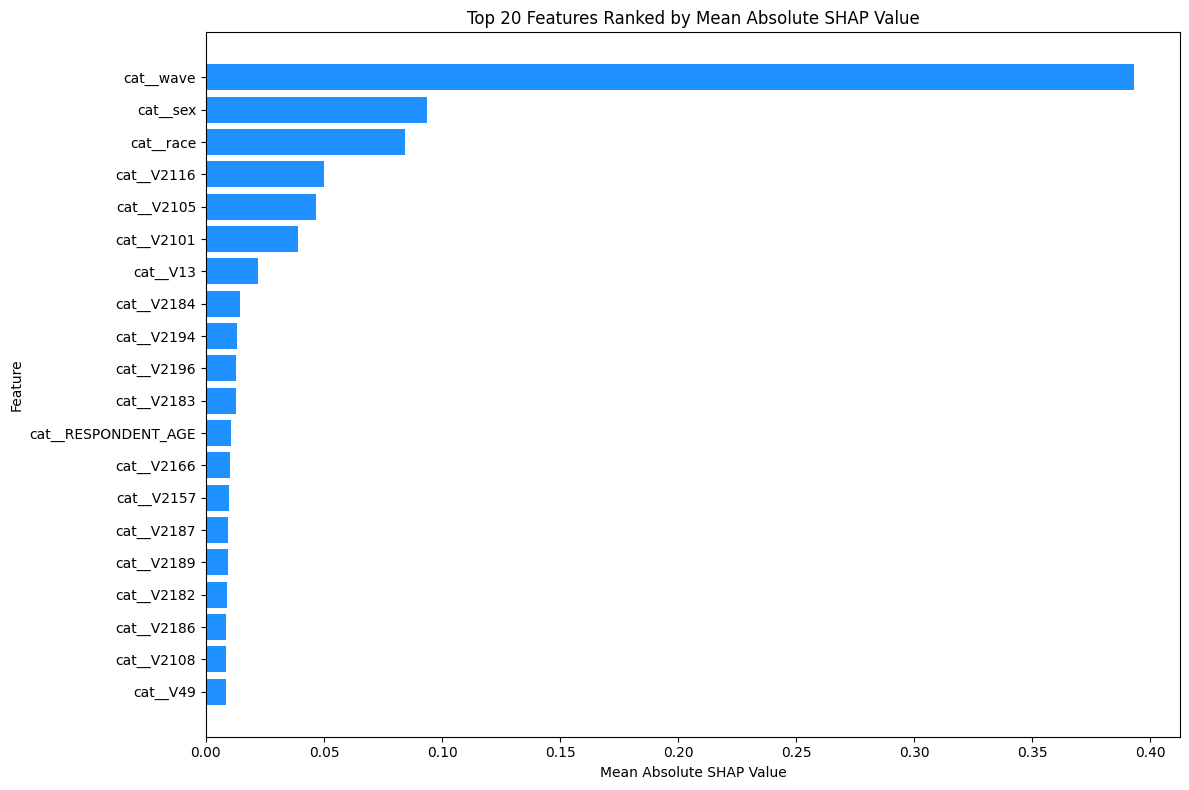

In [22]:
# 1. Aggregate SHAP values by base feature
feature_importances = {}
for i, col in enumerate(feature_names):
    base_feature = '_'.join(col.split('_')[:-1])  # Extract base feature name
    if base_feature not in feature_importances:
        feature_importances[base_feature] = []
    feature_importances[base_feature].extend(np.abs(shap_values[:, i]))

# 2. Calculate mean absolute SHAP value for each base feature
aggregated_importances = {
    feature: np.mean(values) for feature, values in feature_importances.items()
}

# 3. Sort features by importance
sorted_importances = sorted(
    aggregated_importances.items(), key=lambda item: item[1], reverse=True
)

# 4. Create a DataFrame for plotting
importance_df = pd.DataFrame(sorted_importances, columns=['Feature', 'Importance'])

# Filter to show only the top 20 features
top_20_importance_df = importance_df.head(20)

# 5. Create the bar plot
plt.figure(figsize=(12, 8))  # Adjust size as needed
plt.barh(top_20_importance_df['Feature'], top_20_importance_df['Importance'], color='dodgerblue')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Feature')
plt.title('Top 20 Features Ranked by Mean Absolute SHAP Value')
plt.gca().invert_yaxis()  # Most important feature on top
plt.tight_layout()
plt.show()

In [15]:
import numpy as np

# Suppose your X_preprocessed_dense is shape (n_samples, n_features).
# Randomly sample e.g. 300 rows:
sample_size = 300
if X_preprocessed_dense.shape[0] > sample_size:
    rnd_idx = np.random.choice(X_preprocessed_dense.shape[0], sample_size, replace=False)
    X_sampled = X_preprocessed_dense[rnd_idx]
else:
    X_sampled = X_preprocessed_dense

# Now compute interaction values on this smaller subset
shap_interaction_values = explainer.shap_interaction_values(X_sampled)

   Feature1 Feature2  InteractionValue  AbsInteraction
0     V2116     wave          0.504328        0.504328
1     V2105     wave          0.454029        0.454029
3     V2101     wave          0.291429        0.291429
4      race     wave          0.181604        0.181604
5     V2196     wave          0.088746        0.088746
6      wave    V2194          0.079542        0.079542
7      wave    V2108          0.078776        0.078776
8       V13     wave          0.050398        0.050398
9     V2116    V2105          0.047417        0.047417
10    V2179     wave          0.046188        0.046188
11    V2166     wave          0.045600        0.045600
12     wave      sex          0.044734        0.044734
13    V2191     wave          0.044718        0.044718
15    V2152     wave          0.043366        0.043366
16    V2173     wave          0.040274        0.040274
17    V2101    V2105          0.037812        0.037812
18    V2197     wave          0.037745        0.037745
19    V211

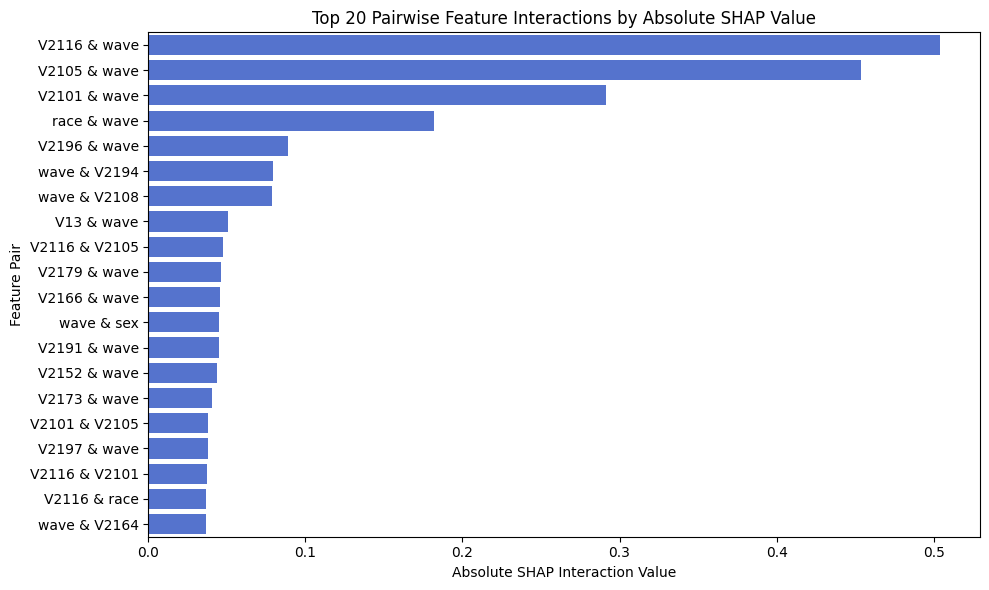

In [16]:
import numpy as np
import pandas as pd

def aggregate_shap_interactions(shap_interaction_values, feature_names, get_base_feature):
    """
    Aggregates pairwise SHAP interaction values back to their original (pre–one-hot) features.
    
    Parameters
    ----------
    shap_interaction_values : np.ndarray
        SHAP interaction values of shape [n_samples, n_features, n_features].
    feature_names : list of str
        The one-hot-encoded feature names corresponding to shap_interaction_values.
    get_base_feature : callable
        A function that takes a one-hot-encoded feature name and returns the base/original feature name.
    
    Returns
    -------
    pd.DataFrame
        DataFrame with ["Feature1", "Feature2", "InteractionValue", "AbsInteraction"] 
        sorted in descending order of AbsInteraction.
    """
    # 1. Aggregate across samples (e.g., mean absolute interactions)
    interaction_matrix = np.mean(np.abs(shap_interaction_values), axis=0)
    
    # 2. Map each OHE feature to a base feature
    base_feature_names = [get_base_feature(n) for n in feature_names]
    unique_base_features = list(set(base_feature_names))
    
    # 3. Build a structure to accumulate aggregated pairwise interactions
    aggregated_interactions = {
        bf_i: {bf_j: 0.0 for bf_j in unique_base_features}
        for bf_i in unique_base_features
    }

    n_features = len(feature_names)
    for i in range(n_features):
        for j in range(i+1, n_features): # i+1 => no diagonal, no duplicates
            bf_i = base_feature_names[i]
            bf_j = base_feature_names[j]
            aggregated_interactions[bf_i][bf_j] += interaction_matrix[i, j]
    
    # 4. Convert to DataFrame
    data_records = []
    for bf_i in unique_base_features:
        for bf_j in unique_base_features:
            # If you want to keep only i <= j, add a condition to avoid duplicates
            interaction_val = aggregated_interactions[bf_i][bf_j]
            data_records.append((bf_i, bf_j, interaction_val))
    
    df_interactions = pd.DataFrame(data_records, columns=["Feature1", "Feature2", "InteractionValue"])
    df_interactions["AbsInteraction"] = df_interactions["InteractionValue"].abs()
    
    # Sort descending by absolute interaction
    df_interactions.sort_values("AbsInteraction", ascending=False, inplace=True)
    df_interactions.reset_index(drop=True, inplace=True)
    df_interactions_no_diagonal = df_interactions[df_interactions['Feature1'] != df_interactions['Feature2']]
    return df_interactions_no_diagonal


# Example usage:
def simple_get_base_feature(name):
    # Remove the cat__ prefix if present
    if name.startswith("cat__"):
        name = name[len("cat__"):]
    # Then split on the first underscore only
    return name.split("_", 1)[0]

df_agg_interactions = aggregate_shap_interactions(
    shap_interaction_values=shap_interaction_values,
    feature_names=feature_names,
    get_base_feature=simple_get_base_feature
)

# Print the top 20 interactions
print(df_agg_interactions.head(20))

# --- Pick Top 20 Interactions ---
df_top_20 = df_agg_interactions.head(20).copy()

# Create a convenient label for each pair
df_top_20["Pair"] = df_top_20["Feature1"] + " & " + df_top_20["Feature2"]

# --- Plot ---
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_top_20, 
    y="Pair", 
    x="AbsInteraction", 
    color="royalblue"
)
plt.title("Top 20 Pairwise Feature Interactions by Absolute SHAP Value")
plt.xlabel("Absolute SHAP Interaction Value")
plt.ylabel("Feature Pair")
plt.tight_layout()
plt.show()



## XGBOOST

2025-02-11 17:02:07,678 - INFO - Starting RandomizedSearchCV for expanded XGBoost grid...


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/storage/home/szn5432/work/vaping_project/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/storage/home/szn5432/work/vaping_project/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/storage/home/szn5432/work/vaping_project/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/storage/home/szn5432/work/vaping_project/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories wi

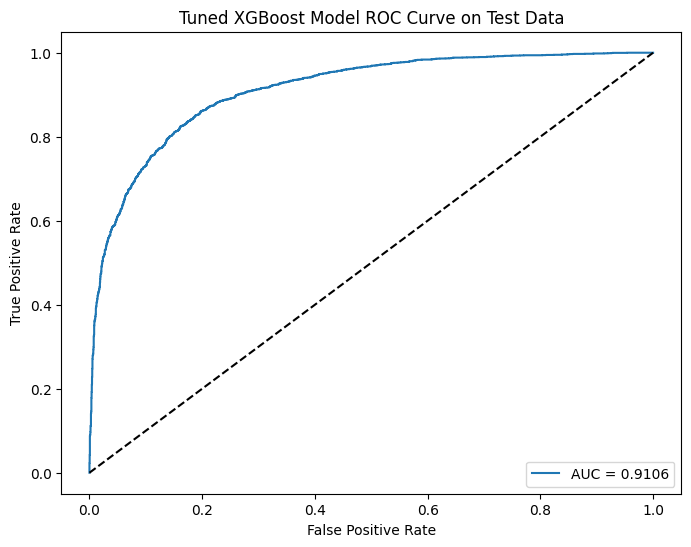

2025-02-11 17:05:13,533 - INFO - Final XGBoost model saved to: /storage/home/szn5432/work/vaping_project_data/best_xgb_model.joblib


In [21]:
import os
import logging
import joblib
import xgboost as xgb

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import FunctionTransformer
import numpy as np

# ======================
# 1. Expanded Hyperparameter Grid
# ======================
param_dist = {
    # Increase n_estimators up to 1000 (or more)
    'classifier__n_estimators': [100, 300, 500, 800, 1000],
    
    # Smaller learning rates for finer updates
    'classifier__learning_rate': [0.01, 0.02, 0.03, 0.05, 0.1],
    
    # Broader range for max_depth
    'classifier__max_depth': [3, 5, 7, 9, 12],
    
    # Tweak min_child_weight to control complexity
    'classifier__min_child_weight': [1, 3, 5, 7, 10],
    
    # Keep or enlarge subsample
    'classifier__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    
    # Potentially try colsample_bytree > 1.0 (uncommon, but possible)
    'classifier__colsample_bytree': [0.6, 0.8, 1.0, 1.2],
    
    # Adjust gamma (larger => more conservative splits)
    'classifier__gamma': [0, 0.1, 0.3, 0.6, 1.0],
    
    # Expand regularization range
    'classifier__reg_alpha': [0, 0.1, 0.2, 0.5, 1.0, 2.0],
    'classifier__reg_lambda': [0.5, 1.0, 1.5, 2.0, 3.0, 4.0]
}

# ============================
# 2. OPTIONAL FEATURE ENGINEERING
# ============================
# Example: add a custom transformer to create domain-specific or interaction features
# (Here, we just pass data through, but you'd modify 'feature_engineering' to transform the input DataFrame.)

def feature_engineering(X):
    """
    Placeholder function where you can create domain-specific,
    polynomial, or ratio features. This must return a DataFrame or array.
    """
    # Example: create a simple ratio of two columns (if they exist)
    # if 'colA' in X and 'colB' in X:
    #     X['ratio_A_B'] = X['colA'] / (X['colB'] + 1e-9)
    
    return X

feature_eng_transformer = FunctionTransformer(feature_engineering, validate=False)

# ============================
# 3. Build Pipeline
# ============================
# We assume:
#   - You already have 'preprocessor' for OneHotEncoder, etc.
#   - 'X_train_with_indicators', 'y_train', 'X_test_with_indicators', 'y_test'
#   - 'train_evaluate_model(...)' function
#   - Constants: RANDOM_STATE, SCORING_METRIC, N_SPLITS_CV

xgb_clf = xgb.XGBClassifier(
    eval_metric='logloss',
    random_state=RANDOM_STATE
)

# Here we insert a feature engineering step *before* the preprocessor:
xgb_pipeline = Pipeline([
    ('feature_engineering', feature_eng_transformer),
    ('preprocessor', preprocessor),
    ('classifier', xgb_clf)
])

# =========================
# 4. (Optional) Early Stopping
# =========================
# In scikit-learn's RandomizedSearchCV, providing early_stopping_rounds is non-trivial because
# you need a separate validation set or a custom approach inside each CV fold.
# If you wish to do a simple holdout for early stopping, you'd do something like:
#
# fit_params = {
#    'classifier__early_stopping_rounds': 30,
#    'classifier__eval_metric': 'logloss',
#    'classifier__eval_set': [(X_val, y_val)],  # separate validation set
# }
#
# Then pass fit_params=fit_params to random_search.fit(...).
# This is more advanced; we’ll skip it here for brevity.

# ============================
# 5. Randomized Search Setup
# ============================
cv = StratifiedKFold(n_splits=N_SPLITS_CV, shuffle=True, random_state=RANDOM_STATE)

random_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_dist,
    n_iter=50,  # Increase if you have time/resources
    cv=cv,
    scoring=SCORING_METRIC,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE
)

logging.info("Starting RandomizedSearchCV for expanded XGBoost grid...")
random_search.fit(X_train_with_indicators, y_train)
logging.info("RandomizedSearchCV complete.")

best_xgb_model = random_search.best_estimator_
logging.info(f"Best parameters: {random_search.best_params_}")
logging.info(f"Best CV {SCORING_METRIC}: {random_search.best_score_:.4f}")

# ============================
# 6. Evaluate & Save Best Model
# ============================
trained_best_xgb = train_evaluate_model(
    model=best_xgb_model,
    X_train=X_train_with_indicators,
    y_train=y_train,
    X_test=X_test_with_indicators,
    y_test=y_test,
    model_name="Tuned XGBoost Model"
)

model_filename = os.path.expanduser('~/work/vaping_project_data/best_xgb_model.joblib')
joblib.dump(trained_best_xgb, model_filename)
logging.info(f"Final XGBoost model saved to: {model_filename}")


In [11]:
# Load the model (when needed)
def feature_engineering(X):
    """
    Placeholder function where you can create domain-specific,
    polynomial, or ratio features. This must return a DataFrame or array.
    """
    # Example: create a simple ratio of two columns (if they exist)
    # if 'colA' in X and 'colB' in X:
    #     X['ratio_A_B'] = X['colA'] / (X['colB'] + 1e-9)
    
    return X

file_path = os.path.expanduser('~/work/vaping_project_data/best_xgb_model.joblib')
loaded_xgb = joblib.load(file_path)
print("Model loaded successfully.")

Model loaded successfully.


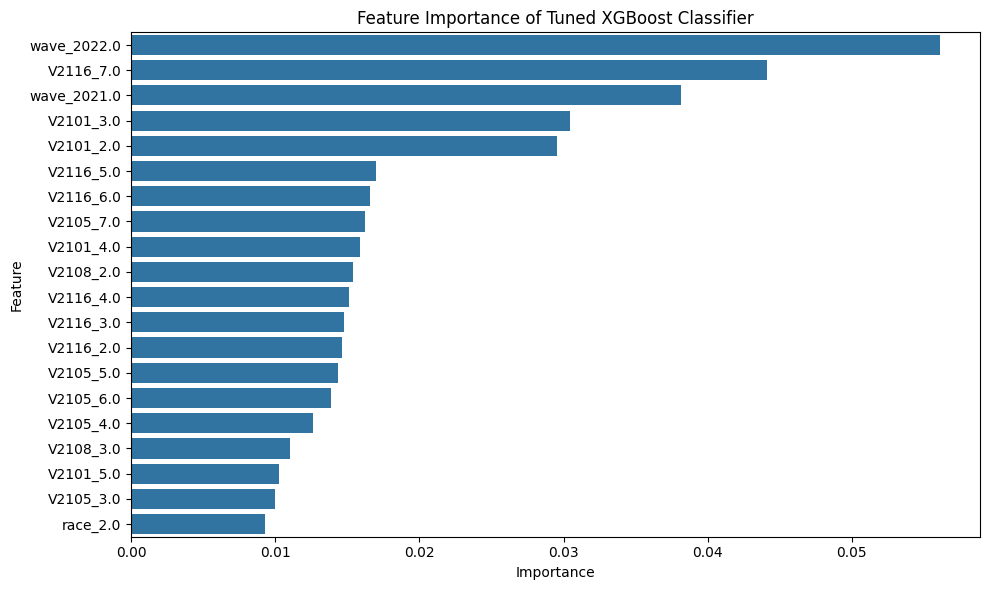

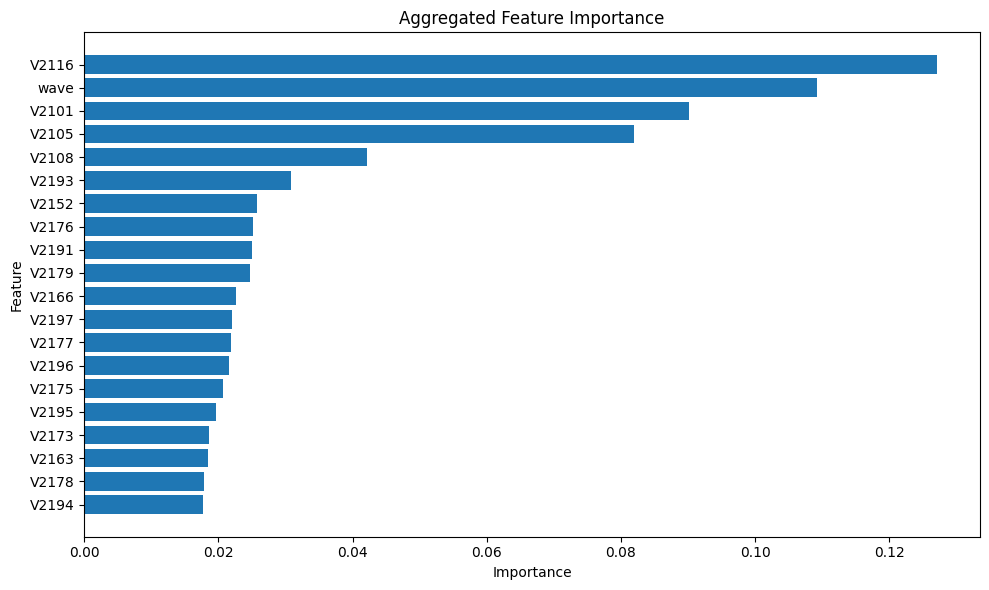

Index(['Feature', 'Importance'], dtype='object')
   Feature  Importance
18   V2116    0.127147
13    wave    0.109239
1    V2101    0.090174
46   V2105    0.081926
3    V2108    0.042212
30   V2193    0.030896
22   V2152    0.025759
49   V2176    0.025096
50   V2191    0.025034
24   V2179    0.024769
39   V2166    0.022658
33   V2197    0.022045
11   V2177    0.021900
38   V2196    0.021525
34   V2175    0.020727
17   V2195    0.019664
41   V2173    0.018635
9    V2163    0.018483
31   V2178    0.017926
26   V2194    0.017764


In [30]:
# --- Feature Importance ---

# Debugging: Print the feature importances
# importances = loaded_xgb.named_steps['classifier'].feature_importances_
# print("Feature importances:", importances)

# Debugging: Print the encoded feature names
# encoded_feature_names = loaded_xgb.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(input_features=categorical_features)
# print("Encoded feature names:", encoded_feature_names)

# Ensure the lengths match
#if len(importances) != len(encoded_feature_names):
#    raise ValueError("The lengths of feature importances and encoded feature names do not match.")

# Plot feature importance
plot_feature_importance(
    loaded_xgb,
    feature_names=encoded_feature_names,
    top_n=20,
    title="Feature Importance of Tuned XGBoost Classifier"
)

# Aggregate and plot feature importance
aggregated_importance_df = aggregate_feature_importance(importances, encoded_feature_names)
plot_aggregated_feature_importance(aggregated_importance_df, top_n=20, title="Aggregated Feature Importance")

# Check the columns and the first few rows of the aggregated importance DataFrame
print(aggregated_importance_df.columns)
print(aggregated_importance_df.head(20))

Top feature indices used for PDP: [4, 39, 7, 12, 40, 43, 9, 14, 8, 35]


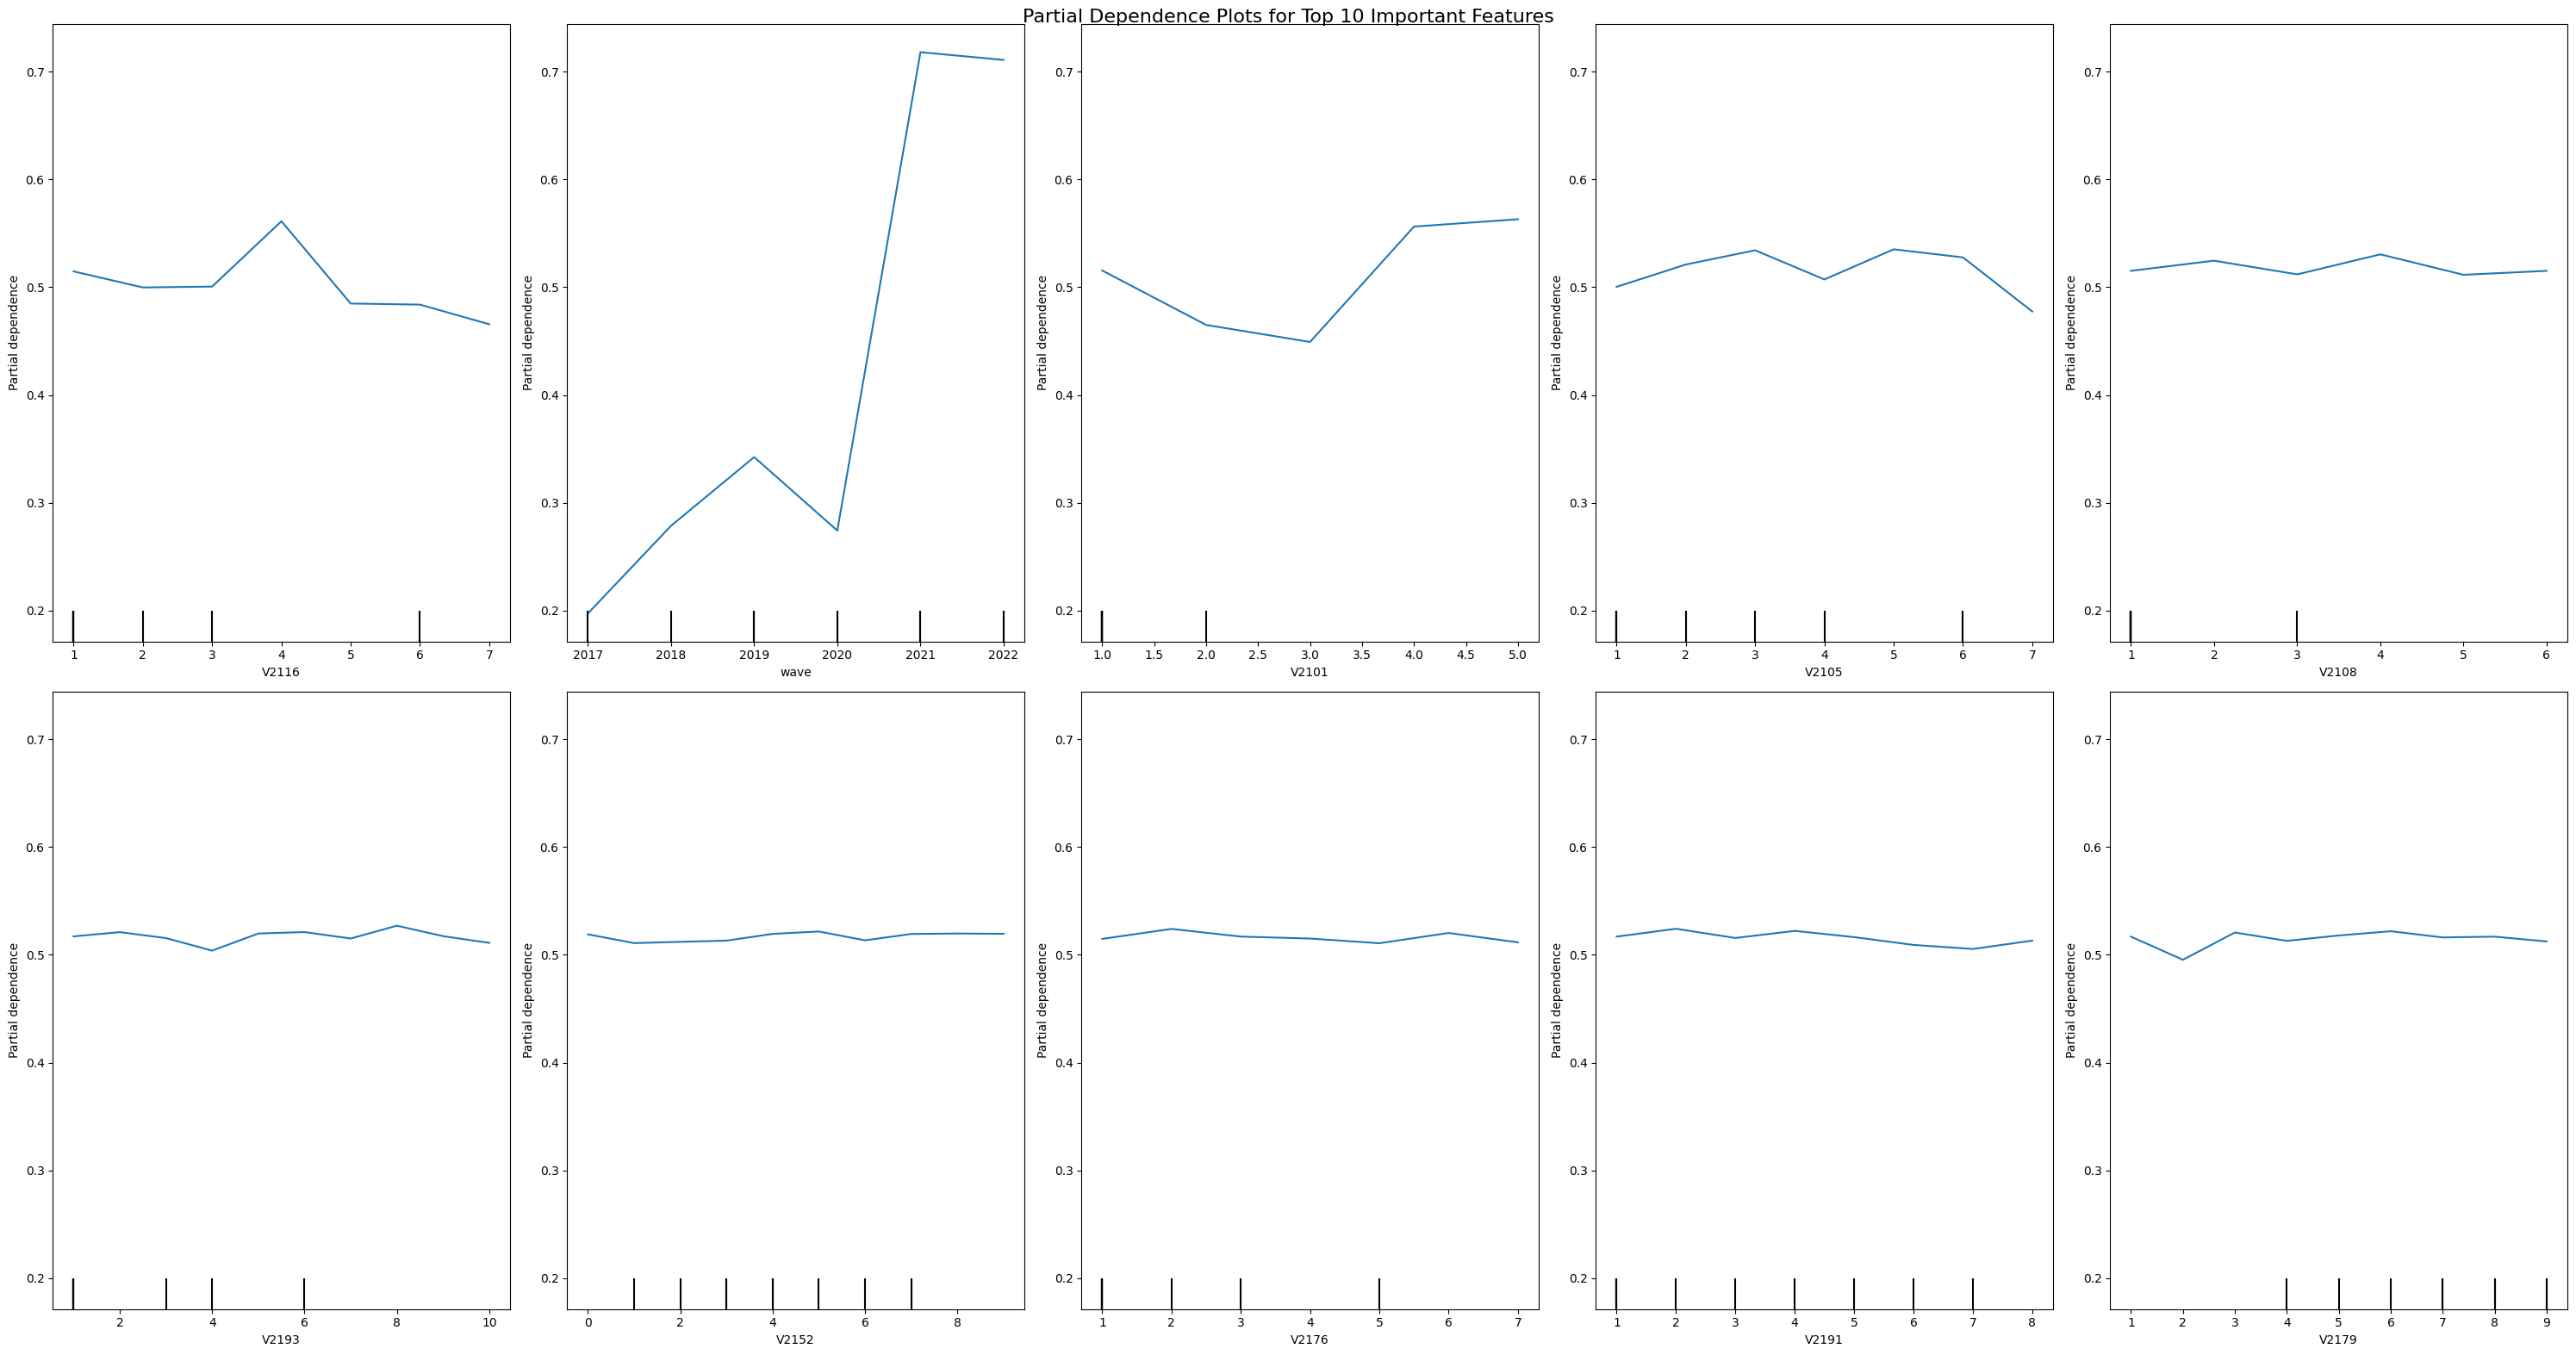

In [38]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Aassume aggregated_importance_df is sorted descending by 'Importance',
# take the top 10 base features.
top_10_features = aggregated_importance_df['Feature'].head(10).tolist()

# Map each aggregated (base) feature name to the first matching column in X_train_with_indicators
top_feature_indices = []
for base_feat in top_10_features:
    # Attempt to find columns whose names start with or contain the base feature name
    # (Adjust matching logic as needed for your naming convention)
    matched_cols = [col for col in X_train_with_indicators.columns if col.startswith(base_feat)]
    
    if matched_cols:
        idx = X_train_with_indicators.columns.get_loc(matched_cols[0])
        top_feature_indices.append(idx)
    else:
        print(f"Warning: No matching column found in X_train_with_indicators for '{base_feat}'.")

print("Top feature indices used for PDP:", top_feature_indices)

# Plot partial dependence for these columns.
# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30, 16))
axes = axes.ravel()  # Flatten the axes array for easy indexing

PartialDependenceDisplay.from_estimator(
    estimator=loaded_xgb,          # final pipeline or model
    X=X_train_with_indicators,           # The same DataFrame used in training
    features=top_feature_indices,        # List of feature indices to plot
    feature_names=X_train_with_indicators.columns,
    grid_resolution=50,
    ax=axes
)

plt.suptitle("Partial Dependence Plots for Top 10 Important Features", fontsize=16)
plt.tight_layout()
plt.show()


In [19]:
# Add this import at the top of your script
from scipy import sparse

# --- SHAP Feature Importance ---
# Suppose your ColumnTransformer has the name "cat" for the OneHotEncoder step
# and you pass in categorical_features as the input_features:
encoded_feature_names = (
    preprocessor
    .named_transformers_['cat']  # "cat" is the name of the OHE step in ColumnTransformer
    .get_feature_names_out(input_features=categorical_features)
)


# Extract components from the pipeline
preprocessor = loaded_xgb.named_steps['preprocessor']
classifier = loaded_xgb.named_steps['classifier']

# Process the data through the pipeline
X_processed = preprocessor.transform(X_train_with_indicators)

# Convert sparse matrix to dense if needed
if isinstance(X_processed, (sparse.csr_matrix, sparse.csc_matrix)):
    X_processed = X_processed.toarray()

# Create a SHAP explainer
explainer = shap.TreeExplainer(classifier)

# Calculate SHAP values (using a sample for faster computation)
sample_idx = np.random.choice(X_processed.shape[0], 100, replace=False)
shap_values = explainer.shap_values(X_processed[sample_idx])

# Get feature names from the preprocessor
feature_names = encoded_feature_names  # From your existing code

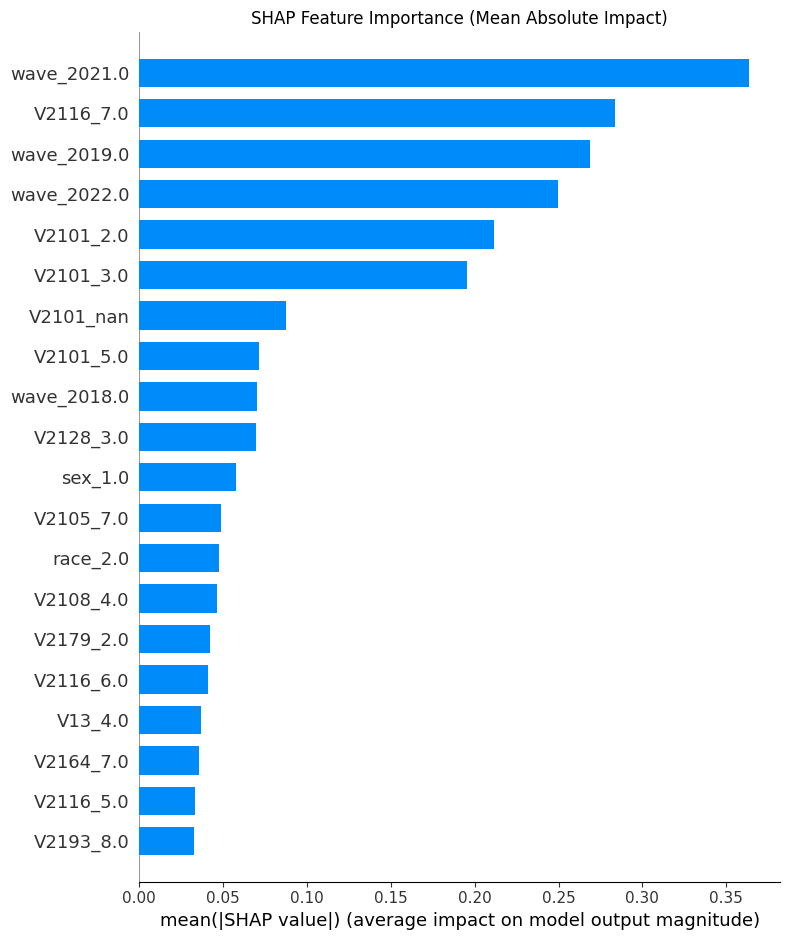

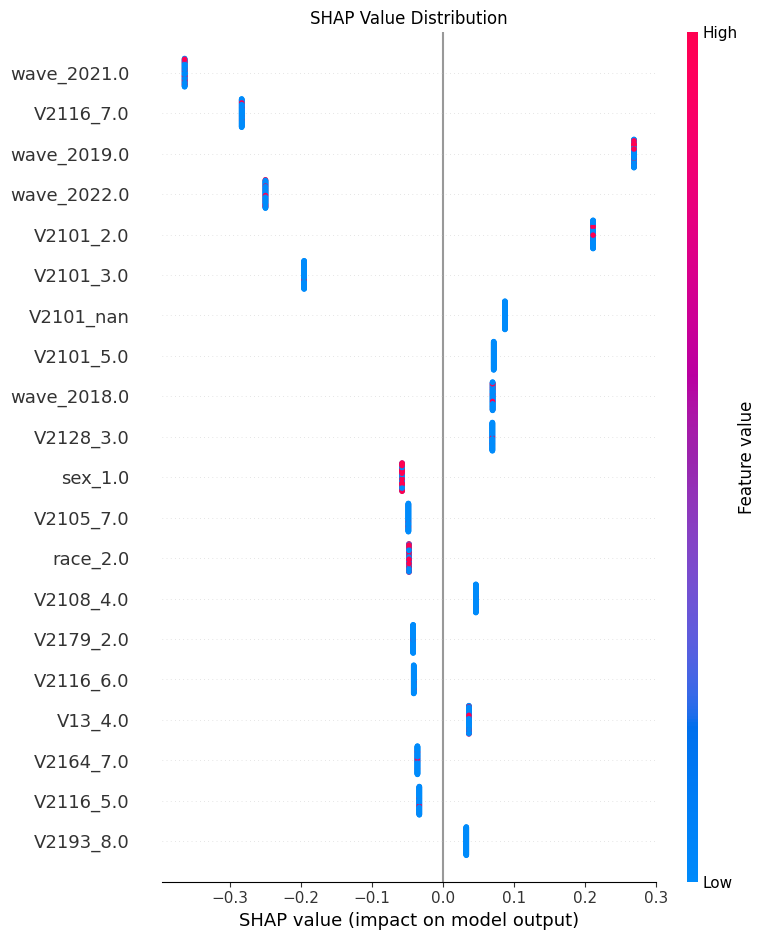

In [20]:
# Summary plot (feature importance)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, 
                 X_processed[sample_idx], 
                 feature_names=feature_names,
                 plot_type="bar",
                 show=False)
plt.title("SHAP Feature Importance (Mean Absolute Impact)")
plt.tight_layout()
plt.show()

# Detailed summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, 
                 X_processed[sample_idx], 
                 feature_names=feature_names,
                 show=False)
plt.title("SHAP Value Distribution")
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

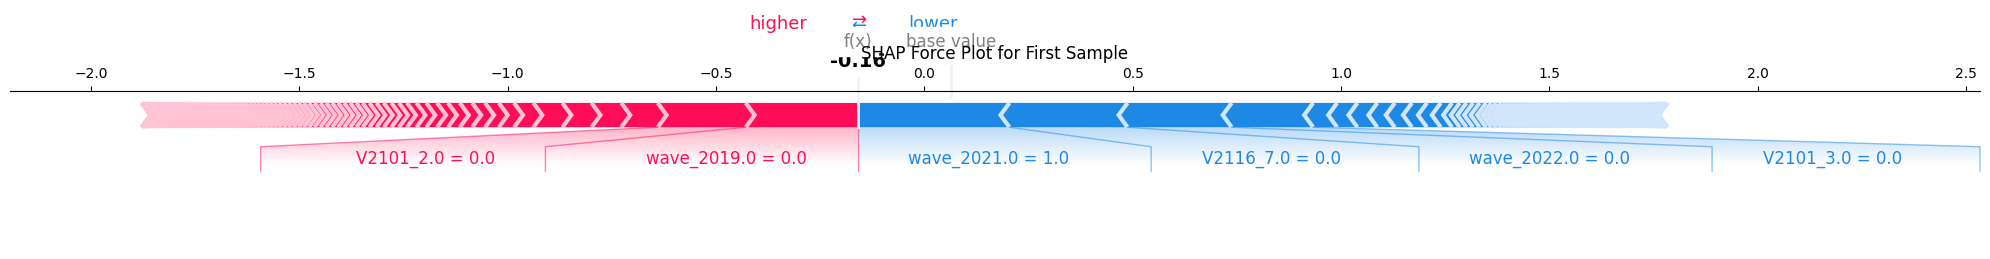

In [41]:
# Force plot for average prediction
plt.figure()
shap.force_plot(explainer.expected_value, 
                shap_values[0], 
                X_processed[0], 
                feature_names=feature_names,
                matplotlib=True,
                show=False)
plt.title("SHAP Force Plot for First Sample")
plt.tight_layout()
plt.show()

In [42]:
# Extract original categorical features from one-hot encoded column names
import re

# Get the list of one-hot encoded column names
one_hot_encoded_columns = feature_names.tolist()

# Extract original categorical features by splitting at the first underscore or dot
original_categorical_features = list(set([re.split(r'[_.]', col)[0] for col in one_hot_encoded_columns]))

print("Original Categorical Features:")
print(original_categorical_features)

Original Categorical Features:
['RESPONDENT', 'V2101', 'V2171', 'V2108', 'V2181', 'V2128', 'V2155', 'V2189', 'V2172', 'V2163', 'V2201', 'V2177', 'V2156', 'wave', 'V2185', 'V2140', 'V2137', 'V2195', 'V2116', 'V2183', 'V2182', 'missing', 'V2152', 'V2460', 'V2179', 'V2188', 'V2194', 'V2187', 'V2186', 'sex', 'V2193', 'V2178', 'V2153', 'V2197', 'V2175', 'V2184', 'V2164', 'V2157', 'V2196', 'V2166', 'V2134', 'V2173', 'race', 'V2143', 'V13', 'V2125', 'V2105', 'V2180', 'V49', 'V2176', 'V2191']


Top 20 Aggregated SHAP Features:
   Feature  Aggregated_SHAP
58    wave         0.981306
57   V2101         0.588509
42   V2116         0.404557
10   V2128         0.099832
11   V2105         0.097519
56   V2193         0.079509
55   V2179         0.076390
45   V2166         0.075995
24   V2164         0.074029
29   V2152         0.069390
34   V2108         0.065110
28     V13         0.064046
31   V2196         0.061689
36   V2177         0.060719
53     sex         0.057532
33   V2173         0.057169
20    race         0.055380
49   V2201         0.052758
3    V2178         0.050038
12   V2175         0.046347


/tmp/ipykernel_3042773/2393572530.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Aggregated_SHAP', y='Feature', data=aggregated_shap_df.head(top_n), palette='viridis')


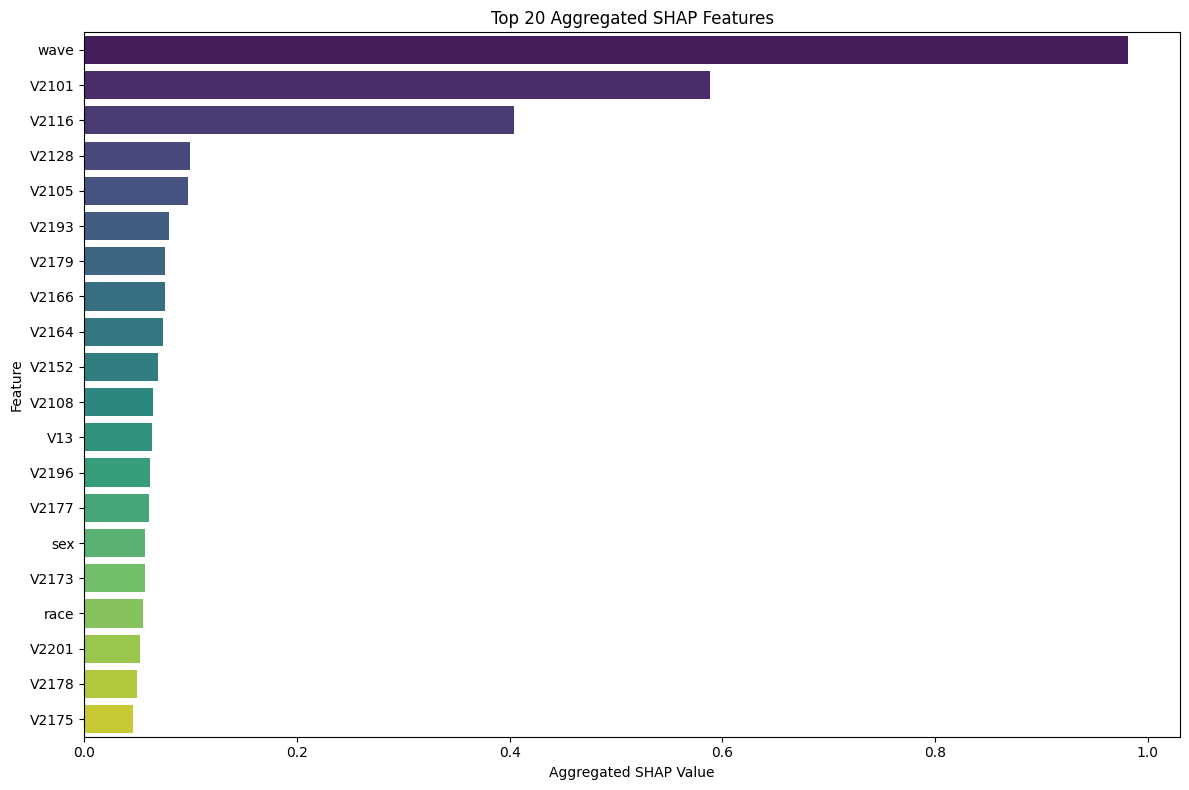

In [21]:
# List of original categorical features
original_categorical_features = [
    'V2137', 'V2172', 'V2181', 'V2178', 'V2134', 'V2163', 'V2197', 'V2188', 'V2191', 'V2155', 
    'V2128', 'V2105', 'V2175', 'V2185', 'V2153', 'V2194', 'V2183', 'V2143', 'V2184', 'V2460', 
    'race', 'V2907', 'V2494', 'RESPONDENT', 'V2164', 'V2146', 'V49', 'V2182', 'V13', 'V2152', 
    'V2176', 'V2196', 'V2187', 'V2173', 'V2108', 'V2033', 'V2177', 'V2030', 'V2171', 'V2119', 
    'V2908', 'V2195', 'V2116', 'V2180', 'V2186', 'V2166', 'V2140', 'V2156', 'V2189', 'V2201', 
    'V2169', 'V2122', 'missing', 'sex', 'V2125', 'V2179', 'V2193', 'V2101', 'wave', 'V2157'
]

# Compute mean absolute SHAP values
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

# Create a dictionary to map one-hot encoded features to their original features
feature_mapping = {}
for feature in original_categorical_features:
    feature_mapping[feature] = [col for col in feature_names if col.startswith(feature)]

# Aggregate SHAP values for each original feature
aggregated_shap_values = {}
for feature, cols in feature_mapping.items():
    # Find the indices of the one-hot encoded columns for this feature
    indices = [feature_names.tolist().index(col) for col in cols]
    # Sum the mean absolute SHAP values for these columns
    aggregated_shap_values[feature] = np.sum(mean_abs_shap_values[indices])

# Convert the aggregated SHAP values to a DataFrame
aggregated_shap_df = pd.DataFrame({
    'Feature': list(aggregated_shap_values.keys()),
    'Aggregated_SHAP': list(aggregated_shap_values.values())
})

# Sort by aggregated SHAP values in descending order
aggregated_shap_df = aggregated_shap_df.sort_values(by='Aggregated_SHAP', ascending=False)

# Display the top 20 aggregated features
top_n = 20  # Set to 20 for top 20 features
print("Top 20 Aggregated SHAP Features:")
print(aggregated_shap_df.head(top_n))

# Plot the top 20 aggregated features
plt.figure(figsize=(12, 8))
sns.barplot(x='Aggregated_SHAP', y='Feature', data=aggregated_shap_df.head(top_n), palette='viridis')
plt.title(f'Top {top_n} Aggregated SHAP Features')
plt.xlabel('Aggregated SHAP Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [22]:
# Ensure SHAP is installed
import shap
shap.initjs()  # For visualization in notebooks

# Compute SHAP interaction values (using a sample for faster computation)
sample_idx = np.random.choice(X_processed.shape[0], 100, replace=False)  # Use a sample of 100 instances
shap_interaction_values = explainer.shap_interaction_values(X_processed[sample_idx])

# Get feature names from the preprocessor
feature_names = encoded_feature_names  # From your existing code

Top 30 Feature Interactions (Unique Pairs):
    Interaction Value Feature A Feature B
0           91.213188     V2116      wave
1           54.671593     V2105      wave
2           51.319290     V2101      wave
3           25.021938     V2101     V2116
4           21.735048     V2108      wave
5           17.244469     V2105     V2116
6           13.156952      race      wave
7           12.924644     V2101     V2105
8           10.613182     V2179      wave
9           10.368965     V2194      wave
10           9.632638     V2166      wave
11           9.092901     V2196      wave
12           8.929667     V2108     V2116
13           8.652250     V2163      wave
14           8.636138     V2191      wave
15           7.265688     V2164      wave
16           7.066531     V2152      wave
17           6.982769     V2173      wave
18           5.612301       V13      wave
19           5.506928     V2197      wave
20           5.492619     V2101     V2108
21           5.227992     V2116 

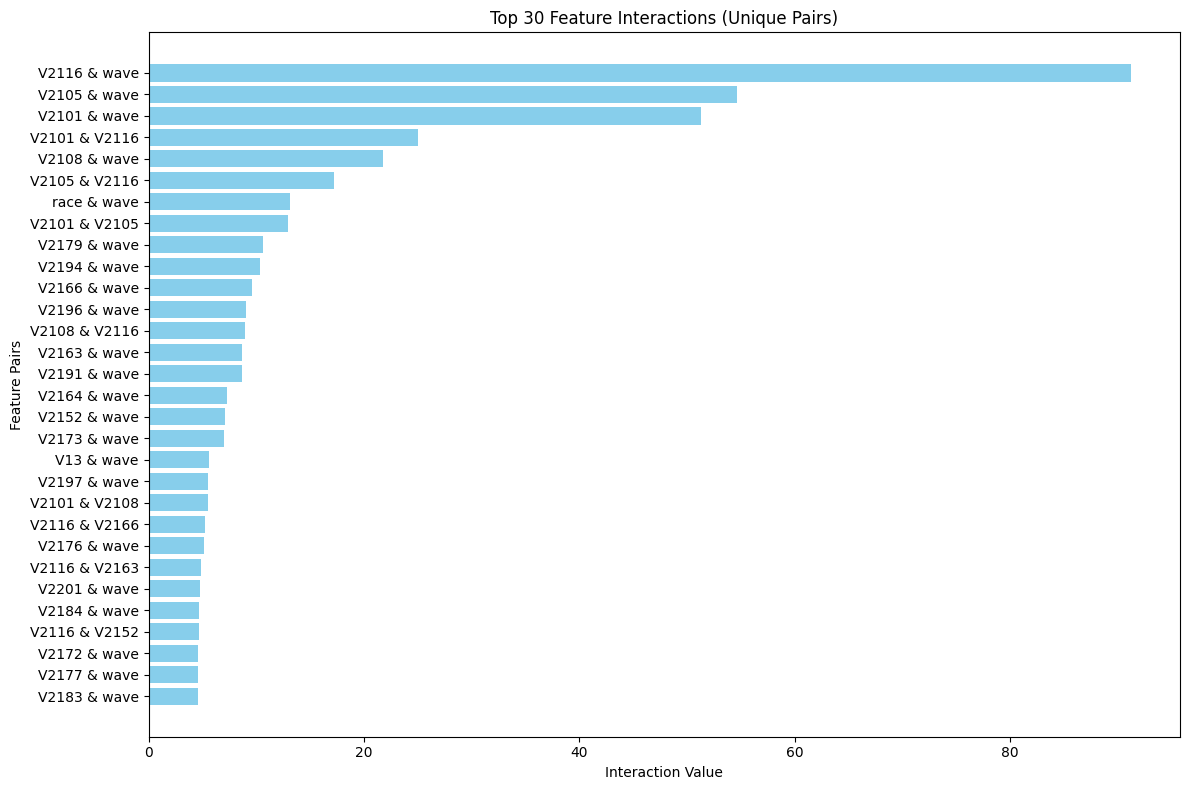

In [23]:
# Step 1: Store interactions and their values, avoiding duplicates and self-interactions
interaction_results = []

for i, feature_i in enumerate(original_categorical_features):
    for j, feature_j in enumerate(original_categorical_features):
        # Skip self-interactions
        if feature_i == feature_j:
            continue

        # Ensure unique pairs by sorting feature names
        feature_pair = tuple(sorted([feature_i, feature_j]))

        # Skip if the pair is already processed
        if feature_pair in [result[0] for result in interaction_results]:
            continue

        # Get indices for feature_i and feature_j
        indices_i = [feature_names.tolist().index(col) for col in feature_mapping[feature_i] if col in feature_names.tolist()]
        indices_j = [feature_names.tolist().index(col) for col in feature_mapping[feature_j] if col in feature_names.tolist()]

        if not indices_i or not indices_j:
            continue

        # Compute interaction value
        value = np.sum(np.abs(shap_interaction_values[:, indices_i, :][:, :, indices_j]))
        interaction_results.append((feature_pair, value))

# Step 2: Sort the interactions by their values
sorted_interactions = sorted(interaction_results, key=lambda x: x[1], reverse=True)

# Step 3: Convert results to a DataFrame for easy aggregation
interaction_df = pd.DataFrame(sorted_interactions, columns=["Feature Pair", "Interaction Value"])
interaction_df[["Feature A", "Feature B"]] = pd.DataFrame(interaction_df["Feature Pair"].tolist(), index=interaction_df.index)
interaction_df = interaction_df.drop(columns=["Feature Pair"])

# Step 4: Select the top 30 interactions
top_30_interactions = interaction_df.sort_values(by="Interaction Value", ascending=False).head(30)

# Step 5: Display the results
print("Top 30 Feature Interactions (Unique Pairs):")
print(top_30_interactions)

# Step 6: Visualize the top 30 interactions
import matplotlib.pyplot as plt

# Create a bar plot
plt.figure(figsize=(12, 8))
plt.barh(
    top_30_interactions.apply(lambda row: f"{row['Feature A']} & {row['Feature B']}", axis=1),
    top_30_interactions["Interaction Value"],
    color="skyblue",
)
plt.xlabel("Interaction Value")
plt.ylabel("Feature Pairs")
plt.title("Top 30 Feature Interactions (Unique Pairs)")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.tight_layout()
plt.show()


## CatBoost

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/storage/home/szn5432/work/vaping_project/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/storage/home/szn5432/work/vaping_project/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/storage/home/szn5432/work/vaping_project/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/storage/home/szn5432/work/vaping_project/.venv/lib64/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories wi

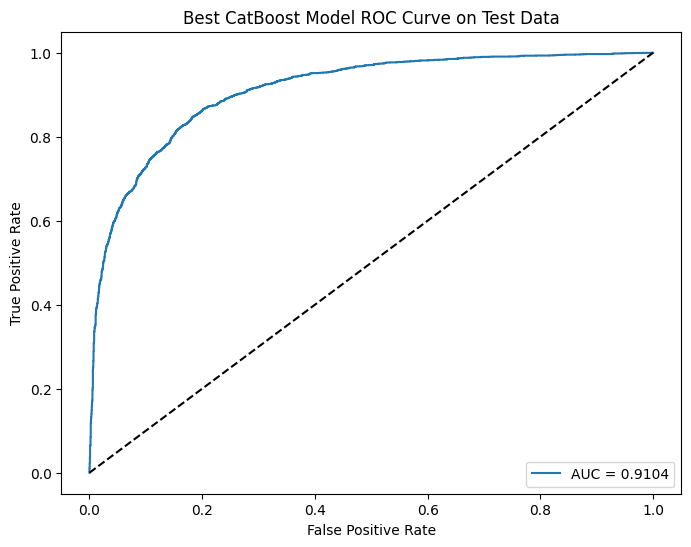

2025-02-12 11:38:51,642 - INFO - Best CatBoost model saved to 'best_catboost_model.pkl'.


In [9]:
import os
import logging
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import MissingIndicator
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostClassifier
from scipy.stats import uniform, randint

# Create a pipeline with the preprocessor and CatBoost classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier(
        iterations= 500,  # Increase the number of iterations if needed
        learning_rate=0.1,
        depth=6,
        loss_function='Logloss',
        verbose=0,
        random_seed=RANDOM_STATE
    ))
])

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'classifier__iterations': randint(1000, 5000),  # Wider range for iterations
    'classifier__learning_rate': uniform(0.01, 0.3),  # Wider range for learning rate
    'classifier__depth': randint(4, 12),  # Wider range for depth
    'classifier__l2_leaf_reg': uniform(1e-2, 10),  # L2 regularization
    'classifier__border_count': randint(32, 255),  # Border count
    'classifier__bagging_temperature': uniform(0, 1),  # Bagging temperature
    'classifier__random_strength': uniform(1e-9, 10),  # Random strength
    'classifier__od_type': ['IncToDec', 'Iter'],  # Overfitting detector type
    'classifier__od_wait': randint(10, 50)  # Overfitting detector wait
}

# Perform RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=20,  # Increase the number of parameter settings sampled if needed
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE),
    scoring=SCORING_METRIC,
    n_jobs=CPU_COUNT,
    verbose=VERBOSE,
    random_state=RANDOM_STATE
)

random_search.fit(X_train_with_indicators, y_train)

# Log the best parameters and score
logging.info("Best parameters found: " + str(random_search.best_params_))
logging.info(f"Best cross-validation {SCORING_METRIC}: {random_search.best_score_:.4f}")

# Evaluate the best model
best_model = random_search.best_estimator_

# Transform the data using the fitted preprocessor in the best model
X_train_transformed = best_model.named_steps['preprocessor'].transform(X_train_with_indicators)
X_test_transformed = best_model.named_steps['preprocessor'].transform(X_test_with_indicators)

# Predict and evaluate
y_pred = best_model.predict(X_test_with_indicators)
y_pred_proba = best_model.predict_proba(X_test_with_indicators)[:, 1]

logging.info("=== Best CatBoost Model Evaluation ===")
logging.info("Confusion Matrix:\n" + str(confusion_matrix(y_test, y_pred)))
logging.info("\nClassification Report:\n" + str(classification_report(y_test, y_pred)))
logging.info(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_pred_proba):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Best CatBoost Model ROC Curve on Test Data')
plt.legend(loc='lower right')
plt.show()

# Save the best model
model_save_path = 'best_catboost_model.pkl'
joblib.dump(best_model, model_save_path)
logging.info(f"Best CatBoost model saved to '{model_save_path}'.")

In [11]:
model_filename = os.path.expanduser('~/work/vaping_project_data/best_cb_model.joblib')
joblib.dump(best_model, model_filename)
logging.info(f"Final CatBoost model saved to: {model_filename}")

2025-02-12 12:02:33,700 - INFO - Final CatBoost model saved to: /storage/home/szn5432/work/vaping_project_data/best_cb_model.joblib


In [12]:
# Load the model (when needed)
file_path = os.path.expanduser('~/work/vaping_project_data/best_cb_model.joblib')
loaded_cb = joblib.load(file_path)
print("Model loaded successfully.")

Model loaded successfully.


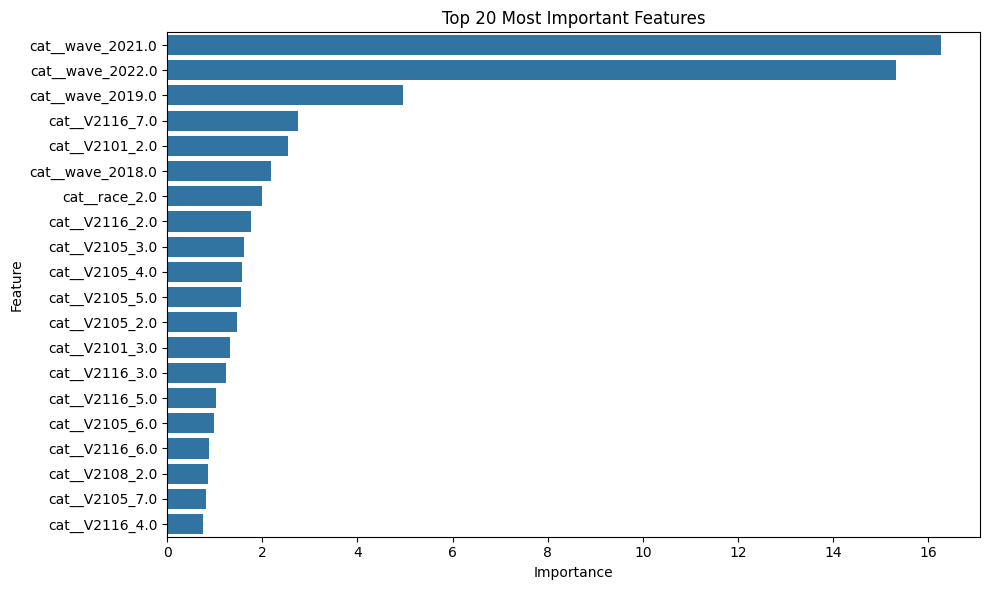

In [14]:
# Function to plot feature importances
def plot_feature_importance(loaded_cb, feature_names, top_n=20, title="Feature Importance"):
    """
    Plots the top N feature importances from a trained model.
    """
    if hasattr(loaded_cb, 'feature_importances_'):
        importances = loaded_cb.feature_importances_
    elif hasattr(loaded_cb, 'named_steps') and 'classifier' in loaded_cb.named_steps:
        if hasattr(loaded_cb.named_steps['classifier'], 'feature_importances_'):
            importances = loaded_cb.named_steps['classifier'].feature_importances_
        else:
            raise ValueError("Classifier does not have feature_importances_ attribute.")
    else:
        raise ValueError("Provided model does not have feature_importances_ attribute.")

    fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    fi_df = fi_df.sort_values('Importance', ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=fi_df)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Get the feature names from the preprocessor
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Plot the top 20 most important features
plot_feature_importance(best_model, feature_names, top_n=20, title="Top 20 Most Important Features")

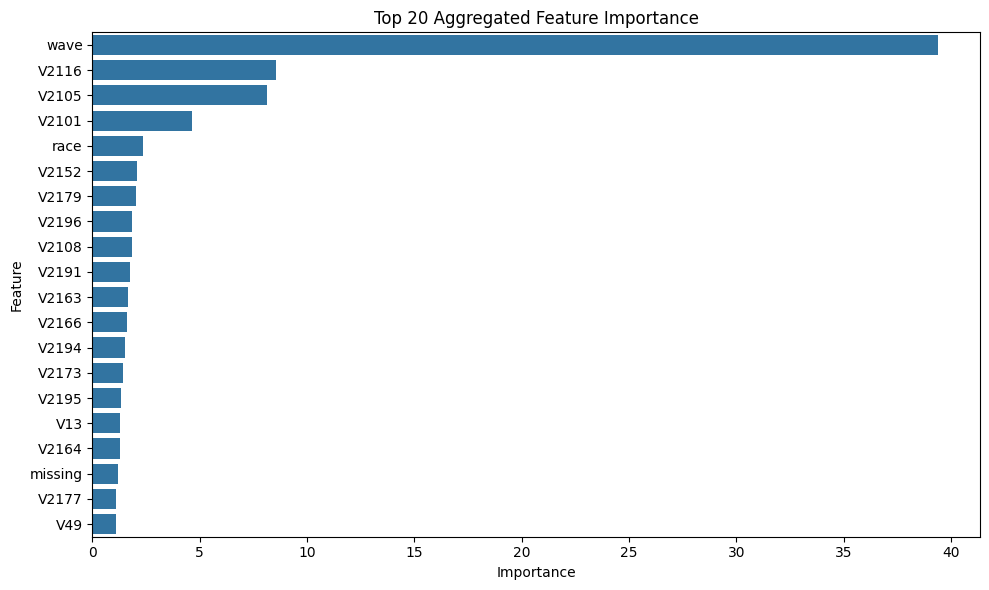

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_aggregated_feature_importance(model, top_n=20, title="Top 20 Aggregated Feature Importance"):
    """
    Plots the top N aggregated feature importances for a CatBoost model
    that is wrapped inside a Pipeline with a ColumnTransformer.
    
    Parameters
    ----------
    model : Pipeline
        A scikit-learn Pipeline that includes:
          - 'preprocessor': a ColumnTransformer or other transformer
          - 'classifier': a CatBoostClassifier
    top_n : int, optional (default=20)
        How many top aggregated features to display.
    title : str, optional
        Title of the plot.
    """
    # 1. Get the feature names after the preprocessor step
    feature_names = loaded_cb.named_steps['preprocessor'].get_feature_names_out()
    
    # 2. Get the feature importances from CatBoost
    catboost_estimator = loaded_cb.named_steps['classifier']
    if not hasattr(catboost_estimator, 'feature_importances_'):
        raise AttributeError("The CatBoost classifier does not expose 'feature_importances_'.")

    importances = catboost_estimator.feature_importances_

    # 3. Aggregate importances by original feature
    aggregated_importance = {}
    
    for name, imp in zip(feature_names, importances):
        # Example naming conventions after ColumnTransformer + OneHotEncoder:
        #   "onehotencoder__Gender_Male"
        #   "remainder__Age"
        # Adjust this parsing logic as necessary for your pipeline.
        
        if "__" in name:
            # Split on the double underscore to separate the transformer name vs. the actual column
            parts = name.split("__", maxsplit=1)
            # parts[0] might be 'onehotencoder' or 'remainder'
            # parts[1] might be 'Gender_Male' or 'Age'
            # We'll then split again on '_' if needed to get just the original column name
            col_part = parts[1]
            
            # If the column was numeric (remainder), it may be simply 'Age'.
            # If the column was OHE, it might be 'Gender_Male' or 'Gender_Female'.
            # A simple approach is to take everything before the first underscore as the feature name:
            if "_" in col_part:
                original_feature = col_part.split("_", maxsplit=1)[0]
            else:
                original_feature = col_part
        else:
            # If there's no double underscore, assume the whole name is the feature
            original_feature = name
        
        # Sum up the importances
        aggregated_importance[original_feature] = aggregated_importance.get(original_feature, 0.0) + imp

    # 4. Make a DataFrame of aggregated importances and sort
    agg_df = pd.DataFrame(list(aggregated_importance.items()), columns=["Feature", "Importance"])
    agg_df = agg_df.sort_values("Importance", ascending=False)

    # 5. Plot top N aggregated feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=agg_df.head(top_n))
    plt.title(title)
    plt.tight_layout()
    plt.show()


# --- Usage Example ---
# Assuming you have your best_model pipeline (with 'preprocessor' and CatBoost 'classifier'):

plot_aggregated_feature_importance(best_model, top_n=20, title="Top 20 Aggregated Feature Importance")


Top 10 aggregated features:
 ['wave', 'V2116', 'V2105', 'V2101', 'race', 'V2152', 'V2179', 'V2196', 'V2108', 'V2191']


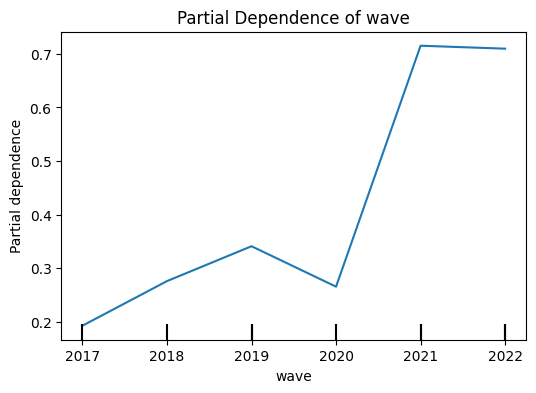

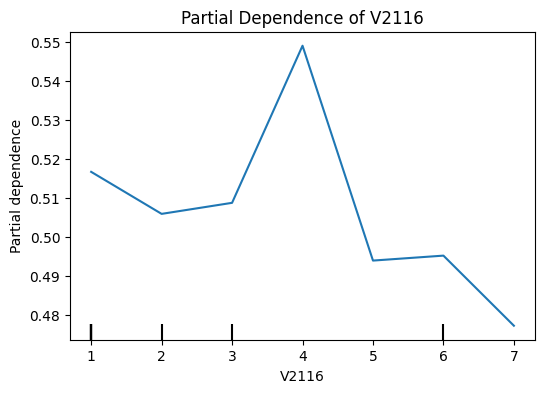

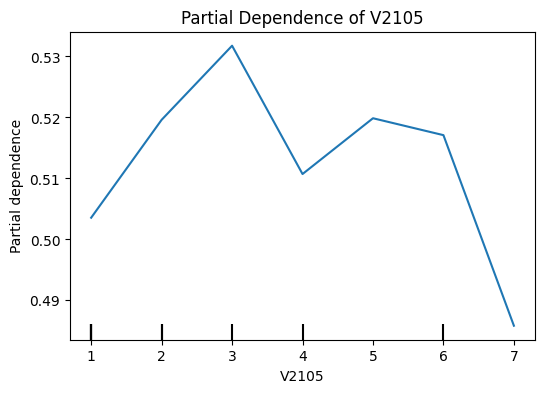

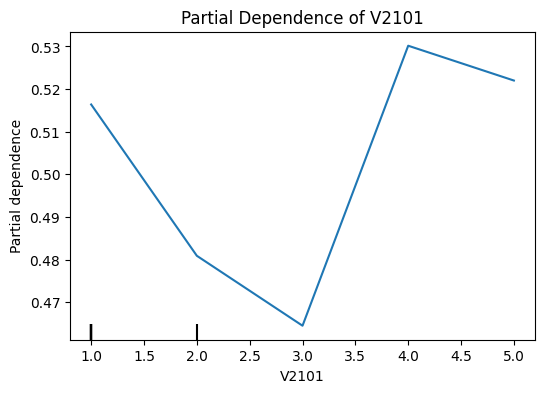

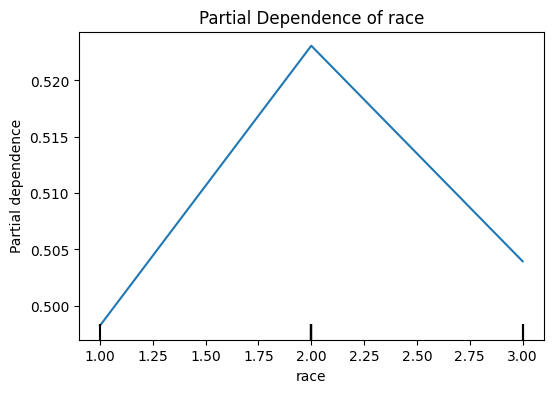

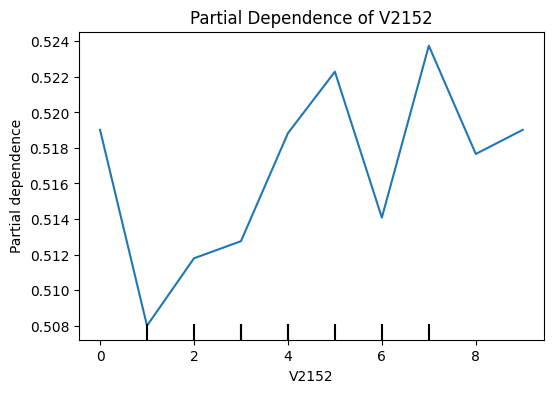

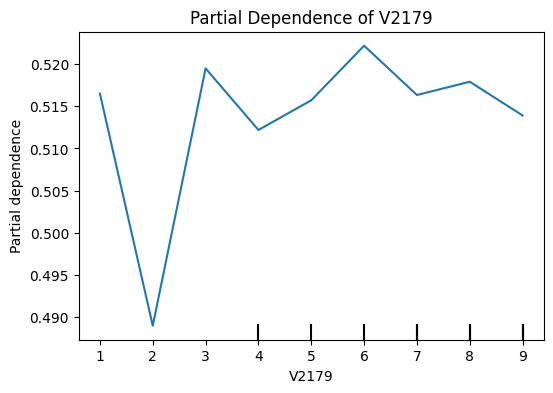

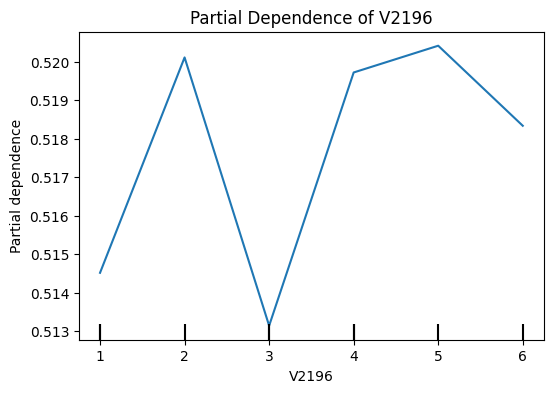

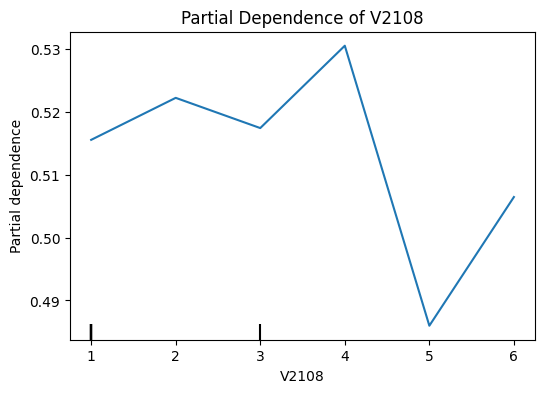

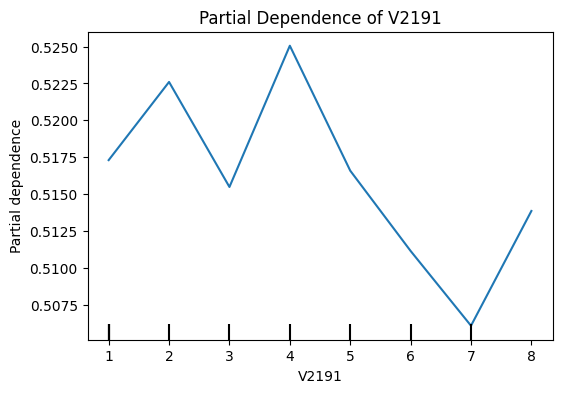

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay


def get_top_aggregated_features(loaded_cb, top_n=10):
    """
    Returns a list of top_n original (aggregated) feature names
    based on the CatBoost feature importances in a Pipeline.
    
    Parameters
    ----------
    model : Pipeline
        A scikit-learn Pipeline with steps:
          - "preprocessor" : ColumnTransformer (or similar)
          - "classifier" : CatBoostClassifier
    top_n : int
        Number of top features to return
        
    Returns
    -------
    list of str
        Top N aggregated feature names
    """
    # Extract feature names that come out of the preprocessor
    feature_names = loaded_cb.named_steps['preprocessor'].get_feature_names_out()
    
    # Extract importances from CatBoost
    catboost_estimator = loaded_cb.named_steps['classifier']
    importances = catboost_estimator.feature_importances_

    # Aggregate importances by the original (pre-encoding) feature name
    aggregated_importance = {}
    for name, imp in zip(feature_names, importances):
        if "__" in name:
            # Example: "onehotencoder__Gender_Male" -> original_feature = "Gender"
            parts = name.split("__", maxsplit=1)
            col_part = parts[1]
            if "_" in col_part: 
                # For OHE columns like "Gender_Male"
                original_feature = col_part.split("_", maxsplit=1)[0]
            else:
                # For remainder numeric columns
                original_feature = col_part
        else:
            # If no __, assume name is the feature
            original_feature = name
        
        aggregated_importance[original_feature] = (
            aggregated_importance.get(original_feature, 0.0) + imp
        )

    # Turn into a DataFrame, sort, and get top_n
    agg_df = pd.DataFrame(
        list(aggregated_importance.items()), 
        columns=["Feature", "Importance"]
    ).sort_values("Importance", ascending=False)

    return agg_df.head(top_n)["Feature"].tolist()

# 1. Get the top 10 features by aggregated importance
top_features = get_top_aggregated_features(best_model, top_n=10)
print("Top 10 aggregated features:\n", top_features)

# Plot the partial dependence plot
for feat in top_features:
    if feat not in X_train_with_indicators.columns:
        print(f"Skipping feature '{feat}' as it is not found in the DataFrame.")
        continue

    fig, ax = plt.subplots(figsize=(6, 4))
    PartialDependenceDisplay.from_estimator(
        estimator=best_model,
        X=X_train_with_indicators,
        features=[feat],
        kind='average',
        grid_resolution=50,
        target=1,  # positive class for binary classification
        ax=ax
    )
    plt.title(f"Partial Dependence of {feat}")
    plt.show()




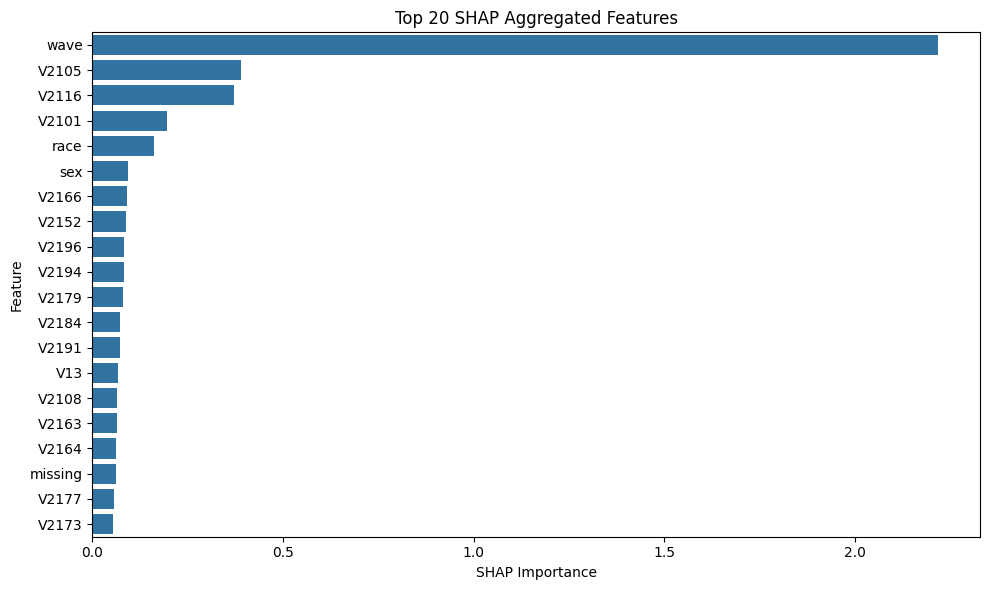

In [22]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

X_train_transformed = loaded_cb.named_steps['preprocessor'].transform(X_train_with_indicators)


def plot_top_shap_aggregated_features(model, X_train_transformed, feature_names, top_n=20, title="Top 20 SHAP Aggregated Features"):
    """
    Plots the top N aggregated SHAP feature importances for a model.
    
    Parameters
    ----------
    model : Pipeline
        A scikit-learn Pipeline that includes:
          - 'preprocessor': a ColumnTransformer or other transformer
          - 'classifier': a CatBoostClassifier
    X_train_transformed : array-like
        Transformed training data (output of the preprocessor).
    feature_names : array-like
        Feature names after transformation.
    top_n : int, optional (default=20)
        How many top aggregated features to display.
    title : str, optional
        Title of the plot.
    """
    # 1. Extract the classifier from the pipeline
    catboost_estimator = loaded_cb.named_steps['classifier']
    
    # 2. Initialize SHAP explainer for the CatBoost model
    explainer = shap.TreeExplainer(catboost_estimator)
    
    # 3. Compute SHAP values for the transformed training data
    shap_values = explainer.shap_values(X_train_transformed)

    # For classification problems, shap_values is a list (one element per class).
    # We use the positive class for binary classification (index 1).
    if isinstance(shap_values, list):
        shap_values = shap_values[1]
    
    # 4. Aggregate SHAP values back to the original feature names
    aggregated_shap = {}
    for i, name in enumerate(feature_names):
        # Parse original feature name from encoded feature name
        if "__" in name:
            col_part = name.split("__", maxsplit=1)[1]  # Split after the double underscore
            if "_" in col_part:
                original_feature = col_part.split("_", maxsplit=1)[0]
            else:
                original_feature = col_part
        else:
            original_feature = name

        # Sum SHAP values for the same original feature
        aggregated_shap[original_feature] = aggregated_shap.get(original_feature, 0.0) + abs(shap_values[:, i]).mean()
    
    # 5. Create a DataFrame of aggregated SHAP values and sort by importance
    shap_df = pd.DataFrame(list(aggregated_shap.items()), columns=["Feature", "SHAP Importance"])
    shap_df = shap_df.sort_values("SHAP Importance", ascending=False)

    # 6. Plot the top N SHAP aggregated feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x="SHAP Importance", y="Feature", data=shap_df.head(top_n))
    plt.title(title)
    plt.tight_layout()
    plt.show()


# --- Usage Example ---
# Assuming you have:
# - 'best_model': your fitted pipeline
# - 'X_train_transformed': the transformed training data
# - 'feature_names': the output of 'get_feature_names_out()' from the preprocessor

plot_top_shap_aggregated_features(
     model=best_model,
     X_train_transformed=X_train_transformed,
     feature_names=best_model.named_steps['preprocessor'].get_feature_names_out(),
     top_n=20,
     title="Top 20 SHAP Aggregated Features"
)


In [23]:
###################################
# SHAP Interactions
###################################

import shap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Extract the classifier from the pipeline ---
catboost_estimator = loaded_cb.named_steps['classifier']

# --- Step 2: Initialize SHAP explainer ---
explainer = shap.TreeExplainer(catboost_estimator)

In [24]:
# Sample a subset of the training data
sample_size = 2  # Adjust based on available memory and dataset size
X_train_sample = X_train_with_indicators.sample(n=sample_size, random_state=42)

# Transform the sampled data
X_train_sample_transformed = loaded_cb.named_steps['preprocessor'].transform(X_train_sample)

# Compute SHAP interaction values for the sample
interaction_values = explainer.shap_interaction_values(X_train_sample_transformed)

In [40]:
import numpy as np
import pandas as pd

# Get the feature names from your fitted pipeline
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Inspect them to see how they're named
print("Transformed feature names:\n", feature_names)

# A helper function to check if a transformed column belongs to a given original feature
def belongs_to_original(col_name: str, original_feat: str) -> bool:
    parts = col_name.split("__", maxsplit=1)
    if len(parts) == 2:
        encoded_part = parts[1]  # e.g. "V2137_0"
    else:
        encoded_part = parts[0]
    return (encoded_part == original_feat) or encoded_part.startswith(original_feat + "_")

# Create a dictionary to map each original categorical feature to its transformed columns
feature_mapping = {}
for feature in original_categorical_features:
    matched_cols = [
        col for col in feature_names 
        if belongs_to_original(col, feature)
    ]
    feature_mapping[feature] = matched_cols

# Now do your SHAP interaction aggregation
aggregated_interaction_matrix = np.zeros((len(original_categorical_features), len(original_categorical_features)))

for i, feature_i in enumerate(original_categorical_features):
    for j, feature_j in enumerate(original_categorical_features):
        indices_i = [feature_names.tolist().index(c) for c in feature_mapping[feature_i]]
        indices_j = [feature_names.tolist().index(c) for c in feature_mapping[feature_j]]
        
        # Sum absolute interaction values for these columns
        aggregated_interaction_matrix[i, j] = np.sum(np.abs(interaction_values[:, indices_i, :][:, :, indices_j]))

aggregated_interaction_df = pd.DataFrame(
    aggregated_interaction_matrix,
    index=original_categorical_features,
    columns=original_categorical_features
)

print("Aggregated Interaction DataFrame:\n", aggregated_interaction_df)


Transformed feature names:
 ['cat__V2157_1.0' 'cat__V2157_nan' 'cat__V49_1.0' 'cat__V49_2.0'
 'cat__V49_3.0' 'cat__V49_nan' 'cat__V2134_2.0' 'cat__V2134_3.0'
 'cat__V2134_4.0' 'cat__V2134_5.0' 'cat__V2134_6.0' 'cat__V2134_7.0'
 'cat__V2134_nan' 'cat__V2153_2.0' 'cat__V2153_3.0' 'cat__V2153_4.0'
 'cat__V2153_nan' 'cat__V2116_2.0' 'cat__V2116_3.0' 'cat__V2116_4.0'
 'cat__V2116_5.0' 'cat__V2116_6.0' 'cat__V2116_7.0' 'cat__V2116_nan'
 'cat__V13_2.0' 'cat__V13_3.0' 'cat__V13_4.0' 'cat__V2140_2.0'
 'cat__V2140_3.0' 'cat__V2140_4.0' 'cat__V2140_5.0' 'cat__V2140_6.0'
 'cat__V2140_7.0' 'cat__V2140_nan' 'cat__V2101_2.0' 'cat__V2101_3.0'
 'cat__V2101_4.0' 'cat__V2101_5.0' 'cat__V2101_nan' 'cat__V2191_2.0'
 'cat__V2191_3.0' 'cat__V2191_4.0' 'cat__V2191_5.0' 'cat__V2191_6.0'
 'cat__V2191_7.0' 'cat__V2191_8.0' 'cat__V2191_nan' 'cat__V2152_1.0'
 'cat__V2152_2.0' 'cat__V2152_3.0' 'cat__V2152_4.0' 'cat__V2152_5.0'
 'cat__V2152_6.0' 'cat__V2152_7.0' 'cat__V2152_8.0' 'cat__V2152_9.0'
 'cat__V2152_nan' 'c

Top 30 Feature Interactions (Excluding Self-Interactions & Duplicates):
Interaction (V2105, wave): 1.9728488212374897
Interaction (V2116, wave): 1.1566998044314074
Interaction (race, wave): 0.31079737388929707
Interaction (V2101, wave): 0.26305555965420824
Interaction (V2197, wave): 0.18728253459224758
Interaction (V2196, wave): 0.16919369193408357
Interaction (V2194, wave): 0.14997813427137727
Interaction (V2166, wave): 0.1282938088687391
Interaction (V2195, wave): 0.12769411349465037
Interaction (V2173, wave): 0.10333913005811653
Interaction (V2179, wave): 0.1028424481437713
Interaction (V2176, wave): 0.09279114393458086
Interaction (V2108, wave): 0.0878132859731873
Interaction (V2152, wave): 0.0794637414272116
Interaction (V13, wave): 0.07865744057839633
Interaction (sex, wave): 0.07614106689400205
Interaction (V2197, V2116): 0.06794943268369337
Interaction (V2191, wave): 0.06688503874390286
Interaction (V2105, V2116): 0.062367024383114485
Interaction (V2105, V2196): 0.0606957053593

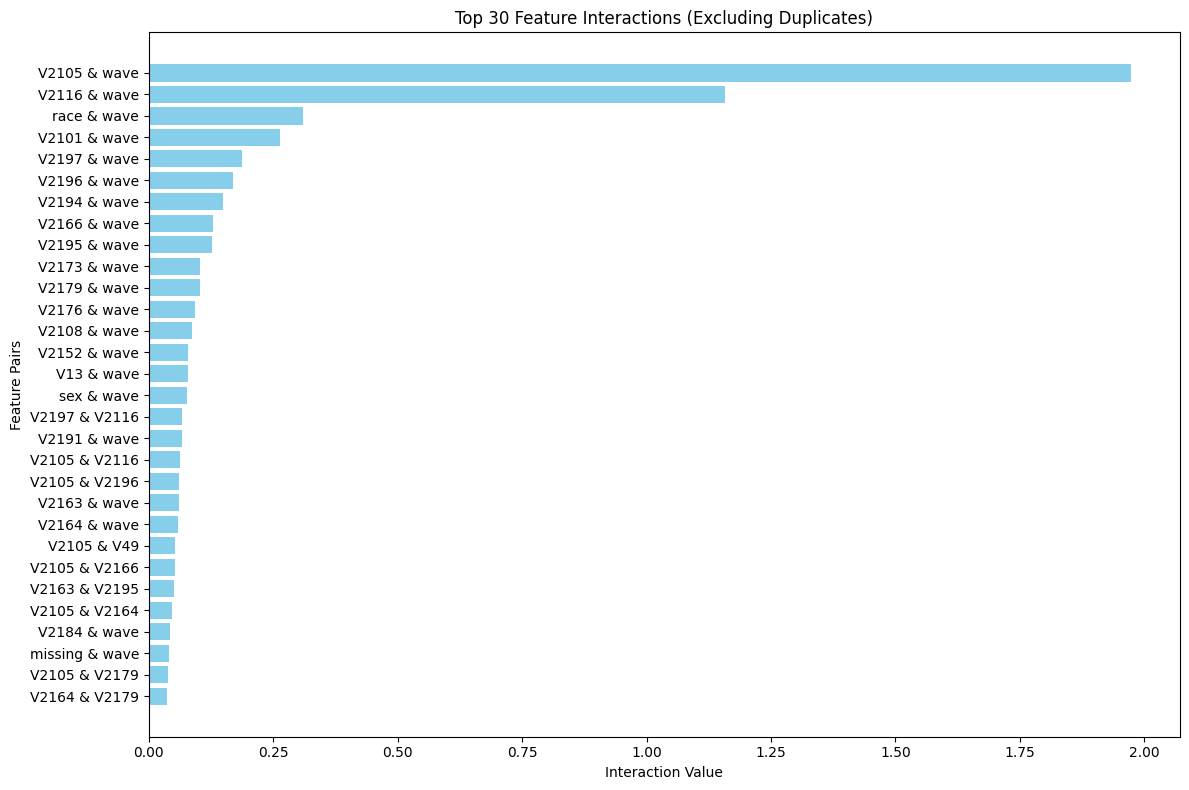

In [42]:
# Step 1: Store interactions and their values, avoiding self-interactions AND duplicates
interaction_results = []

for i, feature_i in enumerate(original_categorical_features):
    # Only loop j from i+1 to end, ensuring j > i
    for j in range(i + 1, len(original_categorical_features)):
        feature_j = original_categorical_features[j]

        # Get indices for feature_i and feature_j
        indices_i = [
            feature_names.tolist().index(col) 
            for col in feature_mapping[feature_i] 
            if col in feature_names.tolist()
        ]
        indices_j = [
            feature_names.tolist().index(col) 
            for col in feature_mapping[feature_j] 
            if col in feature_names.tolist()
        ]

        if not indices_i or not indices_j:
            continue

        # Compute interaction value
        value = np.sum(np.abs(interaction_values[:, indices_i, :][:, :, indices_j]))
        interaction_results.append(((feature_i, feature_j), value))

# Step 2: Sort the interactions by their absolute value (descending)
sorted_interactions = sorted(interaction_results, key=lambda x: x[1], reverse=True)

# Step 3: Select the top 30 interactions
top_30_interactions = sorted_interactions[:30]

# Step 4: Display the results
print("Top 30 Feature Interactions (Excluding Self-Interactions & Duplicates):")
for (feature_pair, interaction_value) in top_30_interactions:
    print(f"Interaction ({feature_pair[0]}, {feature_pair[1]}): {interaction_value}")

# Step 5 (Optional): Visualize the top 30 interactions
import matplotlib.pyplot as plt

# Extract feature pairs and their values
feature_pairs = [f"{pair[0]} & {pair[1]}" for pair, _ in top_30_interactions]
values = [value for _, value in top_30_interactions]

# Create a bar plot
plt.figure(figsize=(12, 8))
plt.barh(feature_pairs, values, color='skyblue')
plt.xlabel('Interaction Value')
plt.ylabel('Feature Pairs')
plt.title('Top 30 Feature Interactions (Excluding Duplicates)')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.tight_layout()
plt.show()
